In [22]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize()
import multiprocessing
import numpy as np
import os
from collections import Counter, defaultdict
import itertools
import sys 
sys.path.append("..") 

%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from utils import prinT
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [24]:
from scipy.linalg import orthogonal_procrustes
from sklearn.metrics.pairwise import cosine_similarity, paired_distances

In [25]:
model = p2v.P2V()

2023-11-08 14:35:46 -- start loading Mag_venue_info_df
2023-11-08 14:35:46 -- finish.
2023-11-08 14:35:46 -- start loading labeled_journal_info_df
2023-11-08 14:35:47 -- finish.


# 1. Use the last decade as the reference

In [26]:
k_list = [8, 8, 13, 25, 19, 18, 23]
# k_list = [25, 25, 25, 25, 25, 25]
start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']
ref_start_year = 2010
ref_end_year = 2021

# 1.1.1 Filtering periodicals with low global maximum neighbor similarities

In [28]:
def get_tar_neighbor(VID, i):
    try:
        return tar_wv.most_similar(positive=int(VID), topn=k_list[i])
    except KeyError:
        return np.nan


def get_ref_neighbor(VID, i):
    return ref_wv.most_similar(positive=int(VID), topn=k_list[i])


def get_avg_neighbor_sim(tup_list):
    neighbor_sim_list = [tup[1] for tup in tup_list]
    return sum(neighbor_sim_list) / len(neighbor_sim_list)


def get_max_neighbor_sim(tup_list):
    if isinstance(tup_list, list):
        neighbor_sim_list = [tup[1] for tup in tup_list]
        return max(neighbor_sim_list)
    else:
        return np.nan


In [29]:
prinT("start find the similarity between every perdiocial with its closet neighbor ...")

ref_wv = model.load_wv(ref_start_year, ref_end_year, 100, 10)
ref_VIDs = ref_wv.index_to_key

neighbor_sim_df = pd.DataFrame({'VID':ref_VIDs})
for i in range(0, 7):
    print("processing {}s ...".format(start_year_list[i]))
    tar_wv = model.load_wv(start_year_list[i], end_year_list[i], 100, 10)
    neighbor_sim_df['neighbor_tup_list_'+start_year_list[i]+'s'] = neighbor_sim_df.VID.apply(get_tar_neighbor, args=(i,))
    neighbor_sim_df['max_neighbor_sim_'+start_year_list[i]+'s'] = neighbor_sim_df['neighbor_tup_list_'+start_year_list[i]+'s'].apply(get_max_neighbor_sim)

neighbor_sim_df.loc[:,'venue_name'] = neighbor_sim_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
VID_labele_dict = model.load_VID_labeled(ref_start_year, ref_end_year, 100, 10)
neighbor_sim_df['scopus_label'] = neighbor_sim_df.VID.map(lambda x: 
                                          VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                          else np.nan)

2023-11-08 14:35:59 -- start find the similarity between every perdiocial with its closet neighbor ...
2023-11-08 14:35:59 -- start loading word vectors...
2023-11-08 14:35:59 -- word vectors loaded, and its shape is: (37594, 100)
processing 1950s ...
2023-11-08 14:35:59 -- start loading word vectors...
2023-11-08 14:35:59 -- word vectors loaded, and its shape is: (1645, 100)
processing 1960s ...
2023-11-08 14:36:00 -- start loading word vectors...
2023-11-08 14:36:00 -- word vectors loaded, and its shape is: (3116, 100)
processing 1970s ...
2023-11-08 14:36:01 -- start loading word vectors...
2023-11-08 14:36:01 -- word vectors loaded, and its shape is: (5686, 100)
processing 1980s ...
2023-11-08 14:36:02 -- start loading word vectors...
2023-11-08 14:36:02 -- word vectors loaded, and its shape is: (9337, 100)
processing 1990s ...
2023-11-08 14:36:04 -- start loading word vectors...
2023-11-08 14:36:04 -- word vectors loaded, and its shape is: (15019, 100)
processing 2000s ...
2023-11

In [30]:
neighbor_sim_df['global_max_neighbor_sim'] = neighbor_sim_df[['max_neighbor_sim_1950s', 
                                                              'max_neighbor_sim_1960s', 
                                                              'max_neighbor_sim_1970s', 
                                                              'max_neighbor_sim_1980s', 
                                                              'max_neighbor_sim_1990s', 
                                                              'max_neighbor_sim_2000s', 
                                                              'max_neighbor_sim_2010s']].max(axis=1)

5th percentile: 0.7163653284311294


<Figure size 1920x1440 with 0 Axes>

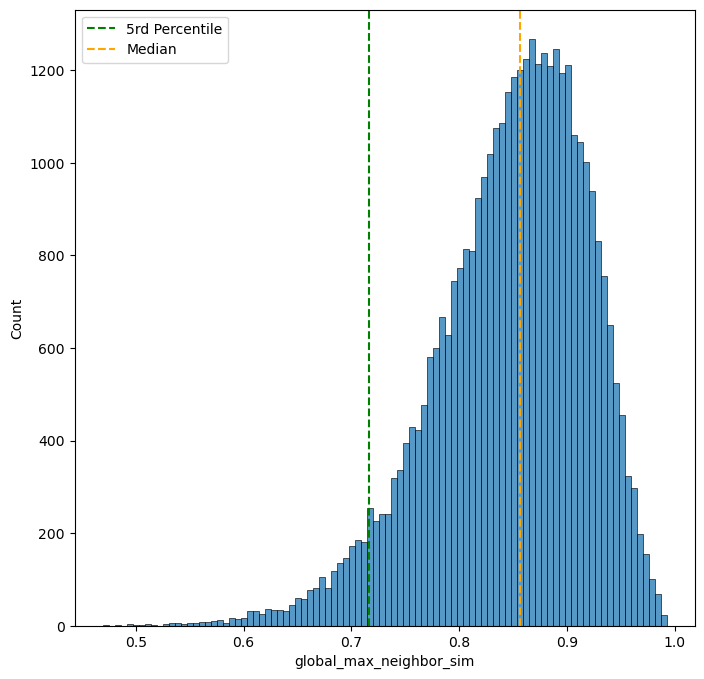

In [31]:
print('5th percentile:', neighbor_sim_df['global_max_neighbor_sim'].quantile(0.05))

plt.figure(dpi=300)
plt.figure(figsize=(8, 8))

sns.histplot(data=neighbor_sim_df, x='global_max_neighbor_sim')
plt.axvline(neighbor_sim_df['global_max_neighbor_sim'].quantile(0.05), c='green', ls='--', lw=1.5, label='5rd Percentile')
plt.axvline(neighbor_sim_df['global_max_neighbor_sim'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()

In [46]:
neighbor_sim_df = neighbor_sim_df[neighbor_sim_df['global_max_neighbor_sim']>=neighbor_sim_df['global_max_neighbor_sim'].quantile(0.05)]
prinT("the number of filtered periodicals: %d" %len(neighbor_sim_df))

2023-11-08 15:13:41 -- the number of filtered periodicals: 35714


# 1.1.2 Filtering corrupted data

In [207]:
corrupted_venue_name_list = ['Japanese Journal of Pharmacology', 
                             'Journal of Computers',
                             'Journal of Algorithms',
                             'Journal of Agricultural Engineering Research',
                             'Sozial-und Praventivmedizin',
                             'Scientia Forestalis',
                             'Interpretation',
                             'Genes',
                             'Protein Science',
                             'Hospital Medicine',
                             'Immunotechnology',
                             'Journal of Ayurveda and Integrative Medicine',
                             'Versus',
                             'Tradition',
                             'ACM Transactions on Cyber-Physical Systems',
                             'Journal of Biomedical Engineering',
                             'Antibiotics and Chemotherapy',
                             'Social Work',
                             'Production Journal',
                             'Insight',
                             'Sats',
                             'English',
                             'Leonardo',
                             'The Forum',
                             'Chemical Industry',
                             'The American review of respiratory disease',
                             'Chemistry & Industry',
                            ]
neighbor_sim_df = neighbor_sim_df[~neighbor_sim_df['venue_name'].isin(corrupted_venue_name_list)]
prinT("the number of filtered periodicals: %d" %len(neighbor_sim_df))

2023-11-09 13:13:16 -- the number of filtered periodicals: 35687


In [110]:
neighbor_sim_df[['venue_name',
                 'scopus_label',
                 'global_max_neighbor_sim',
                 'max_neighbor_sim_1950s',
                 'max_neighbor_sim_1960s',
                 'max_neighbor_sim_1970s',
                 'max_neighbor_sim_1980s',
                 'max_neighbor_sim_1990s',
                 'max_neighbor_sim_2000s',
                 'max_neighbor_sim_2010s',]]
ref_VIDs = neighbor_sim_df['VID'].to_list()

# Define functions used in processing distance time series

In [54]:
def filter_nan_in_middle(x):
    val_list = x.to_list()
    
    start_idx = -1
    end_idx = -1
    nan_in_middle = False
    for i in range(0, len(val_list)):
        if not np.isnan(val_list[i]):
            start_idx = i
            break
    for i in range(len(val_list)-1, -1, -1):
        if not np.isnan(val_list[i]):
            end_idx = i
            break
    for i in range(start_idx, end_idx):
        if np.isnan(val_list[i]):
            nan_in_middle = True
            break
    if start_idx == end_idx:
        len_of_1 = True
    else :
        len_of_1 = False

    return nan_in_middle, len_of_1, start_idx, end_idx


def cal_max_dist_change(x):
    val_list = x.to_list()
    
    return np.nanmax(val_list)


def cal_mean_dist_change(x):
    val_list = x.to_list()
    
    return np.nanmean(val_list)


def cal_c_dist_change(x):
    val_list = x.to_list()
    
    return np.nansum(val_list)

# 1.2 Using cosine similairty as the measurement

In [111]:
self_dist_df = neighbor_sim_df[['VID', 'global_max_neighbor_sim']]

for i in range(0, 6):
    tar_start_year = start_year_list[i]
    tar_end_year = end_year_list[i]
    print("-----------------------")
    prinT("start comparing {start_year}-{end_year} with the reference decade".format(start_year=tar_start_year, end_year=tar_end_year))

    tar_wv = model.load_wv(tar_start_year, tar_end_year, 100, 10)
    
    tar_VIDs = tar_wv.index_to_key
    shared_VIDs = list(set(tar_VIDs) & set(ref_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    tar_idx = [tar_wv.get_index(VID) for VID in shared_VIDs]
    ref_idx = [ref_wv.get_index(VID) for VID in shared_VIDs]
    
    tar_vectors = tar_wv.get_normed_vectors()[tar_idx]
    ref_vectors = ref_wv.get_normed_vectors()[ref_idx]
    
    prinT("start aligning...")
    R, sca = orthogonal_procrustes(tar_vectors, ref_vectors)
    aligned_tar_vectors = np.dot(tar_vectors, R)
    prinT("finish. start compute cosine distance...")
    # cs = np.diagonal(cosine_similarity(aligned_tar_vectors, ref_vectors))
    dist =  paired_distances(aligned_tar_vectors, ref_vectors, metric='cosine')
    prinT("finish")

    tar_dist_df = pd.DataFrame({'VID': shared_VIDs,
                              'self_distance_'+tar_start_year+'s': dist})
    self_dist_df = self_dist_df.merge(tar_dist_df,
                                      on='VID',
                                      how='outer')
    
self_dist_df['self_distance_2010s'] = 0.0

self_dist_df.loc[:,'venue_name'] = self_dist_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
VID_labele_dict = model.load_VID_labeled(ref_start_year, ref_end_year, 100, 10)
self_dist_df['scopus_label'] = self_dist_df.VID.map(lambda x: 
                                          VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                          else np.nan)

-----------------------
2023-11-08 16:28:41 -- start comparing 1950-1959 with the reference decade
2023-11-08 16:28:41 -- start loading word vectors...
2023-11-08 16:28:41 -- word vectors loaded, and its shape is: (1645, 100)
2023-11-08 16:28:41 -- the number of shared VIDs between this two decades: 1184
2023-11-08 16:28:41 -- start aligning...
2023-11-08 16:28:41 -- finish. start compute cosine distance...
2023-11-08 16:28:41 -- finish
-----------------------
2023-11-08 16:28:41 -- start comparing 1960-1969 with the reference decade
2023-11-08 16:28:41 -- start loading word vectors...
2023-11-08 16:28:41 -- word vectors loaded, and its shape is: (3116, 100)
2023-11-08 16:28:41 -- the number of shared VIDs between this two decades: 2325
2023-11-08 16:28:41 -- start aligning...
2023-11-08 16:28:41 -- finish. start compute cosine distance...
2023-11-08 16:28:41 -- finish
-----------------------
2023-11-08 16:28:41 -- start comparing 1970-1979 with the reference decade
2023-11-08 16:28:41

In [112]:
self_dist_df[['nan_in_middle', 'len_of_1', 'start_idx', 'end_idx']] = self_dist_df[['self_distance_1950s',
                                                                                    'self_distance_1960s',
                                                                                    'self_distance_1970s',
                                                                                    'self_distance_1980s',
                                                                                    'self_distance_1990s',
                                                                                    'self_distance_2000s',
                                                                                    'self_distance_2010s']].apply(filter_nan_in_middle, axis=1, result_type="expand")

In [113]:
self_dist_df.drop(self_dist_df[self_dist_df.end_idx<6].index, inplace=True)
self_dist_df.drop(self_dist_df[self_dist_df.scopus_label.isna()].index, inplace=True)
self_dist_df.drop(self_dist_df[(self_dist_df.nan_in_middle==True)|(self_dist_df.len_of_1==True)].index, inplace=True)

In [114]:
self_dist_df['max_dist'] = self_dist_df[['self_distance_1950s',
                                         'self_distance_1960s',
                                         'self_distance_1970s',
                                         'self_distance_1980s',
                                         'self_distance_1990s',
                                         'self_distance_2000s',
                                         'self_distance_2010s']].apply(cal_max_dist_change, axis=1)
self_dist_df['mean_dist'] = self_dist_df[['self_distance_1950s',
                                          'self_distance_1960s',
                                          'self_distance_1970s',
                                          'self_distance_1980s',
                                          'self_distance_1990s',
                                          'self_distance_2000s',
                                          'self_distance_2010s']].apply(cal_mean_dist_change, axis=1)
self_dist_df['c_dist'] = self_dist_df[['self_distance_1950s',
                                       'self_distance_1960s',
                                       'self_distance_1970s',
                                       'self_distance_1980s',
                                       'self_distance_1990s',
                                       'self_distance_2000s',
                                       'self_distance_2010s']].apply(cal_c_dist_change, axis=1)

In [126]:
# metrics = 'max_dist'
metrics = 'mean_dist'
# metrics = 'c_dist'

In [127]:
self_dist_df.sort_values(by=metrics, ascending=False).head(50)

,VID,global_max_neighbor_sim,self_distance_1950s,self_distance_1960s,self_distance_1970s,self_distance_1980s,self_distance_1990s,self_distance_2000s,self_distance_2010s,venue_name,scopus_label,nan_in_middle,len_of_1,start_idx,end_idx,max_dist,mean_dist,c_dist
22818,6.531517e+07,0.723728,0.630702,0.742751,0.633404,0.793736,0.648667,0.427178,0.0,Endeavour,Arts and Humanities,False,False,0,6,0.793736,0.553777,3.876439
34921,1.595755e+08,0.817540,NaN,NaN,0.690189,0.644225,0.642332,0.694546,0.0,Western Journal of Medicine,Medicine,False,False,2,6,0.694546,0.534258,2.671292
8869,1.890763e+08,0.730568,NaN,NaN,0.537315,0.645486,0.546955,0.796662,0.0,Mount Sinai Journal of Medicine,Medicine,False,False,2,6,0.796662,0.505283,2.526417
25736,6.408156e+07,0.897246,NaN,NaN,0.541531,0.649040,0.783834,0.544046,0.0,Solid State Technology,Engineering,False,False,2,6,0.783834,0.503690,2.518451
12627,1.205445e+07,0.810934,0.631173,0.640134,0.632603,0.548925,0.569377,0.472077,0.0,The Imaging Science Journal,Computer Science,False,False,0,6,0.640134,0.499184,3.494288
16940,2.764690e+09,0.854411,NaN,NaN,0.546890,0.582788,0.596818,0.629190,0.0,Transactional Analysis Journal,Psychology,False,False,2,6,0.629190,0.471137,2.355685
26887,1.819863e+08,0.947027,NaN,NaN,0.536132,0.654708,0.559882,0.567171,0.0,Tel Aviv: Journal of The Institute of Archaeology of Tel Aviv University,Arts and Humanities,False,False,2,6,0.654708,0.463578,2.317892
7742,1.049201e+08,0.775036,NaN,NaN,0.725883,0.577728,0.446905,0.565568,0.0,New Scientist,Multidisciplinary,False,False,2,6,0.725883,0.463217,2.316083
12613,1.514392e+08,0.717308,NaN,0.440514,0.469328,0.482538,0.575127,0.732118,0.0,Annales De Biologie Clinique,Medicine,False,False,1,6,0.732118,0.449937,2.699625
4866,1.631022e+08,0.738962,0.536742,0.573517,0.558913,0.551554,0.403947,0.517047,0.0,British Medical Bulletin,Medicine,False,False,0,6,0.573517,0.448817,3.141720


/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1920x1440 with 0 Axes>

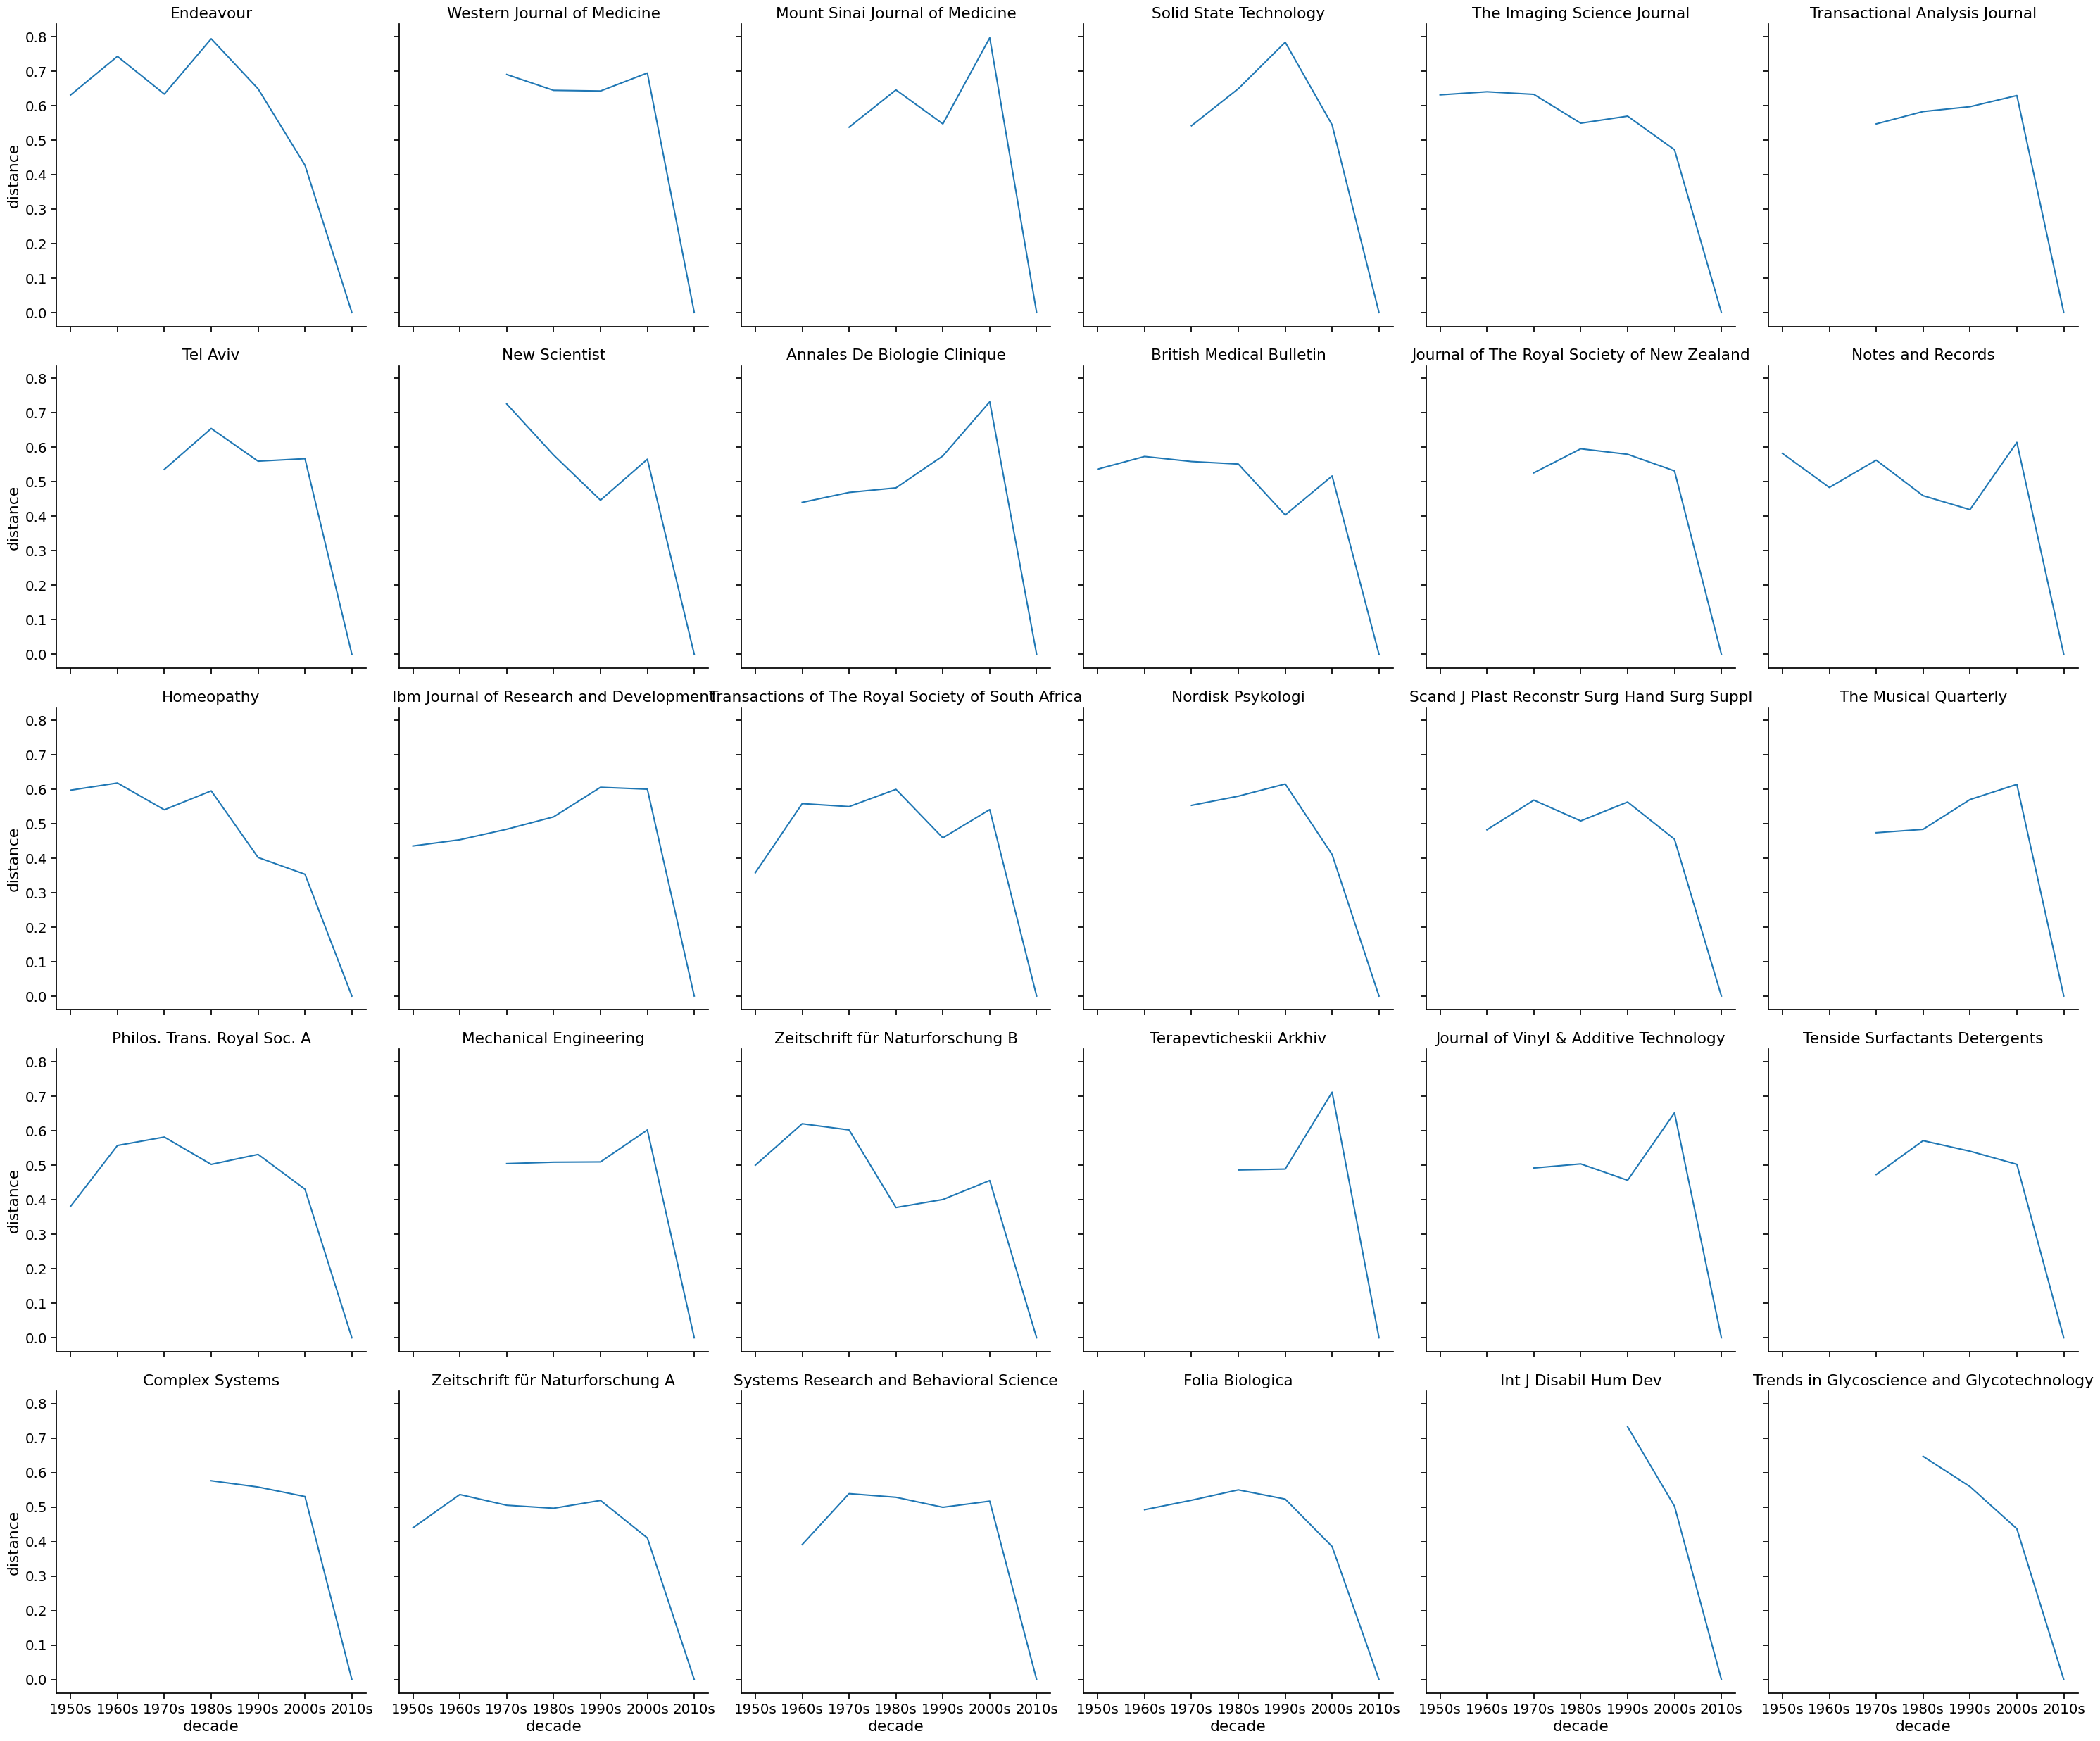

In [129]:
self_dist_df_rename = self_dist_df.copy()
self_dist_df_rename.venue_name = self_dist_df_rename.venue_name.replace({'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
                                                                         'Philosophical Transactions of the Royal Society A':'Philos. Trans. Royal Soc. A',
                                                                         'Philosophical Transactions of the Royal Society B':'Philos. Trans. Royal Soc. B',
                                                                         'Proceedings of The Royal Society B: Biological Sciences': 'Proc. Royal Soc. B',
                                                                         'International Journal on Disability and Human Development': 'Int J Disabil Hum Dev',
                                                                         'Tel Aviv: Journal of The Institute of Archaeology of Tel Aviv University': 'Tel Aviv',
                                                                         'Journal of Huazhong University of Science and Technology': 'J. Huazhong Univ. Sci. Technol. Med. Sci.',
                                                                         'Wiley Interdisciplinary Reviews: Computational Statistics':'WIREs Comp Stats',
                                                                         'International Journal of Pharmaceutical Medicine': 'Int. J. Pharm.',
                                                                         'Periodica Polytechnica Chemical Engineering': 'Period. Polytech. Chem. Eng.',
                                                                         'In Vitro Cellular & Developmental Biology – Plant': 'In Vitro Cell. Dev. Biol. Plant',
                                                                         'Applied Immunohistochemistry & Molecular Morphology': 'Appl. Immunohistochem. Mol. Morphol.',
                                                                         'Scandinavian Journal of Plastic and Reconstructive Surgery and Hand Surgery':'Scand J Plast Reconstr Surg Hand Surg Suppl'
                                                                        })

self_dist_df_wide = pd.wide_to_long(self_dist_df_rename,
                                    stubnames=['self_distance'],
                                    suffix='.+',
                                    sep='_',
                                    i = ['VID', 'venue_name'],
                                    j = 'decade')

periodical_list = self_dist_df_rename.sort_values(by=metrics, ascending=False).head(30).venue_name.to_list()

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(data=self_dist_df_wide,
                     x='decade', y='self_distance',
                     legend=False,
                     col='venue_name', col_wrap=6, 
                     col_order=periodical_list,
                     kind='line')

    g.set_titles("{col_name}")
    g.set_ylabels('distance')

# 1.3 Using local neighbor similarity measure

In [168]:
def cal_distance(x, tar_neighbor_idxs, ref_neighbor_idxs, tar_vectors, ref_vectors):
    neighbor_idx_list = list(set(tar_neighbor_idxs[x]).union(set(ref_neighbor_idxs[x])))
    # tar_neighbor_vectors = [aligned_tar_vectors[idx] for idx in neighbor_idx_list]
    tar_neighbor_vectors = [tar_vectors[idx] for idx in neighbor_idx_list]
    ref_neighbor_vectors = [ref_vectors[idx] for idx in neighbor_idx_list]
    # tar_focal_vector = aligned_tar_vectors[x]
    tar_focal_vector = tar_vectors[x]
    ref_focal_vector = ref_vectors[x]

    tar_second_order_change = cosine_similarity(tar_focal_vector.reshape(1,-1), tar_neighbor_vectors)
    ref_second_order_change = cosine_similarity(ref_focal_vector.reshape(1,-1), ref_neighbor_vectors)

    return paired_distances(tar_second_order_change, ref_second_order_change, metric='cosine')[0]

In [130]:
neighbor_dist_df = neighbor_sim_df[['VID', 'global_max_neighbor_sim']]
for i in range(0, 6):
    tar_start_year = start_year_list[i]
    tar_end_year = end_year_list[i]
    print("-----------------------")
    prinT("start comparing {start_year}-{end_year} with the reference decade".format(start_year=tar_start_year, end_year=tar_end_year))
    
    tar_wv = model.load_wv(tar_start_year, tar_end_year, 100, 10)
    tar_VIDs = tar_wv.index_to_key

    shared_VIDs = list(set(tar_VIDs) & set(ref_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    tar_idx = [tar_wv.get_index(VID) for VID in shared_VIDs]
    ref_idx = [ref_wv.get_index(VID) for VID in shared_VIDs]
    
    tar_vectors = tar_wv.get_normed_vectors()[tar_idx]
    ref_vectors = ref_wv.get_normed_vectors()[ref_idx]
    
    prinT("finish, start generate neighbor union...")
    tar_neighbor_idxs = np.argsort(cosine_similarity(tar_vectors, tar_vectors))[:, -2:-k_list[i]-2:-1]
    ref_neighbor_idxs = np.argsort(cosine_similarity(ref_vectors, ref_vectors))[:, -2:-k_list[-1]-2:-1]
    
    prinT("finish, start calculating local neighborhood change...")
    dist_df = pd.DataFrame({'VID': shared_VIDs})
    dist_df['neighbor_distance_'+tar_start_year+'s'] = dist_df.index.to_series().parallel_apply(cal_distance)
    prinT('finish.')

    neighbor_dist_df = neighbor_dist_df.merge(dist_df, on='VID', how='outer')

neighbor_dist_df['neighbor_distance_2010s'] = 0.0
    
neighbor_dist_df.loc[:,'venue_name'] = neighbor_dist_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
VID_labele_dict = model.load_VID_labeled(ref_start_year, ref_end_year, 100, 10)
neighbor_dist_df['scopus_label'] = neighbor_dist_df.VID.map(lambda x: 
                                          VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                          else np.nan)

-----------------------
2023-11-08 16:50:59 -- start comparing 1950-1959 with the reference decade
2023-11-08 16:50:59 -- start loading word vectors...
2023-11-08 16:50:59 -- word vectors loaded, and its shape is: (1645, 100)
2023-11-08 16:50:59 -- the number of shared VIDs between this two decades: 1184
2023-11-08 16:50:59 -- finish, start generate neighbor union...
2023-11-08 16:51:00 -- finish, start calculating local neighborhood change...
2023-11-08 16:51:01 -- finish.
-----------------------
2023-11-08 16:51:01 -- start comparing 1960-1969 with the reference decade
2023-11-08 16:51:01 -- start loading word vectors...
2023-11-08 16:51:01 -- word vectors loaded, and its shape is: (3116, 100)
2023-11-08 16:51:01 -- the number of shared VIDs between this two decades: 2325
2023-11-08 16:51:01 -- finish, start generate neighbor union...
2023-11-08 16:51:02 -- finish, start calculating local neighborhood change...
2023-11-08 16:51:03 -- finish.
-----------------------
2023-11-08 16:51:0

In [131]:
neighbor_dist_df[['nan_in_middle', 
                  'len_of_1', 
                  'start_idx', 
                  'end_idx']] = neighbor_dist_df[['neighbor_distance_1950s',
                                                  'neighbor_distance_1960s',
                                                  'neighbor_distance_1970s',
                                                  'neighbor_distance_1980s',
                                                  'neighbor_distance_1990s',
                                                  'neighbor_distance_2000s',
                                                  'neighbor_distance_2010s'
                                                 ]].apply(filter_nan_in_middle, axis=1, result_type="expand")

In [132]:
neighbor_dist_df.drop(neighbor_dist_df[neighbor_dist_df.end_idx<6].index, inplace=True)
neighbor_dist_df.drop(neighbor_dist_df[neighbor_dist_df.scopus_label.isna()].index, inplace=True)
neighbor_dist_df.drop(neighbor_dist_df[(neighbor_dist_df.nan_in_middle==True)|(neighbor_dist_df.len_of_1==True)].index, inplace=True)

In [133]:
neighbor_dist_df['max_dist'] = neighbor_dist_df[['neighbor_distance_1950s',
                                                 'neighbor_distance_1960s',
                                                 'neighbor_distance_1970s',
                                                 'neighbor_distance_1980s',
                                                 'neighbor_distance_1990s',
                                                 'neighbor_distance_2000s',
                                                 'neighbor_distance_2010s'
                                                ]].apply(cal_max_dist_change, axis=1)
neighbor_dist_df['mean_dist'] = neighbor_dist_df[['neighbor_distance_1950s',
                                                 'neighbor_distance_1960s',
                                                 'neighbor_distance_1970s',
                                                 'neighbor_distance_1980s',
                                                 'neighbor_distance_1990s',
                                                 'neighbor_distance_2000s',
                                                 'neighbor_distance_2010s'
                                                ]].apply(cal_mean_dist_change, axis=1)
neighbor_dist_df['c_dist'] = neighbor_dist_df[['neighbor_distance_1950s',
                                                 'neighbor_distance_1960s',
                                                 'neighbor_distance_1970s',
                                                 'neighbor_distance_1980s',
                                                 'neighbor_distance_1990s',
                                                 'neighbor_distance_2000s',
                                                 'neighbor_distance_2010s'
                                                ]].apply(cal_c_dist_change, axis=1)

In [137]:
# metrics = 'max_dist'
# metrics = 'mean_dist'
metrics = 'c_dist'

In [134]:
neighbor_dist_df.sort_values(by=metrics, ascending=False).head(50)

,VID,global_max_neighbor_sim,neighbor_distance_1950s,neighbor_distance_1960s,neighbor_distance_1970s,neighbor_distance_1980s,neighbor_distance_1990s,neighbor_distance_2000s,neighbor_distance_2010s,venue_name,scopus_label,nan_in_middle,len_of_1,start_idx,end_idx,max_dist,mean_dist,c_dist
22818,6.531517e+07,0.723728,0.292366,0.422605,0.163110,0.295054,0.120843,0.036525,0.0,Endeavour,Arts and Humanities,False,False,0,6,0.422605,0.190072,1.330503
34921,1.595755e+08,0.817540,NaN,NaN,0.170965,0.210240,0.199465,0.213447,0.0,Western Journal of Medicine,Medicine,False,False,2,6,0.213447,0.158824,0.794118
11585,4.310451e+06,0.752145,0.181706,0.221688,0.145843,0.122026,0.032312,0.037112,0.0,Homeopathy,Medicine,False,False,0,6,0.221688,0.105812,0.740687
7742,1.049201e+08,0.775036,NaN,NaN,0.276651,0.189456,0.104630,0.115600,0.0,New Scientist,Multidisciplinary,False,False,2,6,0.276651,0.137267,0.686337
3,3.880285e+06,0.880986,0.106984,0.098875,0.123687,0.134338,0.107805,0.065208,0.0,Science,Multidisciplinary,False,False,0,6,0.134338,0.090985,0.636898
2889,5.986019e+06,0.855667,NaN,NaN,NaN,0.281751,0.311395,0.015757,0.0,Database,Computer Science,False,False,3,6,0.311395,0.152226,0.608903
12627,1.205445e+07,0.810934,0.114001,0.127426,0.131603,0.058170,0.131507,0.022019,0.0,The Imaging Science Journal,Computer Science,False,False,0,6,0.131603,0.083533,0.584728
4866,1.631022e+08,0.738962,0.082285,0.094168,0.144118,0.094121,0.083873,0.079897,0.0,British Medical Bulletin,Medicine,False,False,0,6,0.144118,0.082637,0.578462
4286,4.478356e+07,0.810197,0.142579,0.168504,0.117263,0.080664,0.032059,0.009882,0.0,Naturwissenschaften,Agricultural and Biological Sciences,False,False,0,6,0.168504,0.078707,0.550952
6936,2.006684e+08,0.915837,NaN,0.196297,0.151690,0.132822,0.056251,0.004960,0.0,In Vitro Cellular & Developmental Biology – Plant,"Biochemistry, Genetics and Molecular Biology",False,False,1,6,0.196297,0.090337,0.542021


/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1920x1440 with 0 Axes>

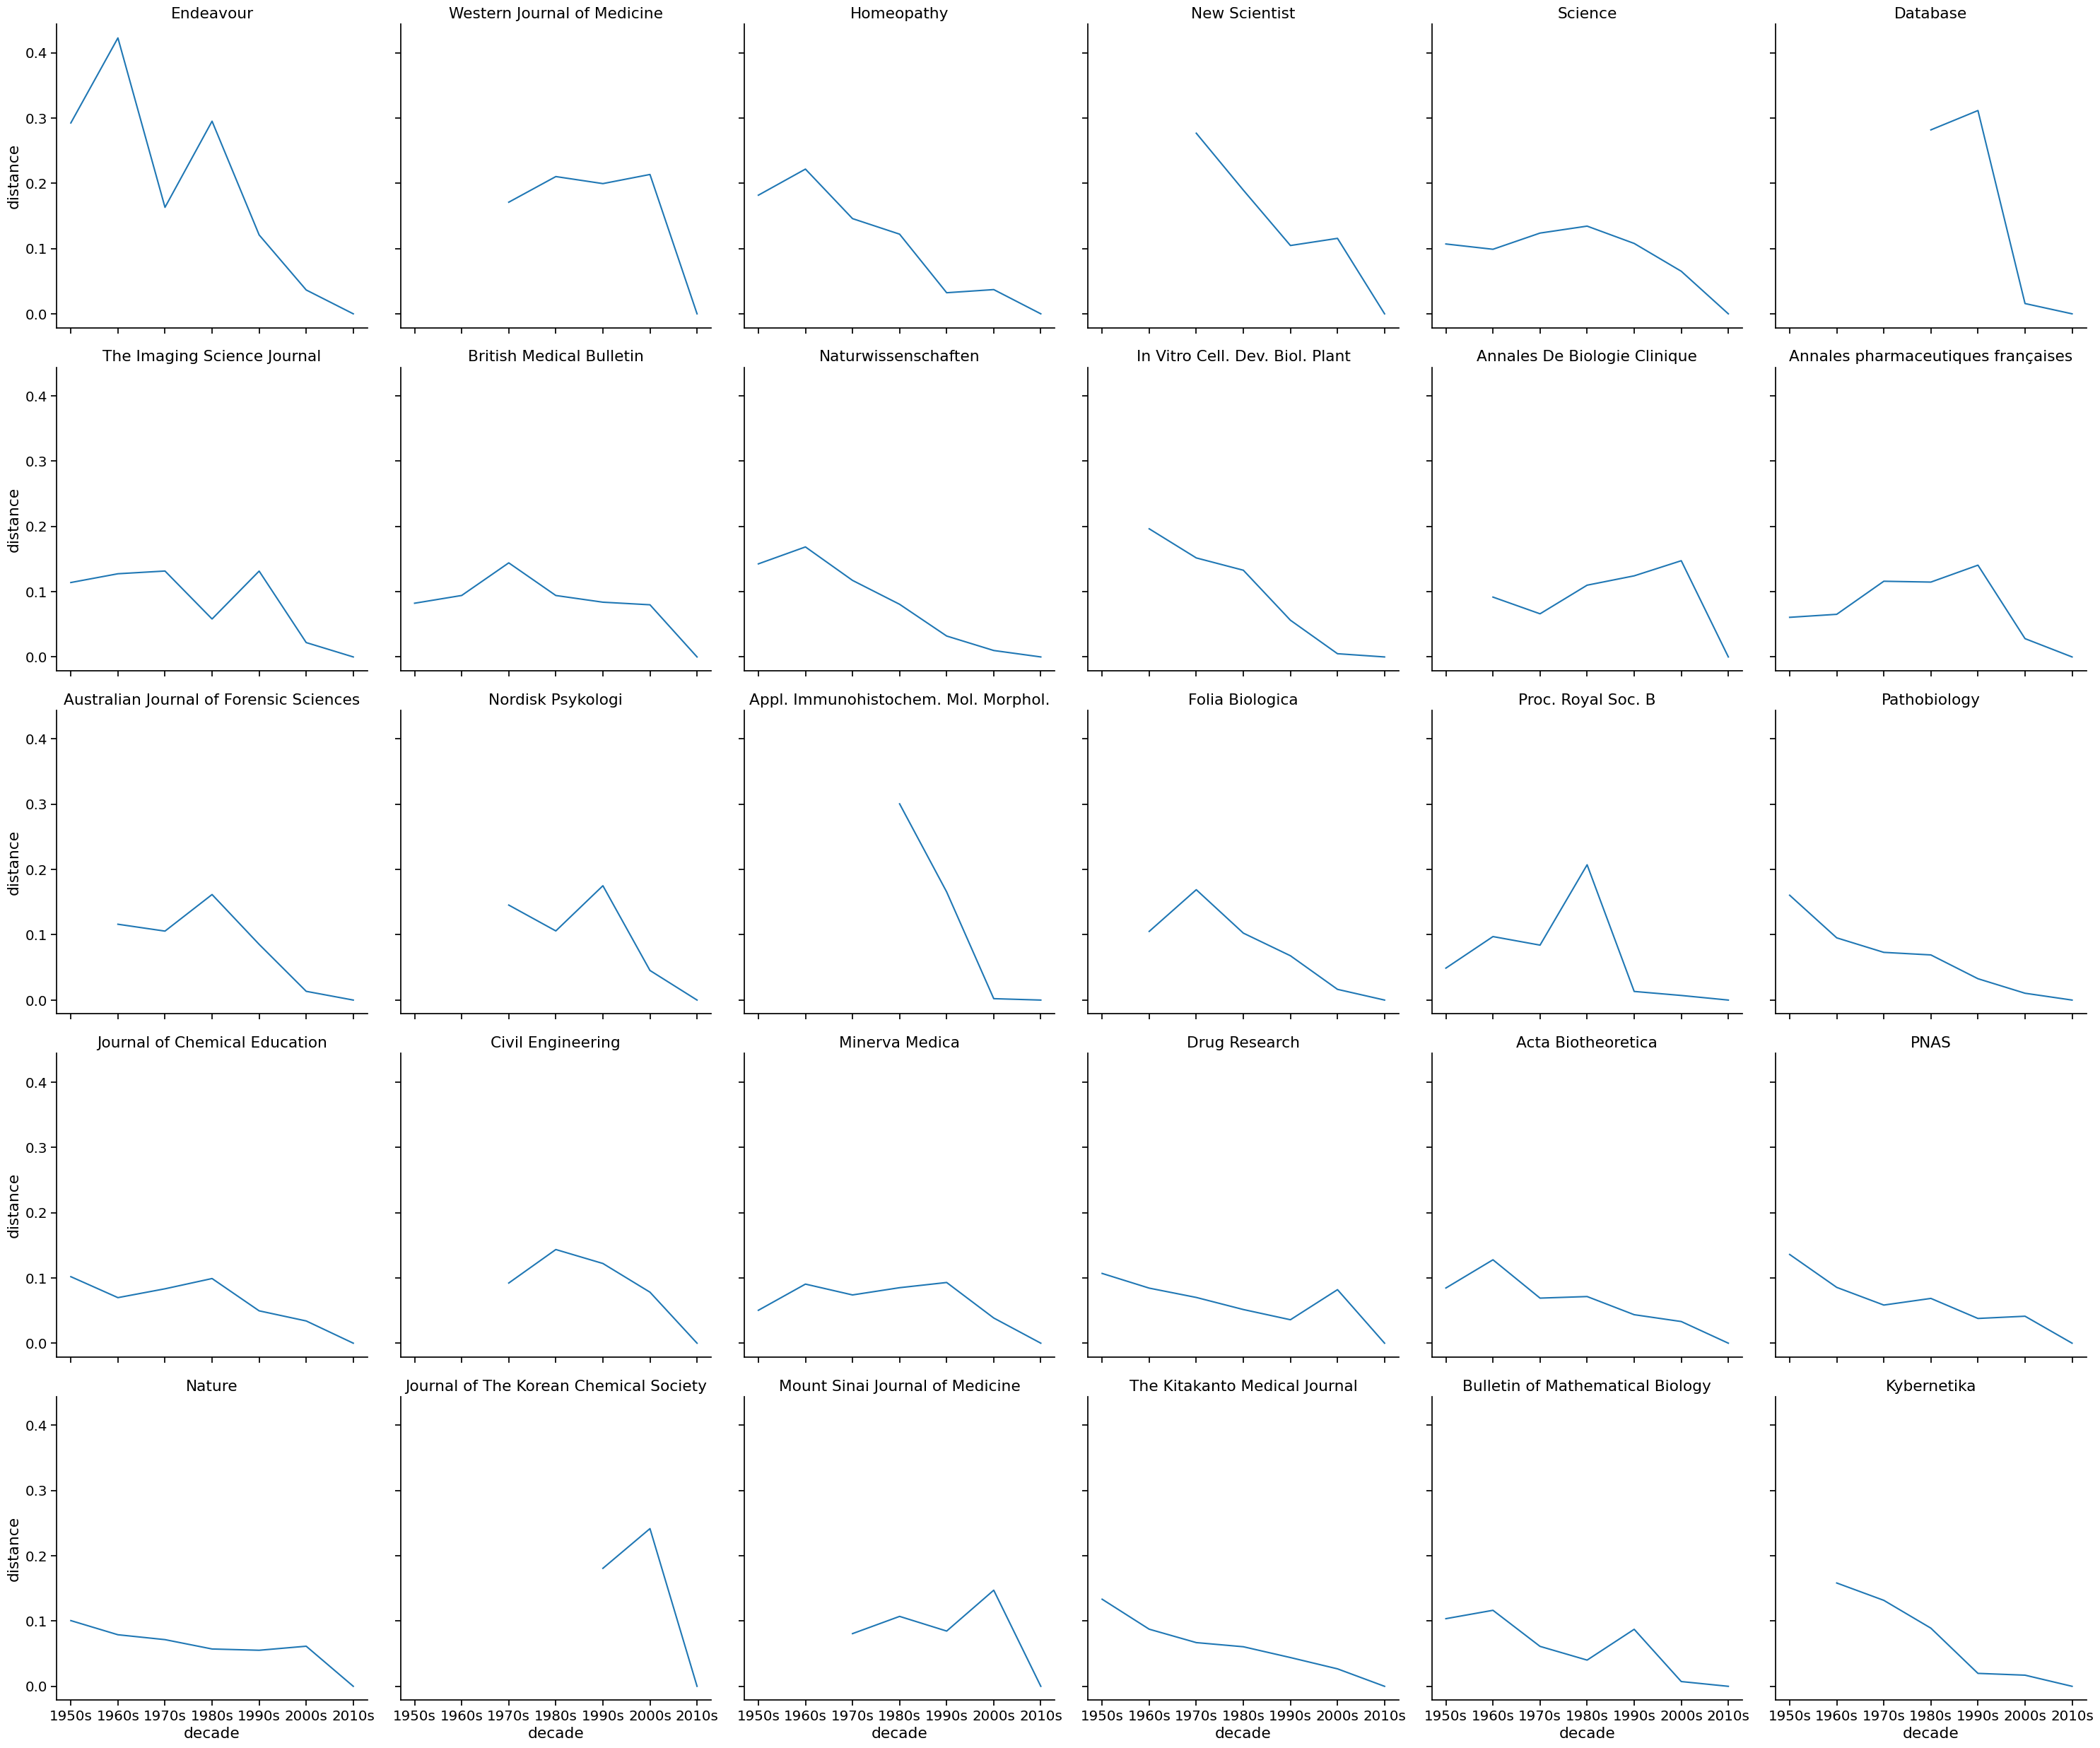

In [138]:
neighbor_dist_df_rename = neighbor_dist_df.copy()
neighbor_dist_df_rename.venue_name = neighbor_dist_df_rename.venue_name.replace({'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
                                                                         'Philosophical Transactions of the Royal Society A':'Philos. Trans. Royal Soc. A',
                                                                         'Philosophical Transactions of the Royal Society B':'Philos. Trans. Royal Soc. B',
                                                                         'Proceedings of The Royal Society B: Biological Sciences': 'Proc. Royal Soc. B',
                                                                         'International Journal on Disability and Human Development': 'Int J Disabil Hum Dev',
                                                                         'Tel Aviv: Journal of The Institute of Archaeology of Tel Aviv University': 'Tel Aviv',
                                                                         'Journal of Huazhong University of Science and Technology': 'J. Huazhong Univ. Sci. Technol. Med. Sci.',
                                                                         'Wiley Interdisciplinary Reviews: Computational Statistics':'WIREs Comp Stats',
                                                                         'International Journal of Pharmaceutical Medicine': 'Int. J. Pharm.',
                                                                         'Periodica Polytechnica Chemical Engineering': 'Period. Polytech. Chem. Eng.',
                                                                         'In Vitro Cellular & Developmental Biology – Plant': 'In Vitro Cell. Dev. Biol. Plant',
                                                                         'Applied Immunohistochemistry & Molecular Morphology': 'Appl. Immunohistochem. Mol. Morphol.',
                                                                         'Scandinavian Journal of Plastic and Reconstructive Surgery and Hand Surgery':'Scand J Plast Reconstr Surg Hand Surg Suppl'
                                                                        })

neighbor_dist_df_wide = pd.wide_to_long(neighbor_dist_df_rename,
                                    stubnames=['neighbor_distance'],
                                    suffix='.+',
                                    sep='_',
                                    i = ['VID', 'venue_name'],
                                    j = 'decade')

periodical_list = neighbor_dist_df_rename.sort_values(by=metrics, ascending=False).head(30).venue_name.to_list()

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(data=neighbor_dist_df_wide,
                     x='decade', y='neighbor_distance',
                     legend=False,
                     col='venue_name', col_wrap=6, 
                     col_order=periodical_list,
                     kind='line')

    g.set_titles("{col_name}")
    g.set_ylabels('distance')

In [ ]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
g.savefig('/media/sdb/p2v/figs/test.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# 1.4 Aggregate on discipline level

/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1920x1440 with 0 Axes>

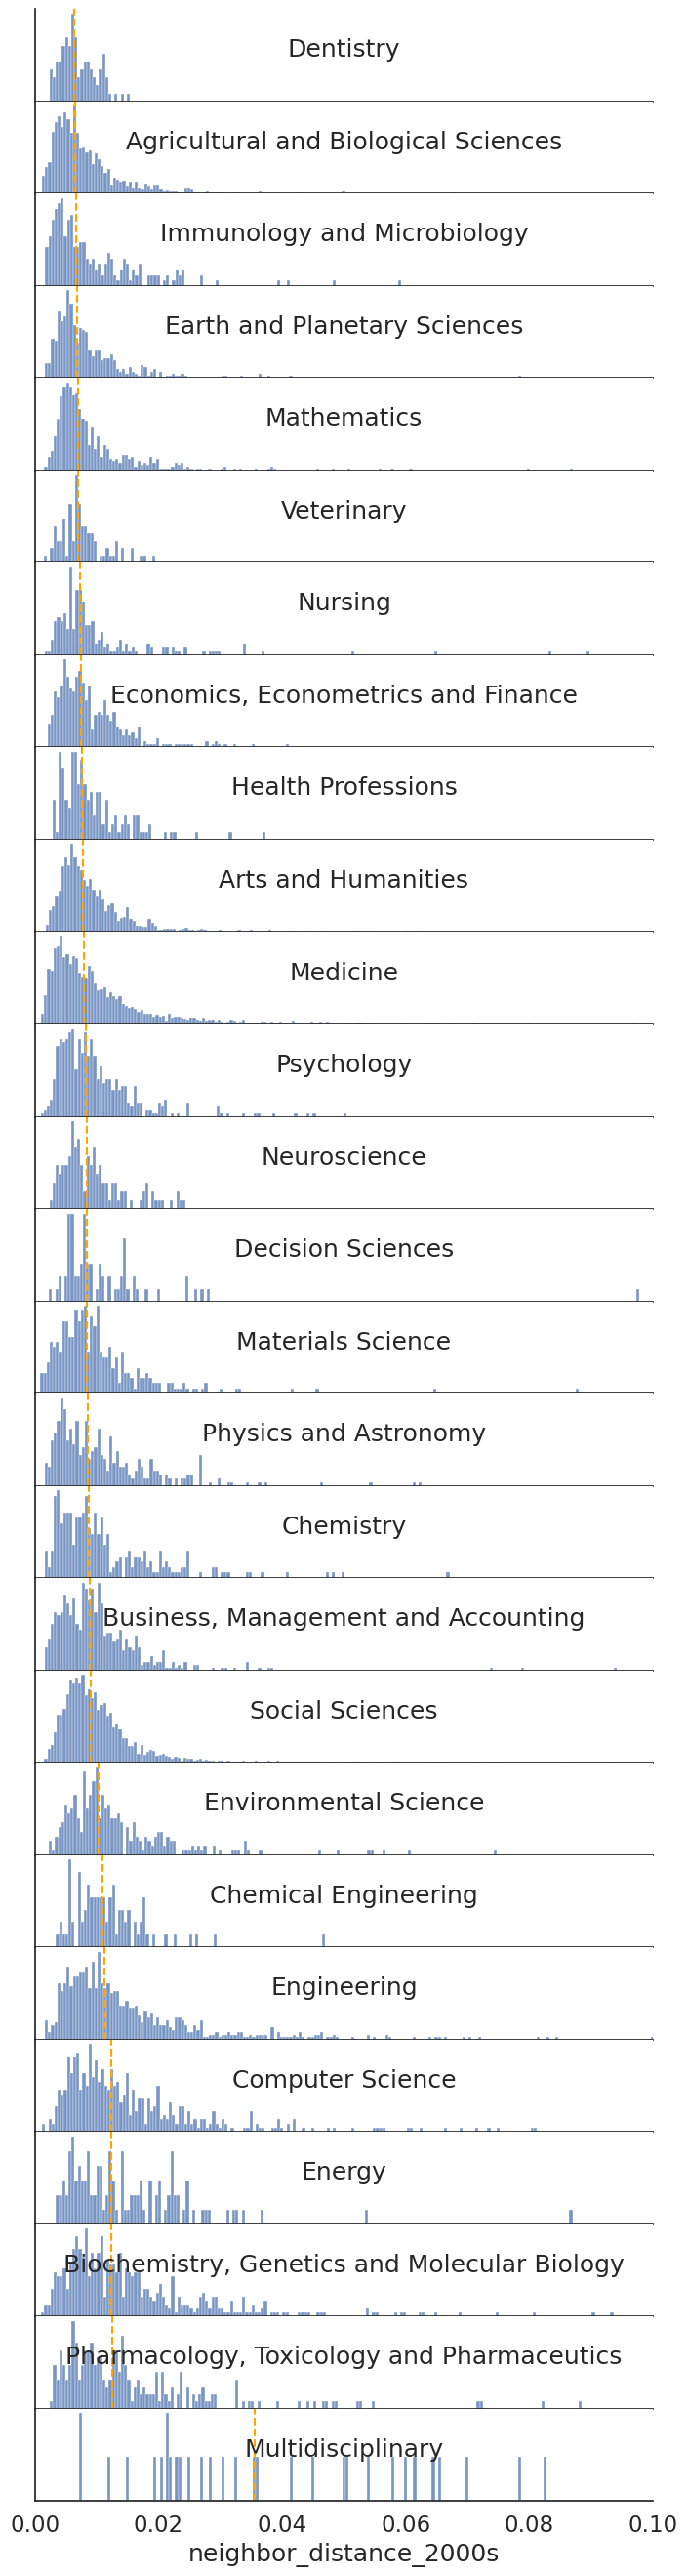

In [337]:
col_name = 'neighbor_distance_2000s'

def plot_median(x, **kwargs):
    plt.axvline(x.median(), c='orange', ls='--', lw=1.5)
    
plt.figure(dpi=300)
sns.set(style='white', font_scale=1.5)
g = sns.FacetGrid(data=neighbor_dist_df, col='scopus_label', 
                  col_wrap=1, aspect=8, height=1.0, xlim=(0.0, 0.1), sharey=False,
                  col_order=neighbor_dist_df.groupby('scopus_label').agg({col_name:'median'}).sort_values(by=col_name).index.to_list()
                 )
g.map(sns.histplot, col_name, stat='density', binwidth=0.0005, edgecolor=None)
g.map(plot_median, col_name)
g.set_titles(col_template='{col_name}',row_template=" ", x=0.5, y=0.4)
g.figure.subplots_adjust(wspace=0, hspace=0)
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_yticks([])
plt.show()

In [ ]:
neighbor_dist_df_wide = pd.wide_to_long(neighbor_dist_df,
                             stubnames=['neighbor_distance'],
                             suffix='.+',
                             sep='_',
                             i = ['VID', 'venue_name'],
                             j = 'decade')

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    ax = sns.relplot(data=neighbor_dist_df_wide,
                     x='decade', y='neighbor_distance',
                     markers=True, dashes=False, style='scopus_label', hue='scopus_label', palette=model.discipline2color,
                     legend=False,
                     col='scopus_label', col_wrap=8, 
                     col_order=['Medicine', 'Social Sciences', 'Arts and Humanities',
                                'Agricultural and Biological Sciences', 'Engineering', 'Mathematics',
                                'Biochemistry, Genetics and Molecular Biology',
                                'Business, Management and Accounting', 'Computer Science',
                                'Earth and Planetary Sciences', 'Economics, Econometrics and Finance',
                                'Psychology', 'Physics and Astronomy', 'Materials Science',
                                'Environmental Science', 'Chemistry',
                                'Pharmacology, Toxicology and Pharmaceutics',
                                'Immunology and Microbiology', 'Nursing', 'Health Professions',
                                'Energy', 'Neuroscience', 'Dentistry', 'Chemical Engineering',
                                'Veterinary', 'Decision Sciences', 'Multidisciplinary'],
                     kind='line')
    ax.set_titles("{col_name}")
    ax.set_ylabels('distance')

In [ ]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
ax.savefig('/media/sdb/p2v/figs/27_discipline_semantic_change.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# A cell to plot single periodical

In [ ]:
neighbor_dist_df_rename = neighbor_dist_df.copy()
neighbor_dist_df_rename.venue_name = neighbor_dist_df_rename.venue_name.replace({'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
                                                                                 'Philosophical Transactions of the Royal Society A':'Philos. Trans. Royal Soc. A',
                                                                                 'Philosophical Transactions of the Royal Society B':'Philos. Trans. Royal Soc. B',
                                                                                 'Proceedings of The Royal Society B: Biological Sciences': 'Proc. Royal Soc. B',
                                         })

neighbor_dist_df_wide = pd.wide_to_long(neighbor_dist_df_rename,
                                        stubnames=['neighbor_distance'],
                                        suffix='.+',
                                        sep='_',
                                        i = ['VID', 'venue_name'],
                                        j = 'decade')

periodical_list = ['British Medical Bulletin']

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(data=neighbor_dist_df_wide,
                     x='decade', y='neighbor_distance',
                     legend=False,
                     col='venue_name', col_wrap=6, 
                     col_order=periodical_list,
                     kind='line')

    g.set_titles("{col_name}")
    g.set_ylabels('distance')

# 2. Calculate change between every decade and its previous decade

# 2.1 Using cosine similarity

In [6]:
start_year_list = ['1950', '1960', '1970', '1980', '1990', '2000', '2010']
end_year_list = ['1959', '1969', '1979', '1989', '1999', '2009', '2021']

cs_df = pd.DataFrame(columns=['VID'])
for i in range(1, 7):
    tar_start_year = start_year_list[i]
    tar_end_year = end_year_list[i]
    ref_start_year = start_year_list[i-1]
    ref_end_year = end_year_list[i-1]
    print("-----------------------")
    prinT("start comparing {start_year}-{end_year} with the reference decade".format(start_year=tar_start_year, end_year=tar_end_year))

    tar_wv = model.load_wv(tar_start_year, tar_end_year, 100, 10)
    ref_wv = model.load_wv(ref_start_year, ref_end_year, 100, 10)
    
    tar_VIDs = tar_wv.index_to_key
    ref_VIDs = ref_wv.index_to_key
    shared_VIDs = list(set(tar_VIDs) & set(ref_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    tar_idx = [tar_wv.get_index(VID) for VID in shared_VIDs]
    ref_idx = [ref_wv.get_index(VID) for VID in shared_VIDs]
    
    tar_vectors = tar_wv.get_normed_vectors()[tar_idx]
    ref_vectors = ref_wv.get_normed_vectors()[ref_idx]
    
    prinT("start aligning...")
    R, sca = orthogonal_procrustes(tar_vectors, ref_vectors)
    aligned_tar_vectors = np.dot(tar_vectors, R)
    prinT("finish. start compute cosine change...")
    cs = np.diagonal(cosine_similarity(aligned_tar_vectors, ref_vectors))
    prinT("finish")

    tar_cs_df = pd.DataFrame({'VID': shared_VIDs,
                              'cosine_similarity_'+tar_start_year+'s': cs})
    cs_df = cs_df.merge(tar_cs_df,
                        on='VID',
                        how='outer')
cs_df.loc[:,'venue_name'] = cs_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
VID_labele_dict = model.load_VID_labeled(ref_start_year, ref_end_year, 100, 10)
cs_df['scopus_label'] = cs_df.VID.map(lambda x: 
                                          VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                          else np.nan)

-----------------------
2023-08-07 11:36:08 -- start comparing 1960-1969 with the reference decade
2023-08-07 11:36:08 -- start loading word vectors...
2023-08-07 11:36:08 -- word vectors loaded, and its shape is: (3186, 100)
2023-08-07 11:36:08 -- start loading word vectors...
2023-08-07 11:36:08 -- word vectors loaded, and its shape is: (1683, 100)
2023-08-07 11:36:08 -- the number of shared VIDs between this two decades: 1530
2023-08-07 11:36:08 -- start aligning...
2023-08-07 11:36:08 -- finish. start compute cosine similarity...
2023-08-07 11:36:08 -- finish
-----------------------
2023-08-07 11:36:08 -- start comparing 1970-1979 with the reference decade
2023-08-07 11:36:08 -- start loading word vectors...
2023-08-07 11:36:08 -- word vectors loaded, and its shape is: (5761, 100)
2023-08-07 11:36:08 -- start loading word vectors...
2023-08-07 11:36:08 -- word vectors loaded, and its shape is: (3186, 100)
2023-08-07 11:36:08 -- the number of shared VIDs between this two decades: 28

In [321]:
cs_df

,VID,cosine_similarity_1950s,cosine_similarity_1960s,cosine_similarity_1970s,cosine_similarity_1980s,cosine_similarity_1990s,cosine_similarity_2000s,venue_name,scopus_label
0,1.479803e+08,0.536453,NaN,NaN,0.466951,0.386582,0.759120,Bulletin De L Academie Nationale De Medecine,Medicine
1,2.785285e+06,0.694030,0.746864,0.743407,0.810143,0.766487,0.821322,The Journal of Comparative Neurology,Neuroscience
2,1.241662e+08,0.657591,0.641123,0.672203,0.579373,0.709564,0.707039,Quarterly Journal of Mechanics and Applied Mathematics,Mathematics
3,2.756444e+09,0.607243,0.606009,0.473114,0.496372,0.442619,0.261401,Advances in internal medicine,NaN
4,1.709670e+08,0.527496,0.429602,0.612468,0.744073,0.726447,0.807329,American Journal of Epidemiology,Medicine
...,...,...,...,...,...,...,...,...,...
24654,2.764439e+09,NaN,NaN,NaN,NaN,NaN,0.719071,Bulgarian Journal of Veterinary Medicine,Veterinary
24655,2.898526e+09,NaN,NaN,NaN,NaN,NaN,0.664372,EMC - AKOS - Trattato di Medicina,NaN
24656,2.010644e+08,NaN,NaN,NaN,NaN,NaN,0.824514,European Journal of Preventive Cardiology,Medicine
24657,1.125908e+08,NaN,NaN,NaN,NaN,NaN,0.726251,Journal of Transport and Land Use,Social Sciences


In [14]:
cs_df['mean_cosine_similarity'] = cs_df.drop(['VID'], axis = 1).mean(axis=1, numeric_only=True)

In [18]:
cs_df[~(cs_df['cosine_similarity_1960s'].isna() | cs_df['scopus_label'].isna())].sort_values(by='mean_cosine_similarity').head(5)

,VID,cosine_similarity_1960s,cosine_similarity_1970s,cosine_similarity_1980s,cosine_similarity_1990s,cosine_similarity_2000s,cosine_similarity_2010s,venue_name,scopus_label,mean_cosine_similarity
1272,203291325.0,0.386589,0.259798,0.475639,0.464099,0.481302,0.321417,American Scientist,Multidisciplinary,0.398140
54,65315170.0,0.386006,0.423142,0.343308,0.434169,0.374105,0.516077,Endeavour,Arts and Humanities,0.412801
17,169320561.0,0.453169,0.571671,0.450756,0.534741,0.322900,0.350789,Scientia Forestalis,Agricultural and Biological Sciences,0.447338
141,196862746.0,0.499373,0.508247,0.475523,0.420283,0.373590,0.439096,Biographical Memoirs of Fellows of the Royal Society,Medicine,0.452685
282,4310451.0,0.433791,0.462982,0.544392,0.382973,0.556032,0.606499,Homeopathy,Medicine,0.497778


In [104]:
cs_df[~cs_df['scopus_label'].isna()].sort_values(by=['cosine_similarity_1960s']).head(20)[['venue_name','scopus_label']]

,venue_name,scopus_label
54,Endeavour,Arts and Humanities
1272,American Scientist,Multidisciplinary
1383,Studies in Conservation,Arts and Humanities
282,Homeopathy,Medicine
17,Scientia Forestalis,Agricultural and Biological Sciences
665,Perspectives in Biology and Medicine,Medicine
788,Annual Review of Physiology,"Biochemistry, Genetics and Molecular Biology"
141,Biographical Memoirs of Fellows of the Royal Society,Medicine
184,Bulletin of Mathematical Biology,"Biochemistry, Genetics and Molecular Biology"
1020,Journal of The Franklin Institute-engineering and Applied Mathematics,Engineering


In [12]:
pd.wide_to_long(cs_df,
                stubnames=['cosine_similarity'],
                suffix='.+',
                sep='_',
                i = ['VID', 'venue_name', 'scopus_label'],
                j = 'decade')

cosine_similarity
VID          venue_name                                             scopus_label decade                      
1.479803e+08 Bulletin De L Academie Nationale De Medecine           Medicine     1950-1959           0.536453
                                                                                 1960-1969                NaN
                                                                                 1970-1979                NaN
                                                                                 1980-1989           0.466951
                                                                                 1990-1999           0.386582
...                                                                                                       ...
2.898264e+09 international conference service robotics technologies NaN          1970-1979                NaN
                                                                                 1980-1989                NaN
                                                                                 1990-1999                NaN
                                                                                 2000-2009                NaN
                                                                                 2010-2021           1.000000

[263753 rows x 1 columns]

<Figure size 1800x1200 with 0 Axes>

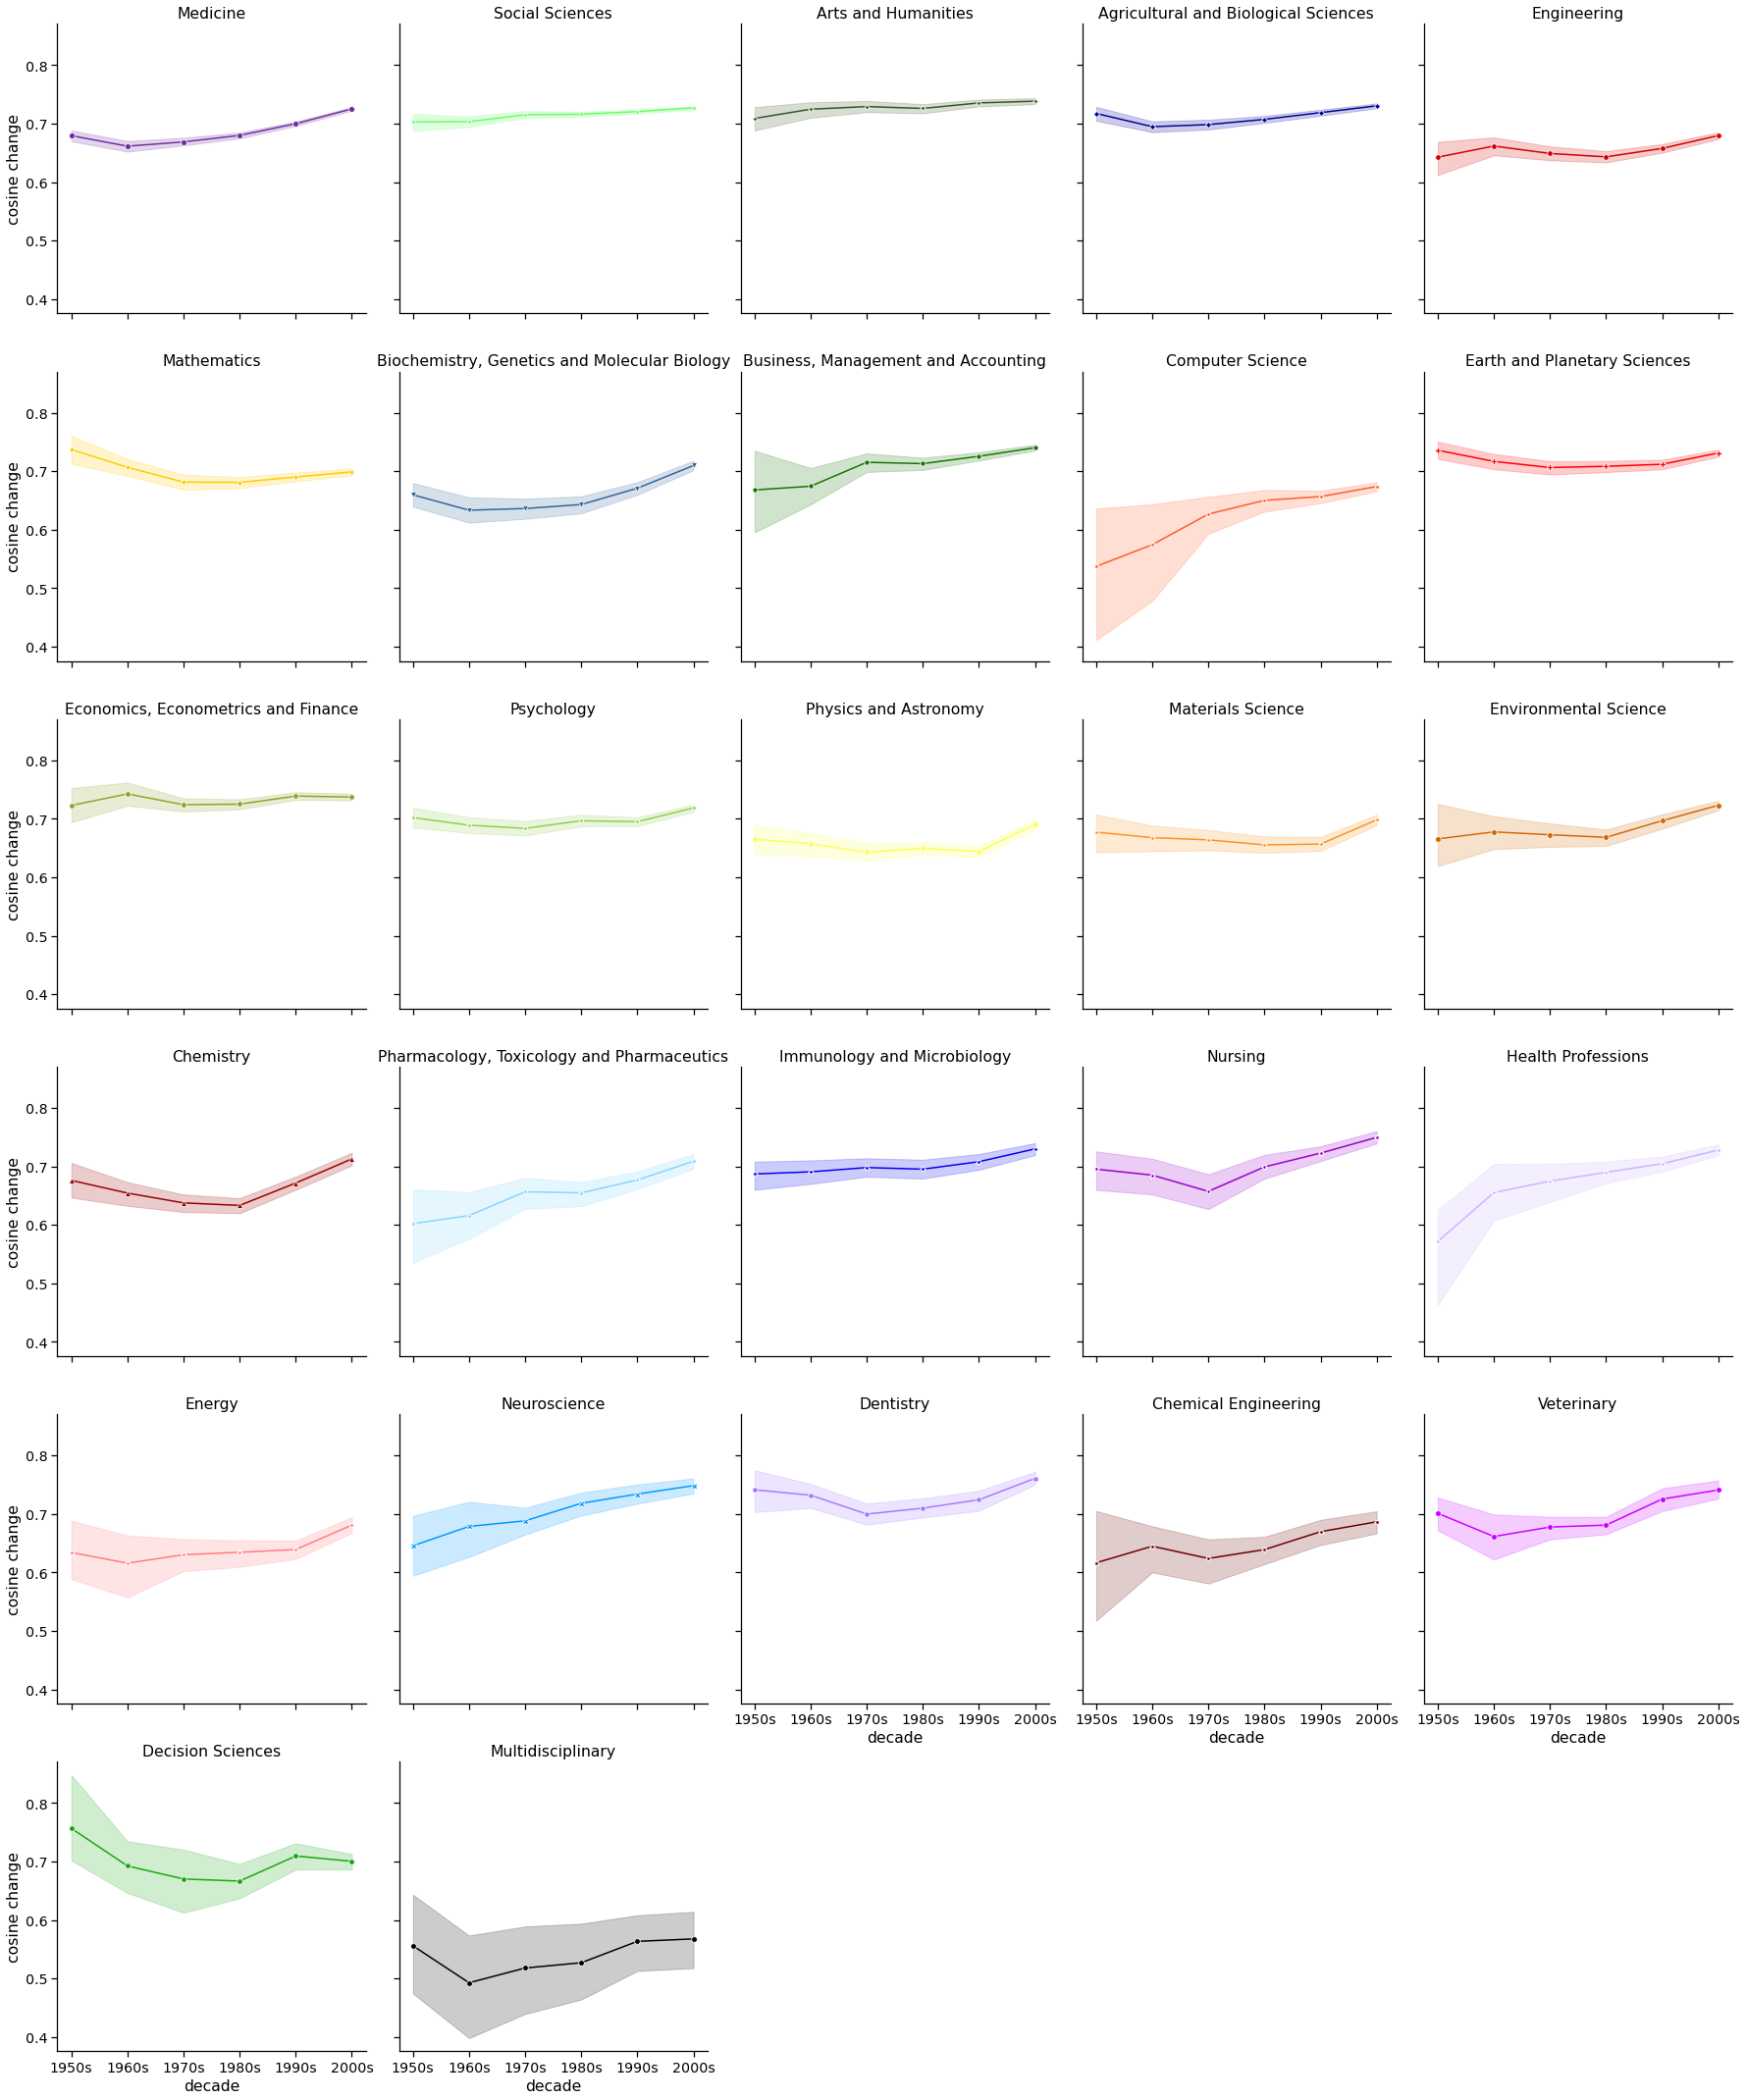

In [322]:
cs_df_wide = pd.wide_to_long(cs_df,
                             stubnames=['cosine_similarity'],
                             suffix='.+',
                             sep='_',
                             i = ['VID', 'venue_name'],
                             j = 'decade')

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    ax = sns.relplot(data=cs_df_wide,
                     x='decade', y='cosine_similarity',
                     markers=True, dashes=False, style='scopus_label', hue='scopus_label', palette=model.discipline2color,
                     legend=False,
                     col='scopus_label', col_wrap=5, 
                     col_order=['Medicine', 'Social Sciences', 'Arts and Humanities',
                                'Agricultural and Biological Sciences', 'Engineering', 'Mathematics',
                                'Biochemistry, Genetics and Molecular Biology',
                                'Business, Management and Accounting', 'Computer Science',
                                'Earth and Planetary Sciences', 'Economics, Econometrics and Finance',
                                'Psychology', 'Physics and Astronomy', 'Materials Science',
                                'Environmental Science', 'Chemistry',
                                'Pharmacology, Toxicology and Pharmaceutics',
                                'Immunology and Microbiology', 'Nursing', 'Health Professions',
                                'Energy', 'Neuroscience', 'Dentistry', 'Chemical Engineering',
                                'Veterinary', 'Decision Sciences', 'Multidisciplinary'],
                     kind='line')
    ax.set_titles("{col_name}")
    ax.set_ylabels('cosine change')
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
ax.savefig('/media/sdb/p2v/figs/28_discipline_semantic_change.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# 3. Using change point detection

In [8]:
def get_z_score_dict(dist_dict):
    """
    Convert the dictionary of distance scores for a given timestep into a dictionary of z-scores - i.e. how many standard deviations is a given word's distance score from the mean of all word's distance scores at this timestep?
    """

    # calculate mean and variance of change scores, ignoring any words for whom the value was None -- calculate the mean and variance of the change scores for all words which are represented in both the current timestep's model and the comparison reference model.
    mean = np.mean(list(dist_dict.values()))
    var = np.var(list(dist_dict.values()))

    z_score_dict = {}
    for VID in dist_dict:
        if var == 0:
            z_score_dict[VID] = 0
        else:
            z_score_dict[VID] = (dist_dict[VID] - mean) / np.sqrt(var)

    return z_score_dict

def compute_mean_shift(time_series_dict, j, compare_to):
	"""
	Compute the mean_shift score at index j of the given time-series.
	"""

	timestep_to_index = {}
	for (i,timestep) in enumerate(sorted(time_series_dict.keys())):
		timestep_to_index[timestep] = i

	xs = list(itertools.chain.from_iterable([timestep_to_index[timestep]]*len(time_series_dict[timestep]) for timestep in time_series_dict))
	ys = list(itertools.chain.from_iterable(time_series_dict.values()))

	
	if compare_to == 'first':
		return np.mean([ys[i] for i in range(len(ys)) if xs[i] > j])  - np.mean([ys[i] for i in range(len(ys)) if xs[i] <= j])
	else: # compare_to == 'last' or compare_to == 'previous':
		return np.mean([ys[i] for i in range(len(ys)) if xs[i] <= j])  - np.mean([ys[i] for i in range(len(ys)) if xs[i] > j])


def get_mean_shift_series(time_series_dict, compare_to):
	"""
	Compute a given word's mean_shift time-series from its time-series of z-scores. 
	"""
	return [compute_mean_shift(time_series_dict, j, compare_to) for j in range(len(time_series_dict.keys())-1)]


def get_p_value_series(word, mean_shift_series, n_samples, z_scores_dict, compare_to):
	"""
	Randomly permute the z-score time series n_samples times, and for each
	permutation, compute the mean-shift time-series of those permuted z-scores, and at each index, check if the mean-shift score from the permuted series is greater than the mean-shift score from the original series. The p-value is the proportion of randomly permuted series which yielded a mean-shift score greater than the original mean-shift score.
	"""
	p_value_series = np.zeros(len(mean_shift_series))
	for i in range(n_samples):
		permuted_z_score_series = np.random.permutation(list(z_scores_dict.values()))
		permuted_z_scores_dict = {}
		for (i,z_scores) in enumerate(permuted_z_score_series):
			permuted_z_scores_dict[i] = z_scores
		mean_shift_permuted_series = get_mean_shift_series(permuted_z_scores_dict, compare_to)

		for x in range(len(mean_shift_permuted_series)):
			if mean_shift_permuted_series[x] > mean_shift_series[x]:
				p_value_series[x] += 1
	p_value_series /= n_samples
	return p_value_series


def detect_change_point(word, z_scores_dict, n_samples, p_value_threshold, gamma_threshold, compare_to):
	"""
	This function computes the mean-shift time-series from the given word's z-score series, then computes the p-value series, 
	"""

	index_to_timestep = {}
	for (i,timestep) in enumerate(sorted(z_scores_dict.keys())):
		index_to_timestep[i] = timestep

	mean_shift_series = get_mean_shift_series(z_scores_dict, compare_to)
	p_value_series = get_p_value_series(word, mean_shift_series, n_samples, z_scores_dict, compare_to)

	# set p-values for any time-slices with average z-scores below gamma threshold to 1, so that these time-slices won't get chosen. 
	for i in range(len(p_value_series)):
		if np.mean(z_scores_dict[index_to_timestep[i]]) < gamma_threshold:
			p_value_series[i] = 1

	# find minimum p_value:
	p_value_series = np.array(p_value_series)
	try:
		min_p_val = p_value_series.min()
	except ValueError:
		print(word)
		print(z_scores_dict)
		print(mean_shift_series)
		print(p_value_series)
    
	# if minimum p_value is below the threshold:
	if min_p_val < p_value_threshold:

		# get indices of time-slices with minimum p_value:
		indices = np.where(p_value_series == min_p_val)[0]

		# as a tie-breaker, return the one which corresponds to the biggest mean_shift
		(change_point, mean_shift) = max([(i, mean_shift_series[i]) for i in indices], key = lambda x:x[1])

		z_score = np.mean(z_scores_dict[index_to_timestep[change_point]])
		time_slice_label = index_to_timestep[change_point]
        
		return (word, time_slice_label, min_p_val, mean_shift, z_score)

	else: 
		return None


def get_word_change_point(tup):
	(word, sim_dict) = tup

	change_point = detect_change_point(word, sim_dict, 
                                       n_samples, p_value_threshold, gamma_threshold, compare_to)
	if change_point:
		return change_point

In [53]:
decade_list = ['1950s',
               '1960s',	
               '1970s',	
               '1980s',	
               '1990s',	
               '2000s']

dist_df = neighbor_dist_df.copy()
dist_df = dist_df.rename(columns={"neighbor_distance_1950s": "1950s", 
                                  "neighbor_distance_1960s": "1960s",
                                  "neighbor_distance_1970s": "1970s",
                                  "neighbor_distance_1980s": "1980s",
                                  "neighbor_distance_1990s": "1990s",
                                  "neighbor_distance_2000s": "2000s"
                                  })
dist_df.set_index('venue_name', inplace=True)

# indicate the fisrt decade to start
i = 0
dict_of_dist_dicts = dist_df[decade_list[i:]].dropna().to_dict()

In [ ]:
dict_of_z_score_dicts = {}
for t in decade_list[i:]:
    if t in dict_of_dist_dicts:
        dict_of_z_score_dicts[t] = get_z_score_dict(dict_of_dist_dicts[t])

dict_of_dist_by_word = defaultdict(lambda: defaultdict(list))
for time_slice in dict_of_dist_dicts:
    for word in dict_of_dist_dicts[time_slice].keys():
        dict_of_dist_by_word[word][time_slice].append(dict_of_dist_dicts[time_slice][word])

dict_of_z_scores_by_word = defaultdict(lambda: defaultdict(list))
for time_slice in dict_of_z_score_dicts:
    for word in dict_of_z_score_dicts[time_slice].keys():
        dict_of_z_scores_by_word[word][time_slice].append(dict_of_z_score_dicts[time_slice][word])

In [358]:
len(dict_of_dist_by_word)

1153

In [ ]:
n_samples = 1000
p_value_threshold = 0.05
gamma_threshold = 0
compare_to = 'last'

In [194]:
# no standardization

pool = multiprocessing.Pool()
results = pool.map(get_word_change_point, dict_of_dist_by_word.items())
results = [r for r in results if r]

pool.close()
pool.join()

# ranked by mean-shift score first, then by p-value
sorted_results = sorted(results, key=lambda x:-x[3])
sorted_results = sorted(sorted_results, key=lambda x:x[2])

In [197]:
# with standardization

pool = multiprocessing.Pool()
results = pool.map(get_word_change_point, dict_of_z_scores_by_word.items())
results = [r for r in results if r]

pool.close()
pool.join()

# ranked by mean-shift score first, then by p-value
sorted_results = sorted(results, key=lambda x:-x[3])
sorted_results = sorted(sorted_results, key=lambda x:x[2])

In [198]:
cp_df = pd.DataFrame.from_records(sorted_results, columns =['venue_name', 
                                                            'change_point', 
                                                            'p_value', 
                                                            'mean_shift_score', 
                                                            'z_score'])

In [ ]:
cp_df.head(20)

In [18]:
def get_neighbor(venue_name):
    VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
    tup_list = current_wv.most_similar(positive=VID, topn=3)
    VID_list = [tup[0] for tup in tup_list]
    return [model.MAG_venue_info_df.at[VID, 'OriginalVenue'] for VID in VID_list]

top20_df = cp_df.head(20).copy()

for i in range(0, 7):
    current_wv = model.load_wv(start_year_list[i], end_year_list[i], 100, 10)
    top20_df['neighbor_'+start_year_list[i]+'s'] = top20_df['venue_name'].parallel_apply(get_neighbor)
    

2023-09-04 09:27:16 -- start loading word vectors...
2023-09-04 09:27:16 -- word vectors loaded, and its shape is: (701, 100)
2023-09-04 09:27:17 -- start loading word vectors...
2023-09-04 09:27:17 -- word vectors loaded, and its shape is: (1499, 100)
2023-09-04 09:27:18 -- start loading word vectors...
2023-09-04 09:27:18 -- word vectors loaded, and its shape is: (2942, 100)
2023-09-04 09:27:18 -- start loading word vectors...
2023-09-04 09:27:18 -- word vectors loaded, and its shape is: (5241, 100)
2023-09-04 09:27:19 -- start loading word vectors...
2023-09-04 09:27:19 -- word vectors loaded, and its shape is: (9021, 100)
2023-09-04 09:27:20 -- start loading word vectors...
2023-09-04 09:27:20 -- word vectors loaded, and its shape is: (16449, 100)
2023-09-04 09:27:21 -- start loading word vectors...
2023-09-04 09:27:21 -- word vectors loaded, and its shape is: (26968, 100)


In [19]:
top20_df

,venue_name,change_point,p_value,mean_shift_score,z_score,neighbor_1950s,neighbor_1960s,neighbor_1970s,neighbor_1980s,neighbor_1990s,neighbor_2000s,neighbor_2010s
0,British Medical Bulletin,2000s,0.0,4.416168,7.193458,"[Experimental Physiology, Clinical Science, The Practitioner]","[Experimental Physiology, Clinical Science, Presse Medicale]","[Transactions of the American Neurological Association, Neurology, Advances in Neurology]","[East African Medical Journal, The Lancet, Annals of clinical research]","[The Lancet, The Japanese journal of experimental medicine, BMJ]","[The Lancet, Tidsskrift for Den Norske Laegeforening, South African Medical Journal]","[Revista Chilena de Ortopedia y Traumatología, Medicina-buenos Aires, BMC Medicine]"
1,Proceedings of the National Academy of Sciences of the United States of America,1950s,0.0,4.044555,5.363306,"[Annals of Mathematics, Nagoya Mathematical Journal, Journal D Analyse Mathematique]","[Progress in Nucleic Acid Research and Molecular Biology, Journal of Molecular Biology, Michigan Mathematical Journal]","[Cold Spring Harbor Symposia on Quantitative Biology, Biochemical and Biophysical Research Communications, Journal of Biological Chemistry]","[Cold Spring Harbor Symposia on Quantitative Biology, The EMBO Journal, Cell]","[The EMBO Journal, Cell, Journal of Biological Chemistry]","[PLOS Biology, PLOS ONE, Nature]","[Science Advances, Science, Nature Communications]"
2,Zeitschrift für Naturforschung B,1970s,0.0,3.608512,3.497999,"[Biological Chemistry, Zeitschrift für Physikalische Chemie, Journal of Biochemistry]","[Journal of the American Chemical Society, Biological Chemistry, Macromolecular Chemistry and Physics]","[Zeitschrift für Naturforschung C, Journal of the American Chemical Society, Acta Chemica Scandinavica]","[Inorganic Chemistry, Angewandte Chemie, Zeitschrift für Naturforschung C]","[Zeitschrift für anorganische und allgemeine Chemie, Angewandte Chemie, Chemische Berichte]","[Zeitschrift Fur Kristallographie-new Crystal Structures, Polish Journal of Chemistry, Helvetica Chimica Acta]","[Journal of Chemical Crystallography, Zeitschrift für anorganische und allgemeine Chemie, Zeitschrift Fur Kristallographie-new Crystal Structures]"
3,Naturwissenschaften,1990s,0.0,3.366414,1.571852,"[Angewandte Chemie, Nature, Journal of Plant Nutrition and Soil Science]","[Flora oder Allgemeine Botanische Zeitung, Angewandte Chemie, Planta Medica]","[Zeitschrift für Naturforschung C, Biologie in Unserer Zeit, Zeitschrift für Naturforschung B]","[Zeitschrift für Naturforschung C, Insectes Sociaux, Facies]","[Entomologia Generalis, Ethology Ecology & Evolution, Insectes Sociaux]","[Insectes Sociaux, Ethology Ecology & Evolution, Biology Letters]","[Biological Journal of The Linnean Society, Frontiers in Zoology, Journal of Zoology]"
4,American Journal of Epidemiology,1960s,0.0,3.235472,3.278905,"[American Journal of Tropical Medicine and Hygiene, Journal of Immunology, Bulletin of The World Health Organization]","[Acta Virologica, Journal of Immunology, A.M.A. journal of diseases of children]","[International Journal of Epidemiology, HSMHA health reports, Journal of Chronic Diseases]","[International Journal of Epidemiology, Epidemiologic Reviews, American Journal of Public Health]","[Epidemiology, International Journal of Epidemiology, Epidemiologic Reviews]","[Annals of Epidemiology, International Journal of Epidemiology, Epidemiology]","[Epidemiology, Annals of Epidemiology, European Journal of Epidemiology]"
5,International Journal of Legal Medicine,1970s,0.0,3.162425,4.763518,"[Annals of Hematology, Research in Experimental Medicine, Journal of Neurology]","[Annals of Hematology, Archiv für Psychiatrie und Nervenkrankheiten, vereinigt mit Zeitschrift für die gesamte Neurologie und Psychiatrie, Medicine Science and The Law]","[Forensic Science, Medicine Science and The Law, Journal of Forensic Sciences]","[Forensic Science International, Journal of Forensic Sciences, Medicine 

<Figure size 12000x9000 with 0 Axes>

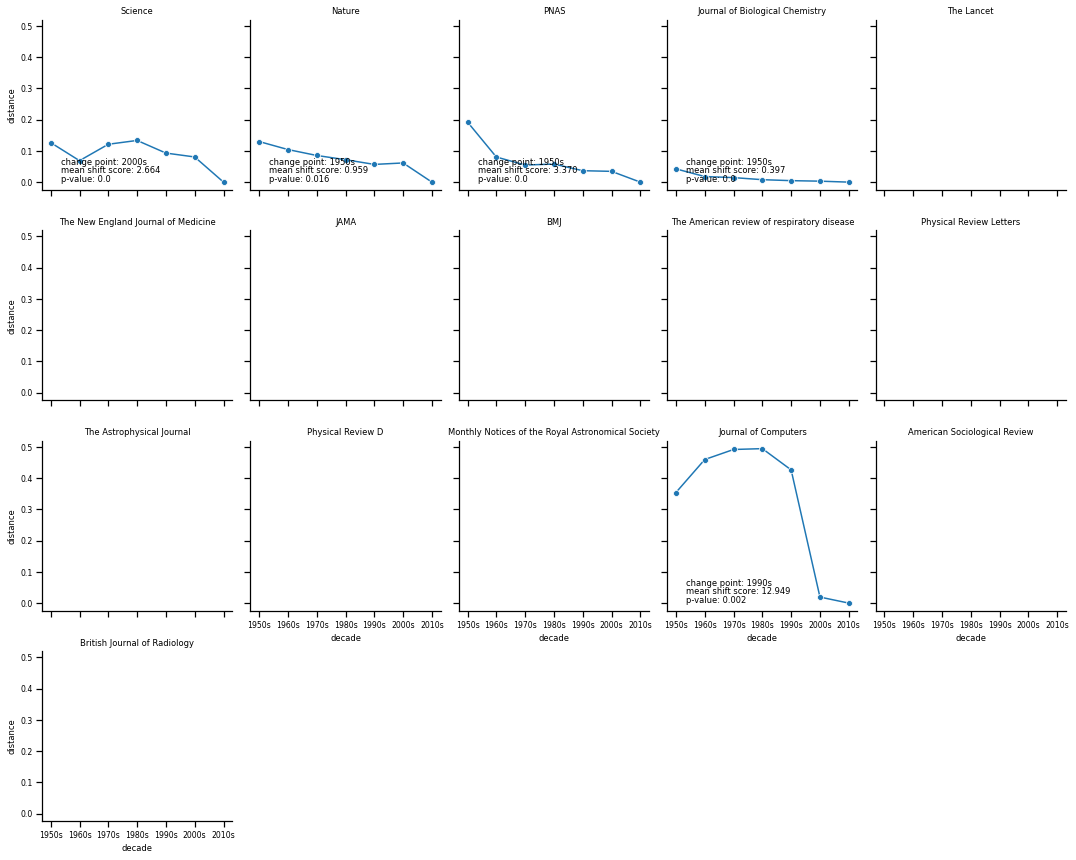

In [282]:
def annotate(data, **kws):
    change_point = data.index[0][1]
    mean_shift_score = data.index[0][2]
    p_value = data.index[0][3]
    ax = plt.gca()
    ax.text(.1, .15, f"change point: {change_point}", transform=ax.transAxes)
    ax.text(.1, .10, f"mean shift score: {format((mean_shift_score), '.3f')}", transform=ax.transAxes)
    ax.text(.1, .05, f"p-value: {p_value}", transform=ax.transAxes)

periodical_list = ['Science', 'Nature', 
                   'Proceedings of the National Academy of Sciences of the United States of America', 
                   'Journal of Biological Chemistry', 
                                
                   'The Lancet', 'The New England Journal of Medicine', 'JAMA', 'BMJ',
                   'The American review of respiratory disease',
                                
                   'Physical Review Letters', 'The Astrophysical Journal', 'Physical Review D', 
                   'Monthly Notices of the Royal Astronomical Society',

                   'American Sociological Review',
                   'British Journal of Radiology'
                  ]

overall_distance_df_wide = pd.wide_to_long(cp_df[cp_df.venue_name.isin(periodical_list)].merge(overall_distance_df[overall_distance_df.venue_name.isin(periodical_list)],
                                                    on='venue_name'
                                                   ),
                                                  stubnames=['distance'],
                                                  suffix='.+',
                                                  sep='_',
                                                  i = ['VID', 'change_point', 'mean_shift_score', 'p_value', 'z_score'],
                                                  j = 'decade')

plt.figure(figsize=(40, 30),dpi=300)
with sns.plotting_context("notebook", font_scale=0.7):
    # g = sns.relplot(data=overall_neighbor_change_df_wide,
                     # x='decade', y='local_neighborhood_change',
                     # markers=True, dashes=False, style='venue_name', hue='venue_name',
                     # legend=False,
                     # col='venue_name', col_wrap=5, 
                     # col_order=periodical_list,
                     # kind='line')
    g = sns.FacetGrid(overall_distance_df_wide, col="venue_name", col_wrap=5, col_order=periodical_list)
    g.map_dataframe(sns.lineplot, x='decade', y='distance',
                     markers=True, dashes=False, style='venue_name', hue='venue_name',
                     legend=False,)
    g.map_dataframe(annotate)
    g.set_titles("{col_name}")
    g.axes[2].set_title('PNAS')
    # ax.axes[12].set_title('ACL')
    g.set_ylabels('distance')

plt.show()

In [616]:
dirs = '/media/sdb/p2v/figs/'
if not os.path.exists(dirs):
    os.makedirs(dirs)
g.savefig('/media/sdb/p2v/figs/change_point.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False, 
            bbox_inches='tight')

# 4. decade by decade

In [12]:
def get_old_neighbor(venue_name):
    VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
    tup_list = old_wv.most_similar(positive=VID, topn=k_list[i])
    VID_list = [tup[0] for tup in tup_list]
    return [model.MAG_venue_info_df.at[VID, 'OriginalVenue'] for VID in VID_list]
def get_new_neighbor(venue_name):
    VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
    tup_list = new_wv.most_similar(positive=VID, topn=k_list[i+1])
    VID_list = [tup[0] for tup in tup_list]
    return [model.MAG_venue_info_df.at[VID, 'OriginalVenue'] for VID in VID_list]
def get_old_res_neighbor(x):
    res_neighbor_list = [neighbor for neighbor in x['neighbor_'+start_year_list[i]+'s'] 
                         if neighbor not in x['neighbor_'+start_year_list[i+1]+'s']]
    return res_neighbor_list[0:3]
def get_new_res_neighbor(x):
    res_neighbor_list = [neighbor for neighbor in x['neighbor_'+start_year_list[i+1]+'s'] 
                         if neighbor not in x['neighbor_'+start_year_list[i]+'s']]
    return res_neighbor_list[0:3]

k_list = [5, 7, 14, 17, 9, 17, 28]

for i in range (0, 6):
    old_wv = model.load_wv(start_year_list[i], end_year_list[i], 100, 10)
    new_wv = model.load_wv(start_year_list[i+1], end_year_list[i+1], 100, 10)
    
    intersection_df = dist_df[['VID',start_year_list[i]+'s', start_year_list[i+1]+'s', 'venue_name', 'scopus_label']].dropna()
    intersection_df['difference'] = intersection_df[start_year_list[i]+'s'] - intersection_df[start_year_list[i+1]+'s']
    
    intersection_df['neighbor_'+start_year_list[i]+'s'] = intersection_df['venue_name'].parallel_apply(get_old_neighbor)
    intersection_df['neighbor_'+start_year_list[i+1]+'s'] = intersection_df['venue_name'].parallel_apply(get_new_neighbor)
    
    intersection_df['res_neighbor_'+start_year_list[i]+'s'] = intersection_df.parallel_apply(get_old_res_neighbor, axis=1)
    intersection_df['res_neighbor_'+start_year_list[i+1]+'s'] = intersection_df.parallel_apply(get_new_res_neighbor, axis=1)
    
    display(intersection_df.sort_values('difference', ascending=False).head(10)[['venue_name', 
                                                                                 'scopus_label', 
                                                                                 'difference',
                                                                                 'res_neighbor_'+start_year_list[i]+'s',
                                                                                 'res_neighbor_'+start_year_list[i+1]+'s'
                                                                                ]])

2023-09-05 14:00:23 -- start loading word vectors...
2023-09-05 14:00:23 -- word vectors loaded, and its shape is: (701, 100)
2023-09-05 14:00:23 -- start loading word vectors...
2023-09-05 14:00:23 -- word vectors loaded, and its shape is: (1499, 100)


,venue_name,scopus_label,difference,res_neighbor_1950s,res_neighbor_1960s
279,Proceedings of the National Academy of Sciences of the United States of America,Multidisciplinary,0.089846,"[Annals of Mathematics, Nagoya Mathematical Journal, Journal D Analyse Mathematique]","[Progress in Nucleic Acid Research and Molecular Biology, Journal of Molecular Biology, Michigan Mathematical Journal]"
249,Radiation Research,Medicine,0.066169,"[Journal of Cellular and Comparative Physiology, The International Journal of Applied Radiation and Isotopes, Physics in Medicine and Biology]","[International Journal of Radiation Biology, Advances in biological and medical physics, Mutation Research]"
543,Immunology and Cell Biology,Immunology and Microbiology,0.055319,"[Veterinary Record, Annales de l'Institut Pasteur]","[Australian Journal of Zoology, International Archives of Allergy and Immunology, Australian Veterinary Journal]"
313,European Food Research and Technology,Agricultural and Biological Sciences,0.054082,"[Biological Chemistry, Macromolecular Chemistry and Physics, Journal of Agricultural and Food Chemistry]","[Advances in food research, Plant Foods for Human Nutrition, Journal of the Science of Food and Agriculture]"
534,Journal of Pharmacology and Experimental Therapeutics,"Pharmacology, Toxicology and Pharmaceutics",0.050531,"[Anesthesia & Analgesia, Anesthesiology, A.M.A. archives of pathology]","[Archives internationales de pharmacodynamie et de thérapie, Clinical Pharmacology & Therapeutics, Naunyn-schmiedebergs Archives of Pharmacology]"
513,Journal of the Acoustical Society of America,Physics and Astronomy,0.049465,"[Annales Des Télécommunications, IEEE Transactions on Information Theory, Geophysics]","[Journal of Speech Language and Hearing Research, Journal of Applied Mechanics, Journal of Sound and Vibration]"
178,Deutsche Medizinische Wochenschrift,Medicine,0.049013,[Biological Chemistry],"[Medizinische Klinik, Medizinische Welt, Drug Research]"
417,Clinica Chimica Acta,"Biochemistry, Genetics and Molecular Biology",0.048523,"[Methods in Enzymology, Annals of Hematology, Journal of Chromatography A]","[Clinical Chemistry, Clinical Chemistry and Laboratory Medicine, Analytical Biochemistry]"
49,Archives of Physiology and Biochemistry,Medicine,0.048275,"[Journal of Insect Physiology, Psychiatry and Clinical Neurosciences, Journal of Cellular and Comparative Physiology]","[Japanese Journal of Physiology, Bulletin of Experimental Biology and Medicine, Life Sciences]"
541,Naturwissenschaften,Agricultural and Biological Sciences,0.047407,[Journal of Plant Nutrition and Soil Science],"[Planta Medica, Cellular and Molecular Life Sciences, Planta]"


2023-09-05 14:00:49 -- start loading word vectors...
2023-09-05 14:00:49 -- word vectors loaded, and its shape is: (1499, 100)
2023-09-05 14:00:49 -- start loading word vectors...
2023-09-05 14:00:49 -- word vectors loaded, and its shape is: (2942, 100)


,venue_name,scopus_label,difference,res_neighbor_1960s,res_neighbor_1970s
1,Wsq: Women's Studies Quarterly,Social Sciences,0.117526,"[New Zealand Journal of Marine and Freshwater Research, Ices Journal of Marine Science, Ophelia]","[The Progressive Fish-culturist, Journal of Fish Biology, Environmental Biology of Fishes]"
688,Journal of Computers,Computer Science,0.105501,"[Annual Review of Physical Chemistry, Journal of Polymer Science Part B: Polymer Letters, Journal of Polymer Science]","[Journal of the Chemical Society, Faraday Transactions, Chemical Society Reviews, Collection of Czechoslovak Chemical Communications]"
665,Endeavour,Arts and Humanities,0.087282,"[Plant and Cell Physiology, Tetrahedron, Planta Medica]","[Bulletin De La Societe Geologique De France, Grana, International Journal of Nautical Archaeology]"
815,Cryobiology,Medicine,0.077253,"[Advances in Applied Microbiology, Journal of Biomedical Materials Research, Journal of Cellular Physiology]","[Cryogenics, Journal of Thermal Biology, The Journal of Dermatologic Surgery and Oncology]"
994,BioSystems,Mathematics,0.073771,"[Journal of Cellular Physiology, Biochemical and Biophysical Research Communications, Progress in Nucleic Acid Research and Molecular Biology]","[Origins of Life and Evolution of Biospheres, Molecular and Cellular Biochemistry, Plant Systematics and Evolution]"
804,IEEE Transactions on Education,Social Sciences,0.072200,"[IEEE Transactions on Aerospace and Electronic Systems, IEEE Transactions on Aerospace, IEEE Journal of Solid-state Circuits]","[Innovations in Education and Training International, Improving College and University Teaching, Educational Technology archive]"
498,Scientific American,Multidisciplinary,0.056835,"[Technology and Culture, Geographical Review, Geriatrics]","[Minerva, Psyccritiques, Social Studies of Science]"
2,American Journal of Epidemiology,Medicine,0.053960,"[Acta Virologica, Journal of Immunology, A.M.A. journal of diseases of children]","[International Journal of Epidemiology, HSMHA health reports, Journal of Chronic Diseases]"
1087,Pathobiology,Medicine,0.053328,"[Pharmacology, Deutsche Medizinische Wochenschrift, Presse Medicale]","[The Japanese journal of experimental medicine, American Journal of Pathology, Laboratory Investigation]"
50,Journal of Cell Science,"Biochemistry, Genetics and Molecular Biology",0.052201,"[Cell and Tissue Research, Journal of Morphology, Zoological Journal of the Linnean Society]","[Developmental Biology, Experimental Cell Research, Protoplasma]"


2023-09-05 14:01:30 -- start loading word vectors...
2023-09-05 14:01:30 -- word vectors loaded, and its shape is: (2942, 100)
2023-09-05 14:01:30 -- start loading word vectors...
2023-09-05 14:01:30 -- word vectors loaded, and its shape is: (5241, 100)


,venue_name,scopus_label,difference,res_neighbor_1970s,res_neighbor_1980s
1105,Radiation and Environmental Biophysics,Medicine,0.070230,"[Biophysical Journal, The Journal of Membrane Biology, Radiation Botany]","[Advances in radiation biology, Journal of Radiation Research, International Journal of Hyperthermia]"
1406,Physical Therapy,Health Professions,0.068728,"[New York state journal of medicine, Southern Medical Journal, Dental Clinics of North America]","[Journal of Orthopaedic & Sports Physical Therapy, Clinical Rehabilitation, Occupational Therapy Journal of Research]"
473,Zeitschrift für Naturforschung B,Chemistry,0.066947,"[Naturwissenschaften, European Journal of Organic Chemistry, Plant and Cell Physiology]","[Inorganic Chemistry, Angewandte Chemie, Journal of The Chemical Society-dalton Transactions]"
508,Physica D: Nonlinear Phenomena,Physics and Astronomy,0.063709,"[Physica B-condensed Matter, Physica A-statistical Mechanics and Its Applications, Physical Review A]","[Japan Journal of Applied Mathematics, Journal of Statistical Physics, Publications Mathématiques de l'IHÉS]"
840,Chemistry and Technology of Fuels and Oils,Energy,0.063638,"[Polymer Science U.s.s.r., Tribology International, Fibre Chemistry]","[Petroleum Science and Technology, Fuel Processing Technology, Journal of The Japan Petroleum Institute]"
382,Optometry and Vision Science,Medicine,0.051595,"[Transactions. Section on Ophthalmology. American Academy of Ophthalmology and Otolaryngology, The Australian Journal of Optometry, Transactions - American Academy of Ophthalmology and Otolaryngology]","[Ophthalmic and Physiological Optics, Journal of The British Contact Lens Association, Clinical and Experimental Optometry]"
687,Ultrasonics,Physics and Astronomy,0.049877,"[Non-destructive Testing, Journal of Clinical Ultrasound, Physical Acoustics]","[IEEE Transactions on Ultrasonics Ferroelectrics and Frequency Control, international symposium on electrets, Journal of Nondestructive Evaluation]"
2316,Computers & Graphics,Computer Science,0.041965,"[design automation conference, Advances in Computers, international symposium on computer architecture]","[The Visual Computer, eurographics, Computer Graphics Forum]"
1390,Gerontology,Medicine,0.041397,"[Physiological Research, Laboratory Investigation, Biomedicine]","[Age and Ageing, Archives of Gerontology and Geriatrics, Journal of the American Geriatrics Society]"
518,International Journal of Legal Medicine,Medicine,0.041083,"[Forensic Science, Zeitschrift für Immunitätsforschung: Immunobiology, Human Genetics]","[Forensic Science International, Electrophoresis, Journal of the Canadian Society of Forensic Science]"


2023-09-05 14:02:41 -- start loading word vectors...
2023-09-05 14:02:41 -- word vectors loaded, and its shape is: (5241, 100)
2023-09-05 14:02:41 -- start loading word vectors...
2023-09-05 14:02:41 -- word vectors loaded, and its shape is: (9021, 100)


,venue_name,scopus_label,difference,res_neighbor_1980s,res_neighbor_1990s
502,Protein Science,"Biochemistry, Genetics and Molecular Biology",0.203282,"[Classical and Quantum Gravity, Few-body Systems, Theoretical and Mathematical Physics]","[Nature Structural & Molecular Biology, Structure, Current Opinion in Structural Biology]"
665,Endeavour,Arts and Humanities,0.174547,"[Journal of the Marine Biological Association of the United Kingdom, Journal of Molluscan Studies, Advances in Ecological Research]","[The British Journal for the History of Science, Chemical Society Reviews, Studies in Conservation]"
553,Proceedings of The Royal Society B: Biological Sciences,Agricultural and Biological Sciences,0.115280,"[alvey vision conference, computer vision and pattern recognition, Visual Neuroscience]","[Trends in Ecology and Evolution, Behavioral Ecology, Ecological Entomology]"
3242,Lasers in Medical Science,Medicine,0.099820,"[Seminars in Surgical Oncology, Journal of Gynecologic Surgery, Microsurgery]","[THE JOURNAL OF JAPAN SOCIETY FOR LASER SURGERY AND MEDICINE, Biosilico, Journal of Clinical Laser Medicine & Surgery]"
3111,Pharmacy World & Science,Medicine,0.086183,"[Clinical Pharmacokinectics, Pharmaceutical Research, Biopharmaceutics & Drug Disposition]","[Drug Safety, Journal of Pharmacy Practice, Clinical Drug Investigation]"
688,Journal of Computers,Computer Science,0.085755,"[Faraday Discussions of The Chemical Society, Israel Journal of Chemistry, Inorganic Chemistry]","[Russian Journal of Physical Chemistry A, Kinetics and Catalysis, Physics and Chemistry of Glasses]"
2439,International Journal of Rehabilitation Research,Medicine,0.083329,"[Mental Retardation, American journal of mental deficiency, Scandinavian Journal of Behaviour Therapy]","[Journal of Rehabilitation, Rehabilitation Counseling Bulletin, Scandinavian Journal of Rehabilitation Medicine]"
642,Health Physics,Medicine,0.077280,"[Journal of The Society for Radiological Protection, Environment International, Environment]","[Annals of The Icrp, Journal of Radiological Protection, Radioprotection]"
2039,In Vitro Cellular & Developmental Biology – Plant,"Biochemistry, Genetics and Molecular Biology",0.076680,"[Journal of Tissue Culture Methods, Cell Biology International Reports, Journal of Cellular Physiology]","[In Vitro Cellular & Developmental Biology – Animal, Plant Cell Tissue and Organ Culture, Transgenic Research]"
2626,Industrial Health,Medicine,0.074605,"[Toxicology Letters, Archives of Toxicology, Developments in toxicology and environmental science]","[Journal of Occupational Health, Occupational Medicine, International Journal of Occupational Safety and Ergonomics]"


2023-09-05 14:04:40 -- start loading word vectors...
2023-09-05 14:04:40 -- word vectors loaded, and its shape is: (9021, 100)
2023-09-05 14:04:40 -- start loading word vectors...
2023-09-05 14:04:41 -- word vectors loaded, and its shape is: (16449, 100)


,venue_name,scopus_label,difference,res_neighbor_1990s,res_neighbor_2000s
688,Journal of Computers,Computer Science,0.372293,"[The Journal of Physical Chemistry, Journal of the Chemical Society, Faraday Transactions, Russian Journal of Physical Chemistry A]","[annual acis international conference on computer and information science, international conference on innovative computing, information and control, networked computing and advanced information management]"
2364,Sozial-und Praventivmedizin,Medicine,0.165467,"[Journal of Epidemiology and Community Health, Scandinavian journal of social medicine, European Journal of General Practice]","[BMC Public Health, International Journal of Public Health, Public Health]"
4687,Applied Immunohistochemistry & Molecular Morphology,Medicine,0.139115,"[Annals of Allergy Asthma & Immunology, Revue Francaise D Allergologie Et D Immunologie Clinique, Journal of Asthma]","[Modern Pathology, The American Journal of Surgical Pathology, Histopathology]"
6979,Journal of X-ray Science and Technology,Medicine,0.078323,"[Laser and Particle Beams, Journal of Optics, Review of Scientific Instruments]","[Medical Physics, International Journal of Biomedical Imaging, ieee nuclear science symposium]"
3623,Stem Cells,Medicine,0.076416,"[Blood, Leukemia, Leukemia & Lymphoma]","[Stem Cells and Development, Stem Cell Reviews and Reports, Cytotherapy]"
5775,Biomedical and Environmental Sciences,Medicine,0.075618,"[IARC scientific publications, Food and Chemical Toxicology, Archives of Environmental Contamination and Toxicology]","[International Journal of Environmental Research and Public Health, Environmental Toxicology and Pharmacology, Toxicological & Environmental Chemistry]"
665,Endeavour,Arts and Humanities,0.074077,"[Chemical Society Reviews, Studies in Conservation, Interdisciplinary Science Reviews]","[Journal of the History of Biology, Studies in History and Philosophy of Science Part C: Studies in History and Philosophy of Biological and Biomedical Sciences, History and Philosophy of The Life Sciences]"
6990,Science News,Engineering,0.070887,"[Chemical & Engineering News, international symposium on technology and society, National Geographic]","[New Scientist, Isis, Bulletin of Science, Technology & Society]"
3838,Pharmazie in Unserer Zeit,Medicine,0.070068,"[European Journal of Drug Metabolism and Pharmacokinetics, Archiv Der Pharmazie, Pharmaceutical Chemistry Journal]","[Clinical Medicine and Therapeutics, Expert Opinion on Pharmacotherapy, Expert Opinion on Therapeutic Targets]"
3912,Interdisciplinary Science Reviews,Arts and Humanities,0.069418,"[Gold Bulletin, Sustainable Development, R & D Management]","[The Monist, Minerva, Science and technology studies]"


2023-09-05 14:07:50 -- start loading word vectors...
2023-09-05 14:07:50 -- word vectors loaded, and its shape is: (16449, 100)
2023-09-05 14:07:50 -- start loading word vectors...
2023-09-05 14:07:50 -- word vectors loaded, and its shape is: (26968, 100)


,venue_name,scopus_label,difference,res_neighbor_2000s,res_neighbor_2010s
11242,Science Progress,Multidisciplinary,0.435723,"[High Pressure Research, The Review of High Pressure Science and Technology, Advances in Microbial Physiology]","[Advances in Mechanical Engineering, Chinese Journal of Mechanical Engineering, Journal of Vibroengineering]"
5986,Hospital Medicine,Veterinary,0.298008,"[British Journal of Hospital Medicine, Journal of the Royal Society of Medicine, Annals of The Royal College of Surgeons of England]","[Tourist Studies, Tourism Geographies, Annals of Tourism Research]"
12810,Versus,Arts and Humanities,0.240161,"[ubiquitous computing, Quarterly of Applied Mathematics, workshop on mobile computing systems and applications]","[Journal of Cultural Economy, Human Studies, Organization Studies]"
9328,International Journal of Pharmaceutical Medicine,"Pharmacology, Toxicology and Pharmaceutics",0.220412,"[Drug Information Journal, Expert Review of Pharmacoeconomics & Outcomes Research, PharmacoEconomics]","[Lc Gc North America, Journal of Pharmaceutical and Biomedical Analysis, Journal of Chinese Pharmaceutical Sciences]"
6990,Science News,Engineering,0.218059,"[New Scientist, Isis, Bulletin of Science, Technology & Society]","[The American Statistician, Significance, Sociological Methods & Research]"
11258,Procedia Chemistry,Chemistry,0.214523,"[ieee sensors, international conference on solid state sensors actuators and microsystems, nano/micro engineered and molecular systems]","[Indonesian Journal of Chemistry, International Journal of Chemical Engineering and Applications, Oriental journal of chemistry]"
9474,Journal of The Korean Chemical Society,Chemical Engineering,0.200360,"[Bulletin of The Korean Chemical Society, Journal of The Chinese Chemical Society, Electrochimica Acta]","[Journal of Digital Convergence, Journal of the Korea Academia Industrial Cooperation Society, Asia-pacific Journal of Multimedia services convergent with Art, Humanities, and Sociology]"
9601,Journal of Health Science,Environmental Science,0.185537,"[Environmental Toxicology and Pharmacology, Bunseki Kagaku, Biological & Pharmaceutical Bulletin]","[Acta Scientiarum. Health Science, International Journal of Health Sciences and Research, Journal of Pharmacy and Bioallied Sciences]"
9915,Biologie Aujourd'hui,"Biochemistry, Genetics and Molecular Biology",0.180826,"[Cellular and Molecular Life Sciences, Russian Journal of Developmental Biology, Seminars in Cell & Developmental Biology]","[Journal of Venomous Animals and Toxins Including Tropical Diseases, Toxicon, Ceylon Medical Journal]"
10663,The Scientific World Journal,Medicine,0.173360,"[International journal of adolescent medicine and health, Journal of Pediatric Urology, Nature Clinical Practice Urology]","[International Scholarly Research Notices, SpringerPlus, BioMed Research International]"


# 5. Calculate Accumulated Semantic Mileage (ASM)

In [1121]:
self_ASM_df = pd.DataFrame(columns=['VID'])
col_name_list = ['semantic_mileage_1960s', 
                 'semantic_mileage_1970s', 
                 'semantic_mileage_1980s',
                 'semantic_mileage_1990s',
                 'semantic_mileage_2000s',
                 'semantic_mileage_2010s']

for i in range(0, 6):
    old_start_year, old_end_year = start_year_list[i], end_year_list[i]
    new_start_year, new_end_year = start_year_list[i+1], end_year_list[i+1]
    print("-----------------------")
    prinT("start comparing {}-{} with the {}-{}".format(old_start_year, old_end_year, new_start_year, new_end_year))

    old_wv = model.load_wv(old_start_year, old_end_year, 100, 10)
    new_wv = model.load_wv(new_start_year, new_end_year, 100, 10)
    
    old_VIDs = old_wv.index_to_key
    new_VIDs = new_wv.index_to_key
    shared_VIDs = list(set(old_VIDs) & set(new_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    old_idx = [old_wv.get_index(VID) for VID in shared_VIDs]
    new_idx = [new_wv.get_index(VID) for VID in shared_VIDs]
    
    old_vectors = old_wv.get_normed_vectors()[old_idx]
    new_vectors = new_wv.get_normed_vectors()[new_idx]
    
    prinT("start aligning...")
    R, sca = orthogonal_procrustes(old_vectors, new_vectors)
    aligned_old_vectors = np.dot(old_vectors, R)
    prinT("finish. start compute cosine distance...")
    # cs = np.diagonal(cosine_similarity(aligned_tar_vectors, ref_vectors))
    dist =  paired_distances(aligned_old_vectors, new_vectors, metric='cosine')
    prinT("finish")

    tar_dist_df = pd.DataFrame({'VID': shared_VIDs,
                                col_name_list[i]: dist})
    self_ASM_df = self_ASM_df.merge(tar_dist_df, on='VID', how='outer')
    self_ASM_df['ASM_'+new_start_year+'s'] = self_ASM_df[col_name_list[0:i+1]].sum(axis=1)

-----------------------
2023-11-12 17:47:58 -- start comparing 1950-1959 with the 1960-1969
2023-11-12 17:47:58 -- start loading word vectors...
2023-11-12 17:47:58 -- word vectors loaded, and its shape is: (1645, 100)
2023-11-12 17:47:58 -- start loading word vectors...
2023-11-12 17:47:58 -- word vectors loaded, and its shape is: (3116, 100)
2023-11-12 17:47:58 -- the number of shared VIDs between this two decades: 1500
2023-11-12 17:47:58 -- start aligning...
2023-11-12 17:47:58 -- finish. start compute cosine distance...
2023-11-12 17:47:58 -- finish
-----------------------
2023-11-12 17:47:58 -- start comparing 1960-1969 with the 1970-1979
2023-11-12 17:47:58 -- start loading word vectors...
2023-11-12 17:47:58 -- word vectors loaded, and its shape is: (3116, 100)
2023-11-12 17:47:58 -- start loading word vectors...
2023-11-12 17:47:58 -- word vectors loaded, and its shape is: (5686, 100)
2023-11-12 17:47:58 -- the number of shared VIDs between this two decades: 2809
2023-11-12 17

In [1126]:
# Labeling
self_ASM_df.loc[:,'venue_name'] = self_ASM_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
VID_labele_dict = model.load_VID_labeled(2010, 2021, 100, 10)
self_ASM_df['scopus_label'] = self_ASM_df.VID.map(lambda x: VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                        else np.nan)

2023-11-12 17:51:33 -- start loading VID_labeled...
2023-11-12 17:51:33 -- finish.


In [1127]:
# Filtering
self_ASM_df = self_ASM_df[~(self_ASM_df.venue_name.isin(corrupted_venue_name_list))]
self_ASM_df[['nan_in_middle', 
             'len_of_1', 
             'start_idx', 
             'end_idx']] = self_ASM_df[col_name_list].apply(filter_nan_in_middle, 
                                                            axis=1, 
                                                            result_type='expand')
self_ASM_df = self_ASM_df[(self_ASM_df.nan_in_middle==False) & (self_ASM_df.end_idx==5)]

/tmp/ipykernel_1523610/556448552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self_ASM_df[['nan_in_middle',
/tmp/ipykernel_1523610/556448552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self_ASM_df[['nan_in_middle',
/tmp/ipykernel_1523610/556448552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [1078]:
self_ASM_df.sort_values(by='ASM_2010s', ascending=False).head(50)

,VID,semantic_mileage_1960s,ASM_1960s,semantic_mileage_1970s,ASM_1970s,semantic_mileage_1980s,ASM_1980s,semantic_mileage_1990s,ASM_1990s,semantic_mileage_2000s,ASM_2000s,semantic_mileage_2010s,ASM_2010s,venue_name,scopus_label,nan_in_middle,len_of_1,start_idx,end_idx
1249,2.032913e+08,0.601703,0.601703,0.583387,1.185089,0.564317,1.749407,0.613296,2.362703,0.628167,2.990870,0.565060,3.555931,American Scientist,Multidisciplinary,False,False,0,5
140,1.968627e+08,0.403271,0.403271,0.497841,0.901112,0.633888,1.535000,0.658774,2.193774,0.537014,2.730788,0.708058,3.438846,Biographical Memoirs of Fellows of the Royal Society,Medicine,False,False,0,5
54,6.531517e+07,0.571603,0.571603,0.633582,1.205185,0.534575,1.739761,0.478185,2.217946,0.585332,2.803278,0.423860,3.227138,Endeavour,Arts and Humanities,False,False,0,5
249,6.139220e+07,0.488857,0.488857,0.497460,0.986317,0.583340,1.569657,0.563390,2.133047,0.577794,2.710842,0.510129,3.220970,Yale Journal of Biology and Medicine,NaN,False,False,0,5
331,2.764712e+09,0.431722,0.431722,0.439238,0.870959,0.472241,1.343200,0.528417,1.871617,0.597886,2.469503,0.689716,3.159220,"Philosophical transactions - Royal Society. Mathematical, physical and engineering sciences",NaN,False,False,0,5
1539,9.683234e+06,NaN,NaN,0.658249,0.658249,0.583764,1.242013,0.543106,1.785119,0.560335,2.345454,0.743450,3.088904,Science Progress,Multidisciplinary,False,False,1,5
768,2.764845e+09,0.290292,0.290292,0.445807,0.736098,0.485273,1.221371,0.449243,1.670614,0.634068,2.304683,0.734298,3.038980,Methods of biochemical analysis,NaN,False,False,0,5
1005,2.764830e+09,0.291943,0.291943,0.405497,0.697441,0.400059,1.097499,0.720701,1.818200,0.560789,2.378990,0.642926,3.021916,Journal of the Arkansas Academy of Science,NaN,False,False,0,5
279,4.310451e+06,0.611821,0.611821,0.483312,1.095133,0.493174,1.588307,0.663063,2.251369,0.389822,2.641192,0.351778,2.992970,Homeopathy,Medicine,False,False,0,5
96,1.063901e+08,0.361690,0.361690,0.442235,0.803926,0.516992,1.320917,0.441272,1.762189,0.549367,2.311556,0.598058,2.909614,Ibm Journal of Research and Development,Computer Science,False,False,0,5


In [1123]:
neighbor_ASM_df = pd.DataFrame(columns=['VID'])
col_name_list = ['semantic_mileage_1960s', 
                 'semantic_mileage_1970s', 
                 'semantic_mileage_1980s',
                 'semantic_mileage_1990s',
                 'semantic_mileage_2000s',
                 'semantic_mileage_2010s']

for i in range(0, 6):
    old_start_year, old_end_year = start_year_list[i], end_year_list[i]
    new_start_year, new_end_year = start_year_list[i+1], end_year_list[i+1]
    print("-----------------------")
    prinT("start comparing {}-{} with the {}-{}".format(old_start_year, old_end_year, new_start_year, new_end_year))

    old_wv = model.load_wv(old_start_year, old_end_year, 100, 10)
    new_wv = model.load_wv(new_start_year, new_end_year, 100, 10)
    
    old_VIDs = old_wv.index_to_key
    new_VIDs = new_wv.index_to_key
    shared_VIDs = list(set(old_VIDs) & set(new_VIDs))
    prinT("the number of shared VIDs between this two decades: %d" %len(shared_VIDs))
    
    old_idx = [old_wv.get_index(VID) for VID in shared_VIDs]
    new_idx = [new_wv.get_index(VID) for VID in shared_VIDs]
    
    old_vectors = old_wv.get_normed_vectors()[old_idx]
    new_vectors = new_wv.get_normed_vectors()[new_idx]

    prinT("finish, start generate neighbor union...")
    new_neighbor_idxs = np.argsort(cosine_similarity(new_vectors, new_vectors))[:, -2:-k_list[i]-2:-1]
    old_neighbor_idxs = np.argsort(cosine_similarity(old_vectors, old_vectors))[:, -2:-k_list[-1]-2:-1]
    
    prinT("start cal local neighbor distance...")
    dist_df = pd.DataFrame({'VID': shared_VIDs})
    dist = dist_df.index.to_series().parallel_apply(cal_distance, args=(old_neighbor_idxs, 
                                                                        new_neighbor_idxs, 
                                                                        old_vectors, 
                                                                        new_vectors))
    prinT("finish")

    dist_df[col_name_list[i]] = dist
    neighbor_ASM_df = neighbor_ASM_df.merge(dist_df, on='VID', how='outer')
    neighbor_ASM_df['ASM_'+new_start_year+'s'] = neighbor_ASM_df[col_name_list[0:i+1]].sum(axis=1)

-----------------------
2023-11-12 17:48:19 -- start comparing 1950-1959 with the 1960-1969
2023-11-12 17:48:19 -- start loading word vectors...
2023-11-12 17:48:19 -- word vectors loaded, and its shape is: (1645, 100)
2023-11-12 17:48:19 -- start loading word vectors...
2023-11-12 17:48:19 -- word vectors loaded, and its shape is: (3116, 100)
2023-11-12 17:48:19 -- the number of shared VIDs between this two decades: 1500
2023-11-12 17:48:19 -- finish, start generate neighbor union...
2023-11-12 17:48:19 -- start cal local neighbor distance...
2023-11-12 17:48:24 -- finish
-----------------------
2023-11-12 17:48:24 -- start comparing 1960-1969 with the 1970-1979
2023-11-12 17:48:24 -- start loading word vectors...
2023-11-12 17:48:24 -- word vectors loaded, and its shape is: (3116, 100)
2023-11-12 17:48:24 -- start loading word vectors...
2023-11-12 17:48:24 -- word vectors loaded, and its shape is: (5686, 100)
2023-11-12 17:48:24 -- the number of shared VIDs between this two decades:

In [1124]:
neighbor_ASM_df

,VID,semantic_mileage_1960s,ASM_1960s,semantic_mileage_1970s,ASM_1970s,semantic_mileage_1980s,ASM_1980s,semantic_mileage_1990s,ASM_1990s,semantic_mileage_2000s,ASM_2000s,semantic_mileage_2010s,ASM_2010s
0,2.785285e+06,0.019514,0.019514,0.012496,0.032010,0.010597,0.042607,0.005943,0.048550,0.002106,0.050656,0.004989,0.055645
1,2.754830e+09,0.013590,0.013590,0.015974,0.029564,0.018336,0.047900,0.037199,0.085099,NaN,0.085099,NaN,0.085099
2,2.756444e+09,0.022656,0.022656,0.025409,0.048065,0.014738,0.062802,0.023930,0.086732,0.042106,0.128838,0.123090,0.251928
3,1.709670e+08,0.034859,0.034859,0.035788,0.070647,0.022828,0.093475,0.018376,0.111850,0.012381,0.124232,0.008327,0.132559
4,1.241662e+08,0.008383,0.008383,0.009423,0.017806,0.009184,0.026990,0.010620,0.037609,0.015446,0.053055,0.008831,0.061886
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27043,2.764439e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005091,0.005091
27044,2.898526e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010614,0.010614
27045,2.010644e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004490,0.004490
27046,1.125908e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016692,0.016692


In [1129]:
# Labelling
neighbor_ASM_df.loc[:,'venue_name'] = neighbor_ASM_df['VID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])
VID_labele_dict = model.load_VID_labeled(2010, 2021, 100, 10)
neighbor_ASM_df['scopus_label'] = neighbor_ASM_df.VID.map(lambda x: VID_labele_dict['label'][VID_labele_dict['VID'].index(x)] if x in VID_labele_dict['VID']
                                        else np.nan)


2023-11-12 17:52:39 -- start loading VID_labeled...
2023-11-12 17:52:39 -- finish.


In [1130]:
# Filtering
neighbor_ASM_df = neighbor_ASM_df[~(neighbor_ASM_df.venue_name.isin(corrupted_venue_name_list))]
neighbor_ASM_df[['nan_in_middle', 
                 'len_of_1', 
                 'start_idx', 
                 'end_idx']] = neighbor_ASM_df[col_name_list].apply(filter_nan_in_middle, 
                                                                    axis=1, 
                                                                    result_type='expand')
neighbor_ASM_df = neighbor_ASM_df[(neighbor_ASM_df.nan_in_middle==False) & (neighbor_ASM_df.end_idx==5)]

/tmp/ipykernel_1523610/3986989537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbor_ASM_df[['nan_in_middle',
/tmp/ipykernel_1523610/3986989537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbor_ASM_df[['nan_in_middle',
/tmp/ipykernel_1523610/3986989537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [1131]:
neighbor_ASM_df

,VID,semantic_mileage_1960s,ASM_1960s,semantic_mileage_1970s,ASM_1970s,semantic_mileage_1980s,ASM_1980s,semantic_mileage_1990s,ASM_1990s,semantic_mileage_2000s,ASM_2000s,semantic_mileage_2010s,ASM_2010s,venue_name,scopus_label,nan_in_middle,len_of_1,start_idx,end_idx
0,2.785285e+06,0.019514,0.019514,0.012496,0.032010,0.010597,0.042607,0.005943,0.048550,0.002106,0.050656,0.004989,0.055645,The Journal of Comparative Neurology,Neuroscience,False,False,0,5
2,2.756444e+09,0.022656,0.022656,0.025409,0.048065,0.014738,0.062802,0.023930,0.086732,0.042106,0.128838,0.123090,0.251928,Advances in internal medicine,NaN,False,False,0,5
3,1.709670e+08,0.034859,0.034859,0.035788,0.070647,0.022828,0.093475,0.018376,0.111850,0.012381,0.124232,0.008327,0.132559,American Journal of Epidemiology,Medicine,False,False,0,5
4,1.241662e+08,0.008383,0.008383,0.009423,0.017806,0.009184,0.026990,0.010620,0.037609,0.015446,0.053055,0.008831,0.061886,Quarterly Journal of Mechanics and Applied Mathematics,Mathematics,False,False,0,5
5,2.764775e+09,0.003786,0.003786,0.004354,0.008140,0.007919,0.016058,0.005507,0.021565,0.004847,0.026412,0.003399,0.029811,Journal of the Geological Society of Japan,Earth and Planetary Sciences,False,False,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27043,2.764439e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005091,0.005091,Bulgarian Journal of Veterinary Medicine,Veterinary,False,True,5,5
27044,2.898526e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010614,0.010614,EMC - AKOS - Trattato di Medicina,NaN,False,True,5,5
27045,2.010644e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004490,0.004490,European Journal of Preventive Cardiology,Medicine,False,True,5,5
27046,1.125908e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016692,0.016692,Journal of Transport and Land Use,Social Sciences,False,True,5,5


# A cell used to pick periodicals

In [1046]:
neighbor_ASM_df[(neighbor_ASM_df.start_idx==5)&
                (~neighbor_ASM_df.scopus_label.isna())&
                (neighbor_ASM_df.ASM_2010s>=0.09)].sort_values(by='ASM_2010s', 
                                                               ascending=True)[['ASM_2010s',
                                                                                'venue_name',
                                                                                'scopus_label']].head(60)

,ASM_2010s,venue_name,scopus_label
19024,0.090226,International Journal of Applied Science and Engineering,Engineering
16765,0.090627,Infosecurity,Decision Sciences
18230,0.093373,Iranian Journal of Science and Technology Transaction A-science,Mathematics
25237,0.094354,Innovations,"Business, Management and Accounting"
16791,0.094468,Journal of Mathematical and Fundamental Sciences,Mathematics
18736,0.094981,Quality Assurance Journal,"Pharmacology, Toxicology and Pharmaceutics"
15502,0.095533,International Journal of Molecular Sciences,Medicine
16912,0.096656,Journal of Environmental Studies and Sciences,Social Sciences
20011,0.097621,Mathematical Biology and Bioinformatics,Mathematics
23218,0.098194,International Journal of Humanities and Arts Computing,Computer Science


# 5.1 distribution of periodicals' ASM (neighbor measure)

Text(0.5, 1.0, 'ASM for 24152 periodicals')

<Figure size 1920x1440 with 0 Axes>

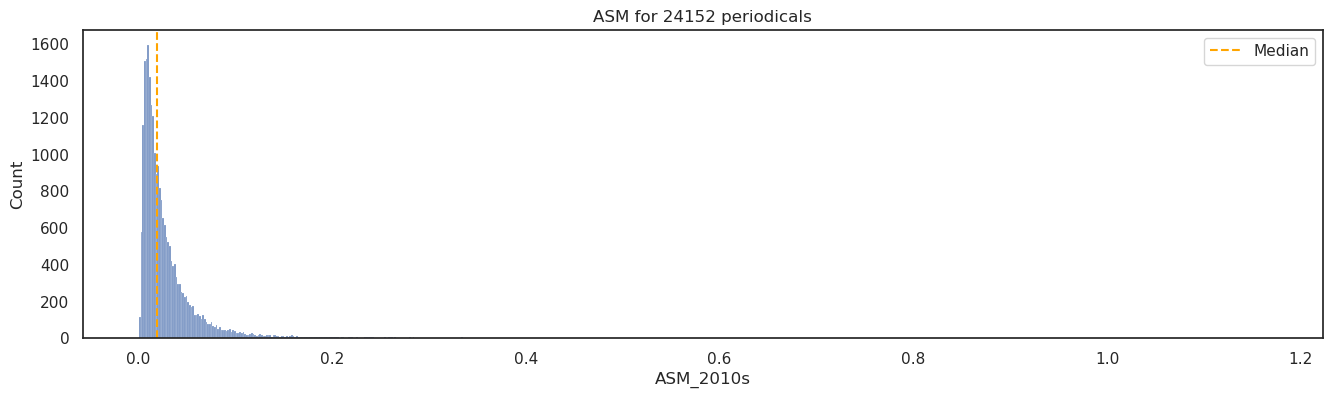

In [1132]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=neighbor_ASM_df, x='ASM_2010s')
plt.axvline(neighbor_ASM_df['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM for {} periodicals".format(len(neighbor_ASM_df)))

Text(0.5, 1.0, 'ASM of 1122 Peridocals born in 1950s')

<Figure size 1920x1440 with 0 Axes>

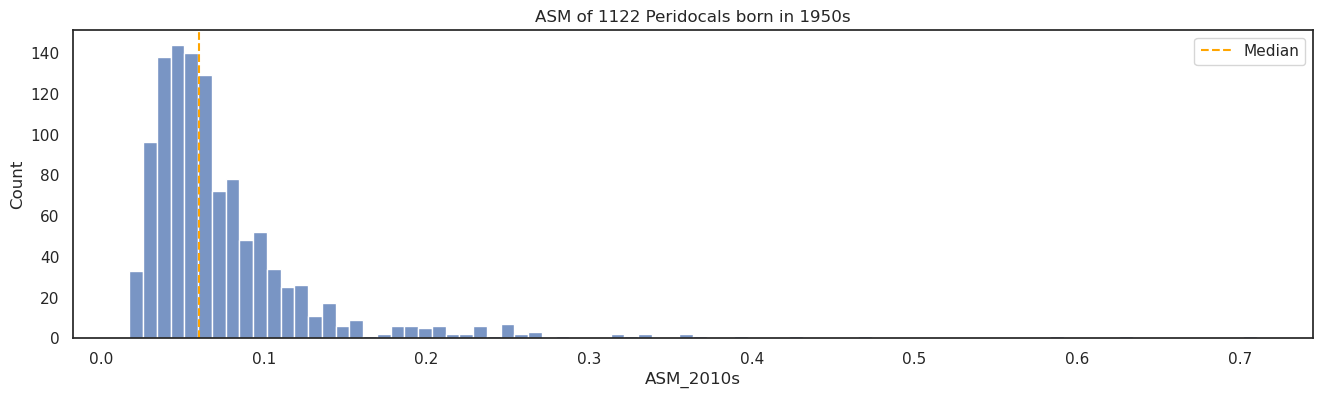

In [1133]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=neighbor_ASM_df[neighbor_ASM_df.start_idx==0], x='ASM_2010s')
plt.axvline(neighbor_ASM_df[neighbor_ASM_df.start_idx==0]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 1950s".format(len(neighbor_ASM_df[neighbor_ASM_df.start_idx==0])))

Text(0.5, 1.0, 'ASM of 1073 Peridocals born in 1960s')

<Figure size 1920x1440 with 0 Axes>

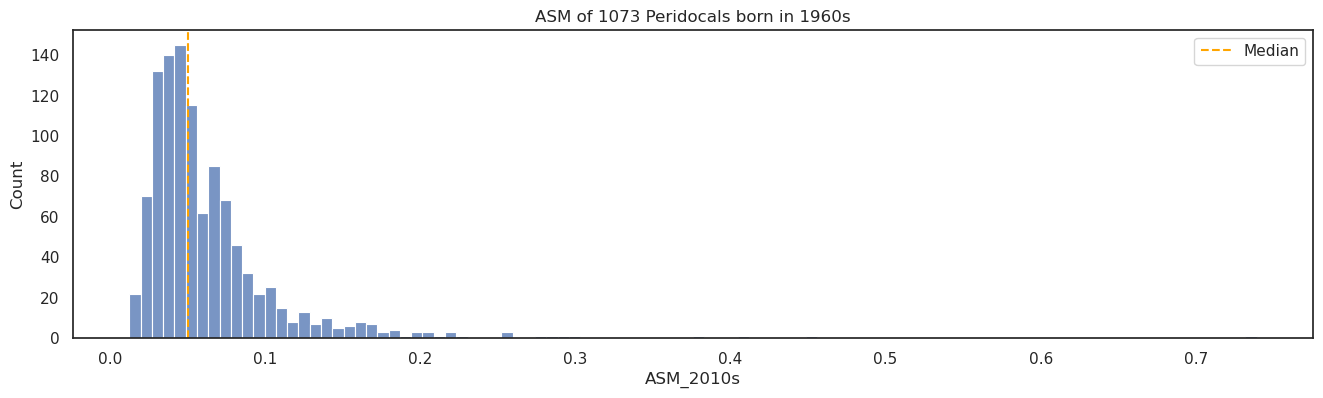

In [1134]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=neighbor_ASM_df[neighbor_ASM_df.start_idx==1], x='ASM_2010s')
plt.axvline(neighbor_ASM_df[neighbor_ASM_df.start_idx==1]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 1960s".format(len(neighbor_ASM_df[neighbor_ASM_df.start_idx==1])))

Text(0.5, 1.0, 'ASM of 1917 Peridocals born in 1970s')

<Figure size 1920x1440 with 0 Axes>

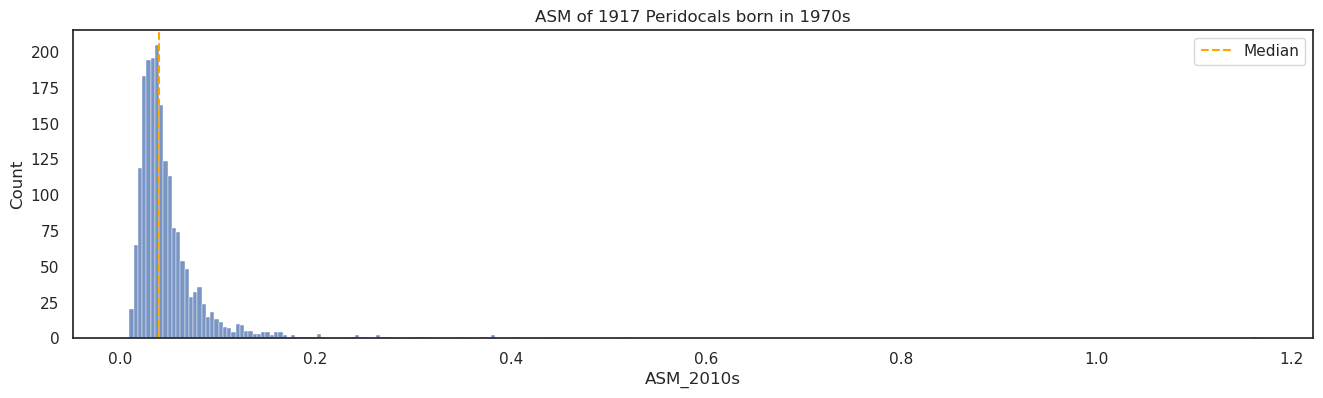

In [1135]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=neighbor_ASM_df[neighbor_ASM_df.start_idx==2], x='ASM_2010s')
plt.axvline(neighbor_ASM_df[neighbor_ASM_df.start_idx==2]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 1970s".format(len(neighbor_ASM_df[neighbor_ASM_df.start_idx==2])))

Text(0.5, 1.0, 'ASM of 7074 Peridocals born in 1980s')

<Figure size 1920x1440 with 0 Axes>

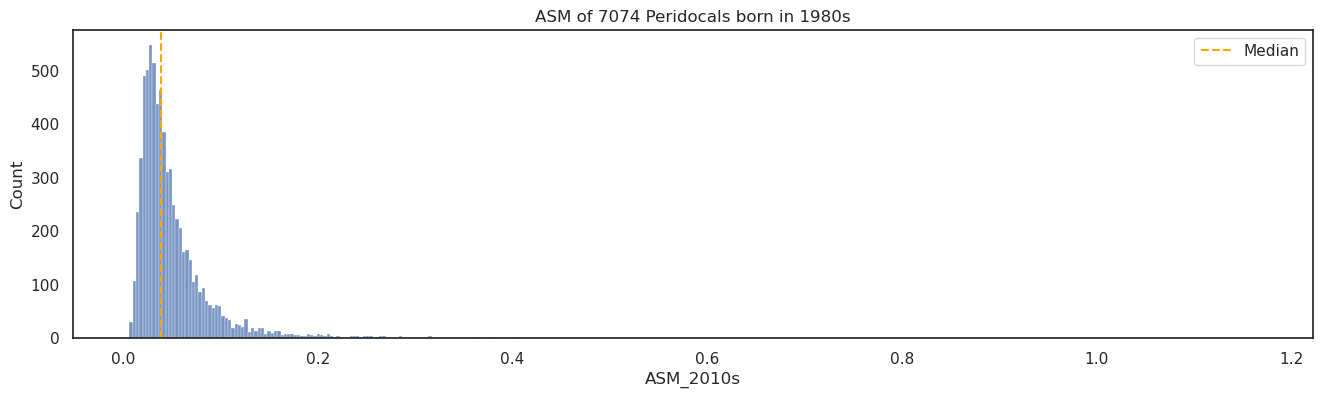

In [1136]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=neighbor_ASM_df.dropna(how='any', subset=col_name_list[3:]), x='ASM_2010s')
plt.axvline(neighbor_ASM_df.dropna(how='any', subset=col_name_list[3:])['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 1980s".format(len(neighbor_ASM_df.dropna(how='any', subset=col_name_list[3:]))))

Text(0.5, 1.0, 'ASM of 4927 Peridocals born in 1990s')

<Figure size 1920x1440 with 0 Axes>

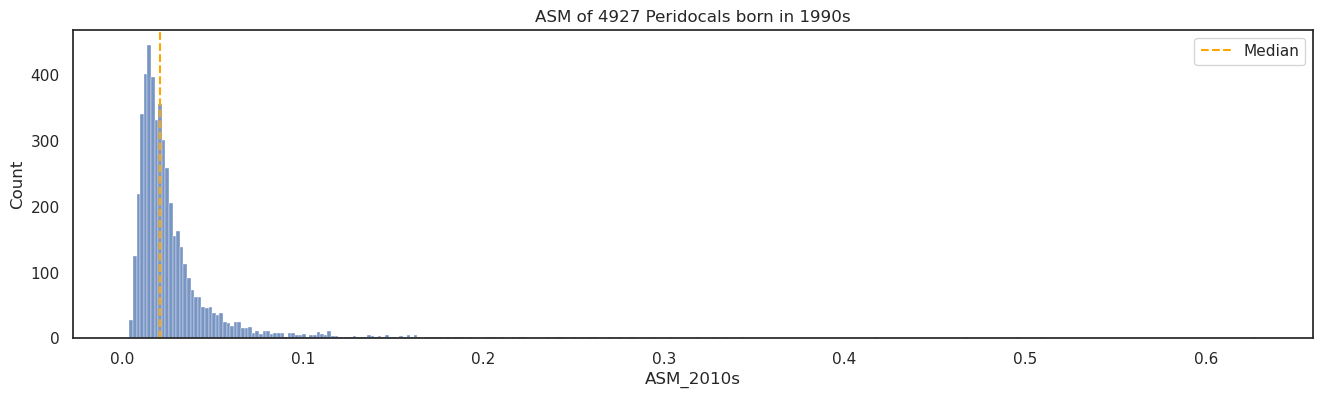

In [1137]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=neighbor_ASM_df[neighbor_ASM_df.start_idx==4], x='ASM_2010s')
plt.axvline(neighbor_ASM_df[neighbor_ASM_df.start_idx==4]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 1990s".format(len(neighbor_ASM_df[neighbor_ASM_df.start_idx==4])))

Text(0.5, 1.0, 'ASM of 12151 Peridocals born in 2000s')

<Figure size 1920x1440 with 0 Axes>

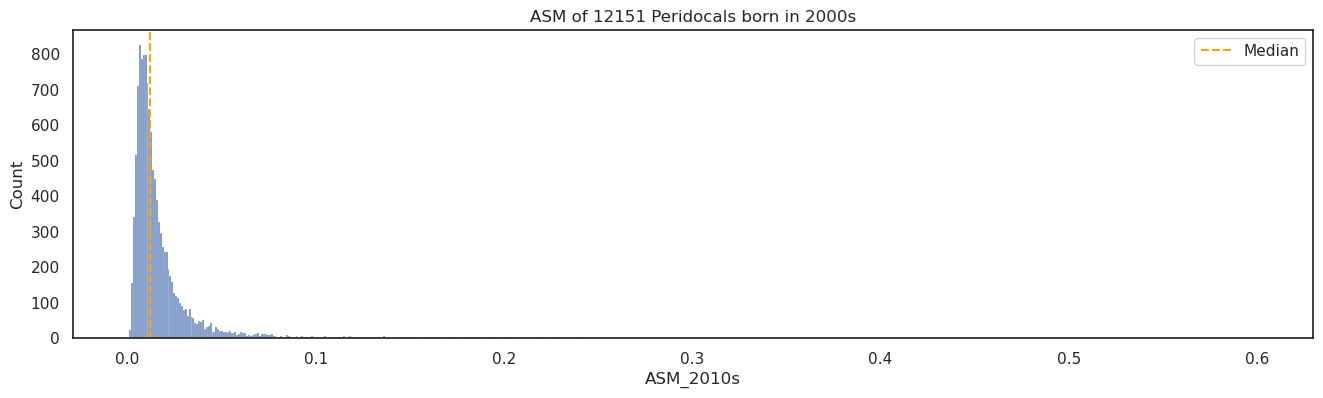

In [1138]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=neighbor_ASM_df[neighbor_ASM_df.start_idx==5], x='ASM_2010s')
plt.axvline(neighbor_ASM_df[neighbor_ASM_df.start_idx==5]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 2000s".format(len(neighbor_ASM_df[neighbor_ASM_df.start_idx==5])))

Text(0.5, 1.0, 'ASM for 24152 periodicals')

<Figure size 1920x1440 with 0 Axes>

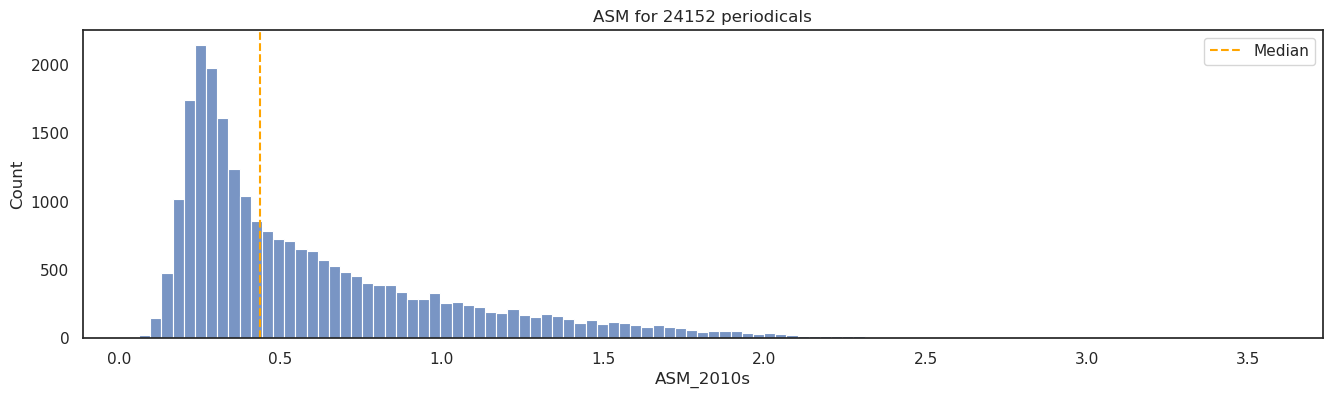

In [1139]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=self_ASM_df, x='ASM_2010s')
plt.axvline(self_ASM_df['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM for {} periodicals".format(len(self_ASM_df)))

<Figure size 1920x1440 with 0 Axes>

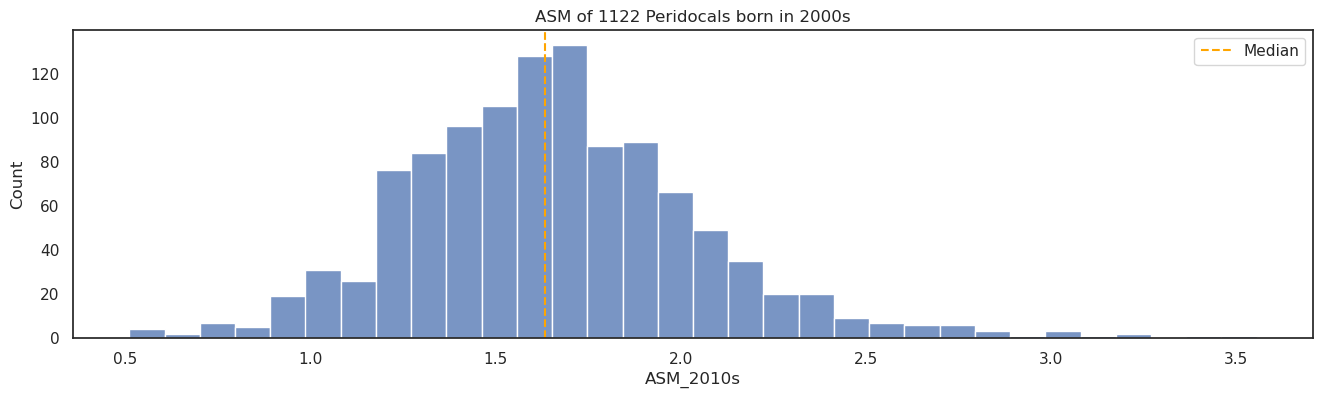

In [1140]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=self_ASM_df[self_ASM_df.start_idx==0], x='ASM_2010s')
plt.axvline(self_ASM_df[self_ASM_df.start_idx==0]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 2000s".format(len(self_ASM_df[self_ASM_df.start_idx==0])))
plt.show()

Text(0.5, 1.0, 'ASM of 1073 Peridocals born in 2000s')

<Figure size 1920x1440 with 0 Axes>

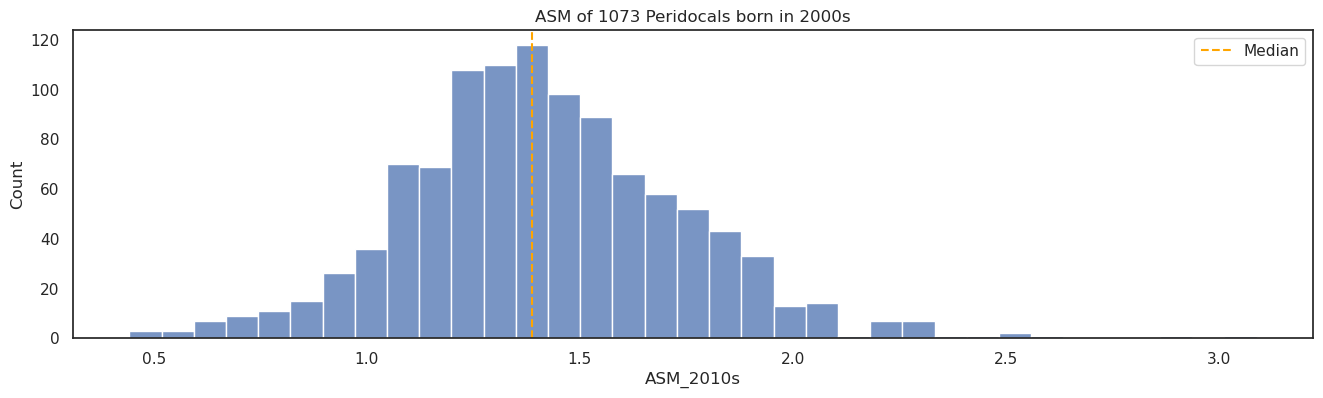

In [1141]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=self_ASM_df[self_ASM_df.start_idx==1], x='ASM_2010s')
plt.axvline(self_ASM_df[self_ASM_df.start_idx==1]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 2000s".format(len(self_ASM_df[self_ASM_df.start_idx==1])))

Text(0.5, 1.0, 'ASM of 1917 Peridocals born in 2000s')

<Figure size 1920x1440 with 0 Axes>

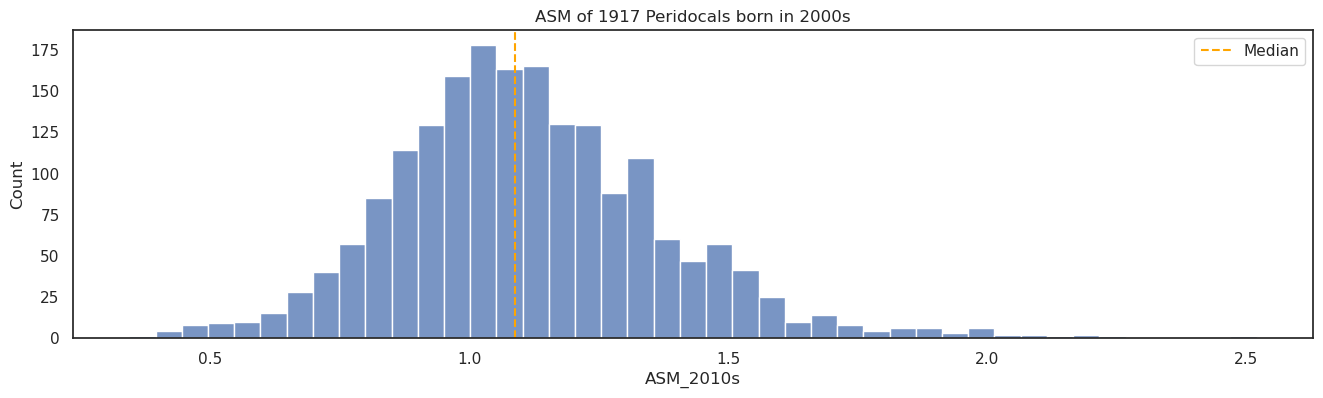

In [1142]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=self_ASM_df[self_ASM_df.start_idx==2], x='ASM_2010s')
plt.axvline(self_ASM_df[self_ASM_df.start_idx==2]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 2000s".format(len(self_ASM_df[self_ASM_df.start_idx==2])))

Text(0.5, 1.0, 'ASM of 2962 Peridocals born in 2000s')

<Figure size 1920x1440 with 0 Axes>

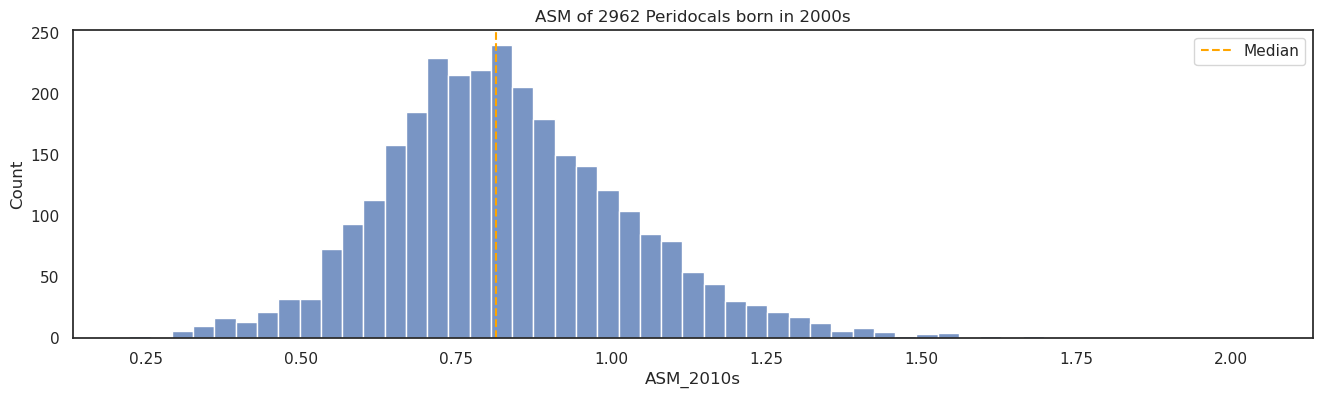

In [1143]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=self_ASM_df[self_ASM_df.start_idx==3], x='ASM_2010s')
plt.axvline(self_ASM_df[self_ASM_df.start_idx==3]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 2000s".format(len(self_ASM_df[self_ASM_df.start_idx==3])))

Text(0.5, 1.0, 'ASM of 4927 Peridocals born in 2000s')

<Figure size 1920x1440 with 0 Axes>

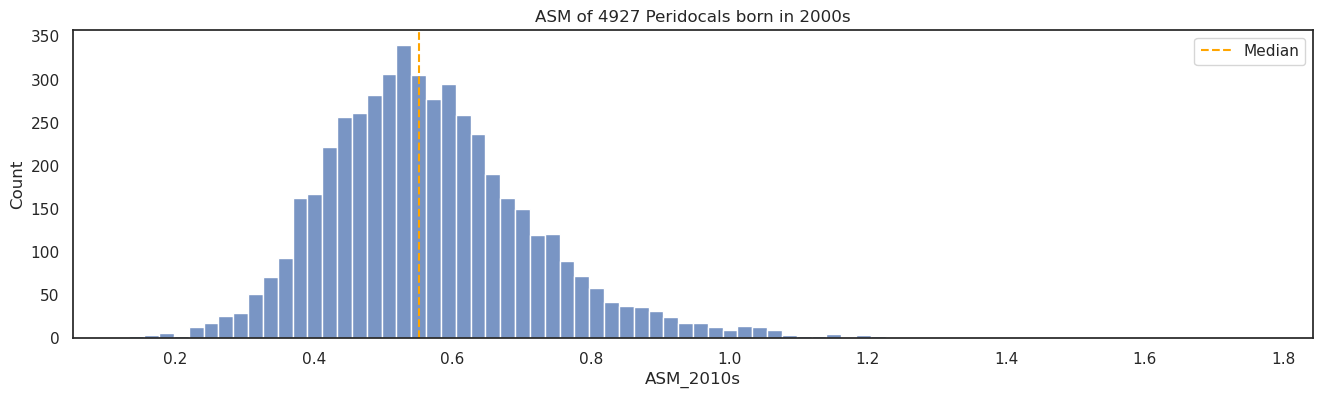

In [1144]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=self_ASM_df[self_ASM_df.start_idx==4], x='ASM_2010s')
plt.axvline(self_ASM_df[self_ASM_df.start_idx==4]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 2000s".format(len(self_ASM_df[self_ASM_df.start_idx==4])))

Text(0.5, 1.0, 'ASM of 12151 Peridocals born in 2000s')

<Figure size 1920x1440 with 0 Axes>

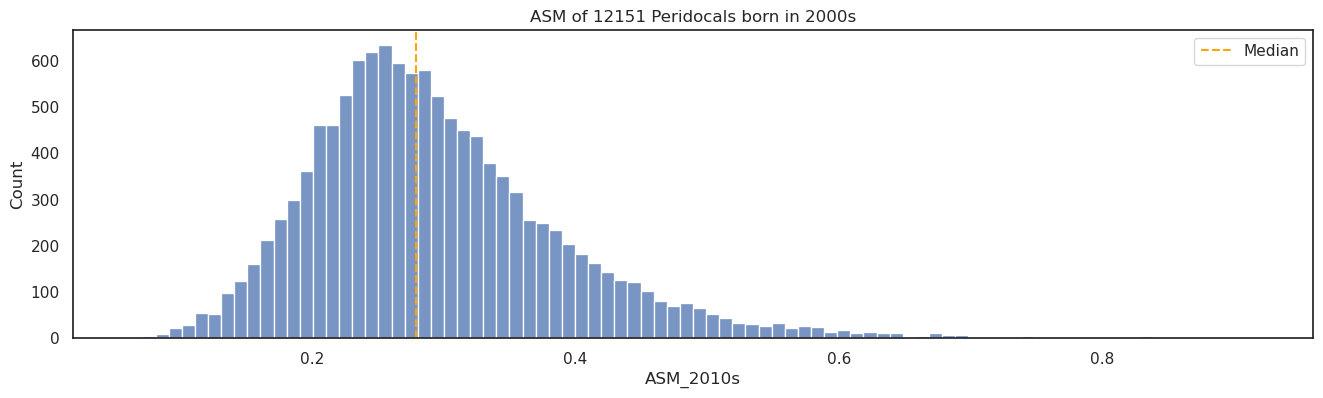

In [1145]:
plt.figure(dpi=300)
plt.figure(figsize=(16, 4))

sns.histplot(data=self_ASM_df[self_ASM_df.start_idx==5], x='ASM_2010s')
plt.axvline(self_ASM_df[self_ASM_df.start_idx==5]['ASM_2010s'].median(), c='orange', ls='--', lw=1.5, label='Median')
plt.legend()
plt.title("ASM of {} Peridocals born in 2000s".format(len(self_ASM_df[self_ASM_df.start_idx==5])))

# 5.2 relplot to compare ASM of periodcials in different age groups

In [1157]:
abbr_dict = {# 1950s
             'CA: A Cancer Journal for Clinicians':'CA: Cancer J. Clin.',
             'Quarterly Journal of Economics': 'QJE', 
             'Econometrica': 'Econometrica', 
             'Psychological Bulletin': 'Psychol. Bull.',
             'Chemical Reviews': 'Chem. Rev.',
             'JAMA': 'JAMA',
             'Science': 'Science',
             'Nature': 'Nature',
             'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
             'Physical Review Letters': 'PRL',
             'The New England Journal of Medicine': 'NEJM',
             'American Sociological Review': 'ASR',
             'Annals of Mathematics':'Ann. Math.',
             'The Lancet': 'Lancet',
             'BMJ': 'BMJ',
             'Philosophical Transactions of the Royal Society B': 'Proc. R. Soc. B',
    
             # 1960s
             'Atmosphere':'Atmosphere',
             'Language Learning': 'Lang. Learn.',
             'Automatica': 'Automatica',
             'Carbon':'Carbon',
             'Stanford Law Review': 'SLR',
             'Computing': 'Computing',
             'Journal of Applied Crystallography': 'J. Appl. Crystallogr.',
             'Ultrasonics': 'Ultrasonics',
             'IEEE Transactions on Nuclear Science': 'IEEE Trans Nucl Sci',
             'IEEE Transactions on Biomedical Engineering': 'IEEE. Trans. Biomed. Eng.',
             'Pattern Recognition': 'Pattern Recognit.',
             'Physics Letters B': 'PLB',
             'Journal of Financial and Quantitative Analysis': 'JFQA',
                
             # 1970s
             'Studies in Second Language Acquisition':'Stud. Second Lang. Acquis.',
             'Linguistic Inquiry': 'Linguist. Inq.',
             'European Journal of Political Research': 'EJPR',
             'Accounting Organizations and Society': 'Account. Organ. Soc.',
             'Clinical Infectious Diseases': 'Clin. Infect. Dis.',
             'Economic Analysis and Policy': 'Econ Anal Policy',
             'Research Policy': 'Res. Policy',
             'Gene': 'Gene',
             'Pain': 'Pain',
             'Social Networks': 'Soc. Netw.',
             'Life sciences in space research': 'Life Sci Space Res',
             'Computational Biology and Chemistry': 'Comput Biol Chem',
             'Civil Engineering': 'C.E.J',
             'Journal of Biosciences': 'J. Biosci.',
             'Cell': 'Cell',
    
             # 1980s
             'Applied Linguistics':'Appl. Linguist.',
             'Journal of Accounting and Economics': 'J. Account. Econ.',
             'Journal of Accounting and Public Policy': 'JAPP',
             'Journal of Physics: Condensed Matter': 'J. Phys. Condens. Matter',
             'Transport Reviews': 'Transp. Rev.',
             'European Management Journal': 'EMJ',
             'International Journal of Remote Sensing': 'Int. J. Remote Sens.',
             'Stem Cells': 'Stem Cells',
             'Journal of Chemometrics': 'J. Chemom.',
             'Bioelectromagnetics': 'Bioelectromagnetics',
             'neural information processing systems': 'NeurIPS',
             'IEEE Transactions on Medical Imaging': 'IEEE TMI',

             # 1990s
             'The Accounting Review': 'Account. Rev.',
             'Human Resource Management Journal': 'Hum. Resour. Manag. J.',
             'Cancer Cell': 'Cancer Cell',
             'IEEE Transactions on Applied Superconductivity': 'IEEE TAS',
             'Cell Research': 'Cell Res.',
             'the web conference': 'TheWebConf',
             'knowledge discovery and data mining': 'KDD',
             'empirical methods in natural language processing': 'EMNLP',
             'Materials': 'Materials',
             'Sensors': 'Sensor',
             'Complexity': 'Complexity',

             # 2000s
             'PLOS ONE': 'PLOS ONE',
             'Nature Reviews Immunology': 'Nat. Rev. Immunol.',
             'Nature Materials': 'Nat. Mater',
             'Lancet Oncology': 'Lancet Oncol.',
             'Nature Photonics': 'Nat. Photonics',
             'Obesity': 'Obesity',
             'Nature Chemical Biology': 'Nat. Chem. Biol.',
             'IEEE Transactions on Industrial Informatics': 'IEEE TII',
             'BMC Research Notes': 'BMC Res. Notes',
            }

display(neighbor_ASM_df[(neighbor_ASM_df.venue_name.isin(abbr_dict.keys()))&(neighbor_ASM_df.start_idx==0)][['venue_name', 'ASM_2010s']].sort_values(by='ASM_2010s', ascending=False))
display(neighbor_ASM_df[(neighbor_ASM_df.venue_name.isin(abbr_dict.keys()))&(neighbor_ASM_df.start_idx==1)][['venue_name', 'ASM_2010s']].sort_values(by='ASM_2010s', ascending=False))
display(neighbor_ASM_df[(neighbor_ASM_df.venue_name.isin(abbr_dict.keys()))&(neighbor_ASM_df.start_idx==2)][['venue_name', 'ASM_2010s']].sort_values(by='ASM_2010s', ascending=False))
display(neighbor_ASM_df[(neighbor_ASM_df.venue_name.isin(abbr_dict.keys()))&(neighbor_ASM_df.start_idx==3)][['venue_name', 'ASM_2010s']].sort_values(by='ASM_2010s', ascending=False))
display(neighbor_ASM_df[(neighbor_ASM_df.venue_name.isin(abbr_dict.keys()))&(neighbor_ASM_df.start_idx==4)][['venue_name', 'ASM_2010s']].sort_values(by='ASM_2010s', ascending=False))
display(neighbor_ASM_df[(neighbor_ASM_df.venue_name.isin(abbr_dict.keys()))&(neighbor_ASM_df.start_idx==5)][['venue_name', 'ASM_2010s']].sort_values(by='ASM_2010s', ascending=False))

,venue_name,ASM_2010s
979,Science,0.267192
85,Nature,0.247474
77,Philosophical Transactions of the Royal Society B,0.246643
1320,Proceedings of the National Academy of Sciences of the United States of America,0.144539
857,The New England Journal of Medicine,0.100504
565,CA: A Cancer Journal for Clinicians,0.092736
852,The Lancet,0.087426
1330,BMJ,0.080074
193,JAMA,0.077115
511,Chemical Reviews,0.074827


,venue_name,ASM_2010s
2665,Ultrasonics,0.190536
2145,Journal of Applied Crystallography,0.152381
2752,Computing,0.136057
2526,IEEE Transactions on Biomedical Engineering,0.122581
1639,Stanford Law Review,0.104531
1552,IEEE Transactions on Nuclear Science,0.091749
1677,Carbon,0.075117
2401,Pattern Recognition,0.062061
2463,Automatica,0.050950
2067,Physics Letters B,0.042353


,venue_name,ASM_2010s
3986,Civil Engineering,0.201097
5157,Journal of Biosciences,0.168479
3012,Computational Biology and Chemistry,0.134366
3270,Social Networks,0.091356
4159,Economic Analysis and Policy,0.080634
3880,Pain,0.071275
3592,Gene,0.060191
5418,Research Policy,0.048745
4466,Cell,0.038107
5412,Clinical Infectious Diseases,0.030143


,venue_name,ASM_2010s
6200,Bioelectromagnetics,0.168083
6090,Journal of Chemometrics,0.105488
8791,Stem Cells,0.081125
6350,neural information processing systems,0.065796
6020,IEEE Transactions on Medical Imaging,0.049271
5875,International Journal of Remote Sensing,0.028007
6496,Transport Reviews,0.025121
7487,Journal of Physics: Condensed Matter,0.023036
7969,European Management Journal,0.020542
8290,Journal of Accounting and Public Policy,0.013440


,venue_name,ASM_2010s
14253,Complexity,0.136743
10661,Sensors,0.097638
9899,Materials,0.060923
10824,Cell Research,0.040442
14290,the web conference,0.030379
14188,IEEE Transactions on Applied Superconductivity,0.030221
11687,Cancer Cell,0.020067
14504,knowledge discovery and data mining,0.014062
14682,empirical methods in natural language processing,0.010207
12940,Human Resource Management Journal,0.010061


,venue_name,ASM_2010s
15475,BMC Research Notes,0.062688
15477,PLOS ONE,0.033933
23772,IEEE Transactions on Industrial Informatics,0.025975
20368,Nature Chemical Biology,0.019146
17949,Obesity,0.013018
21064,Nature Photonics,0.007655
22769,Nature Materials,0.006010
19406,Nature Reviews Immunology,0.005038
25593,Lancet Oncology,0.003958


/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1920x1440 with 0 Axes>

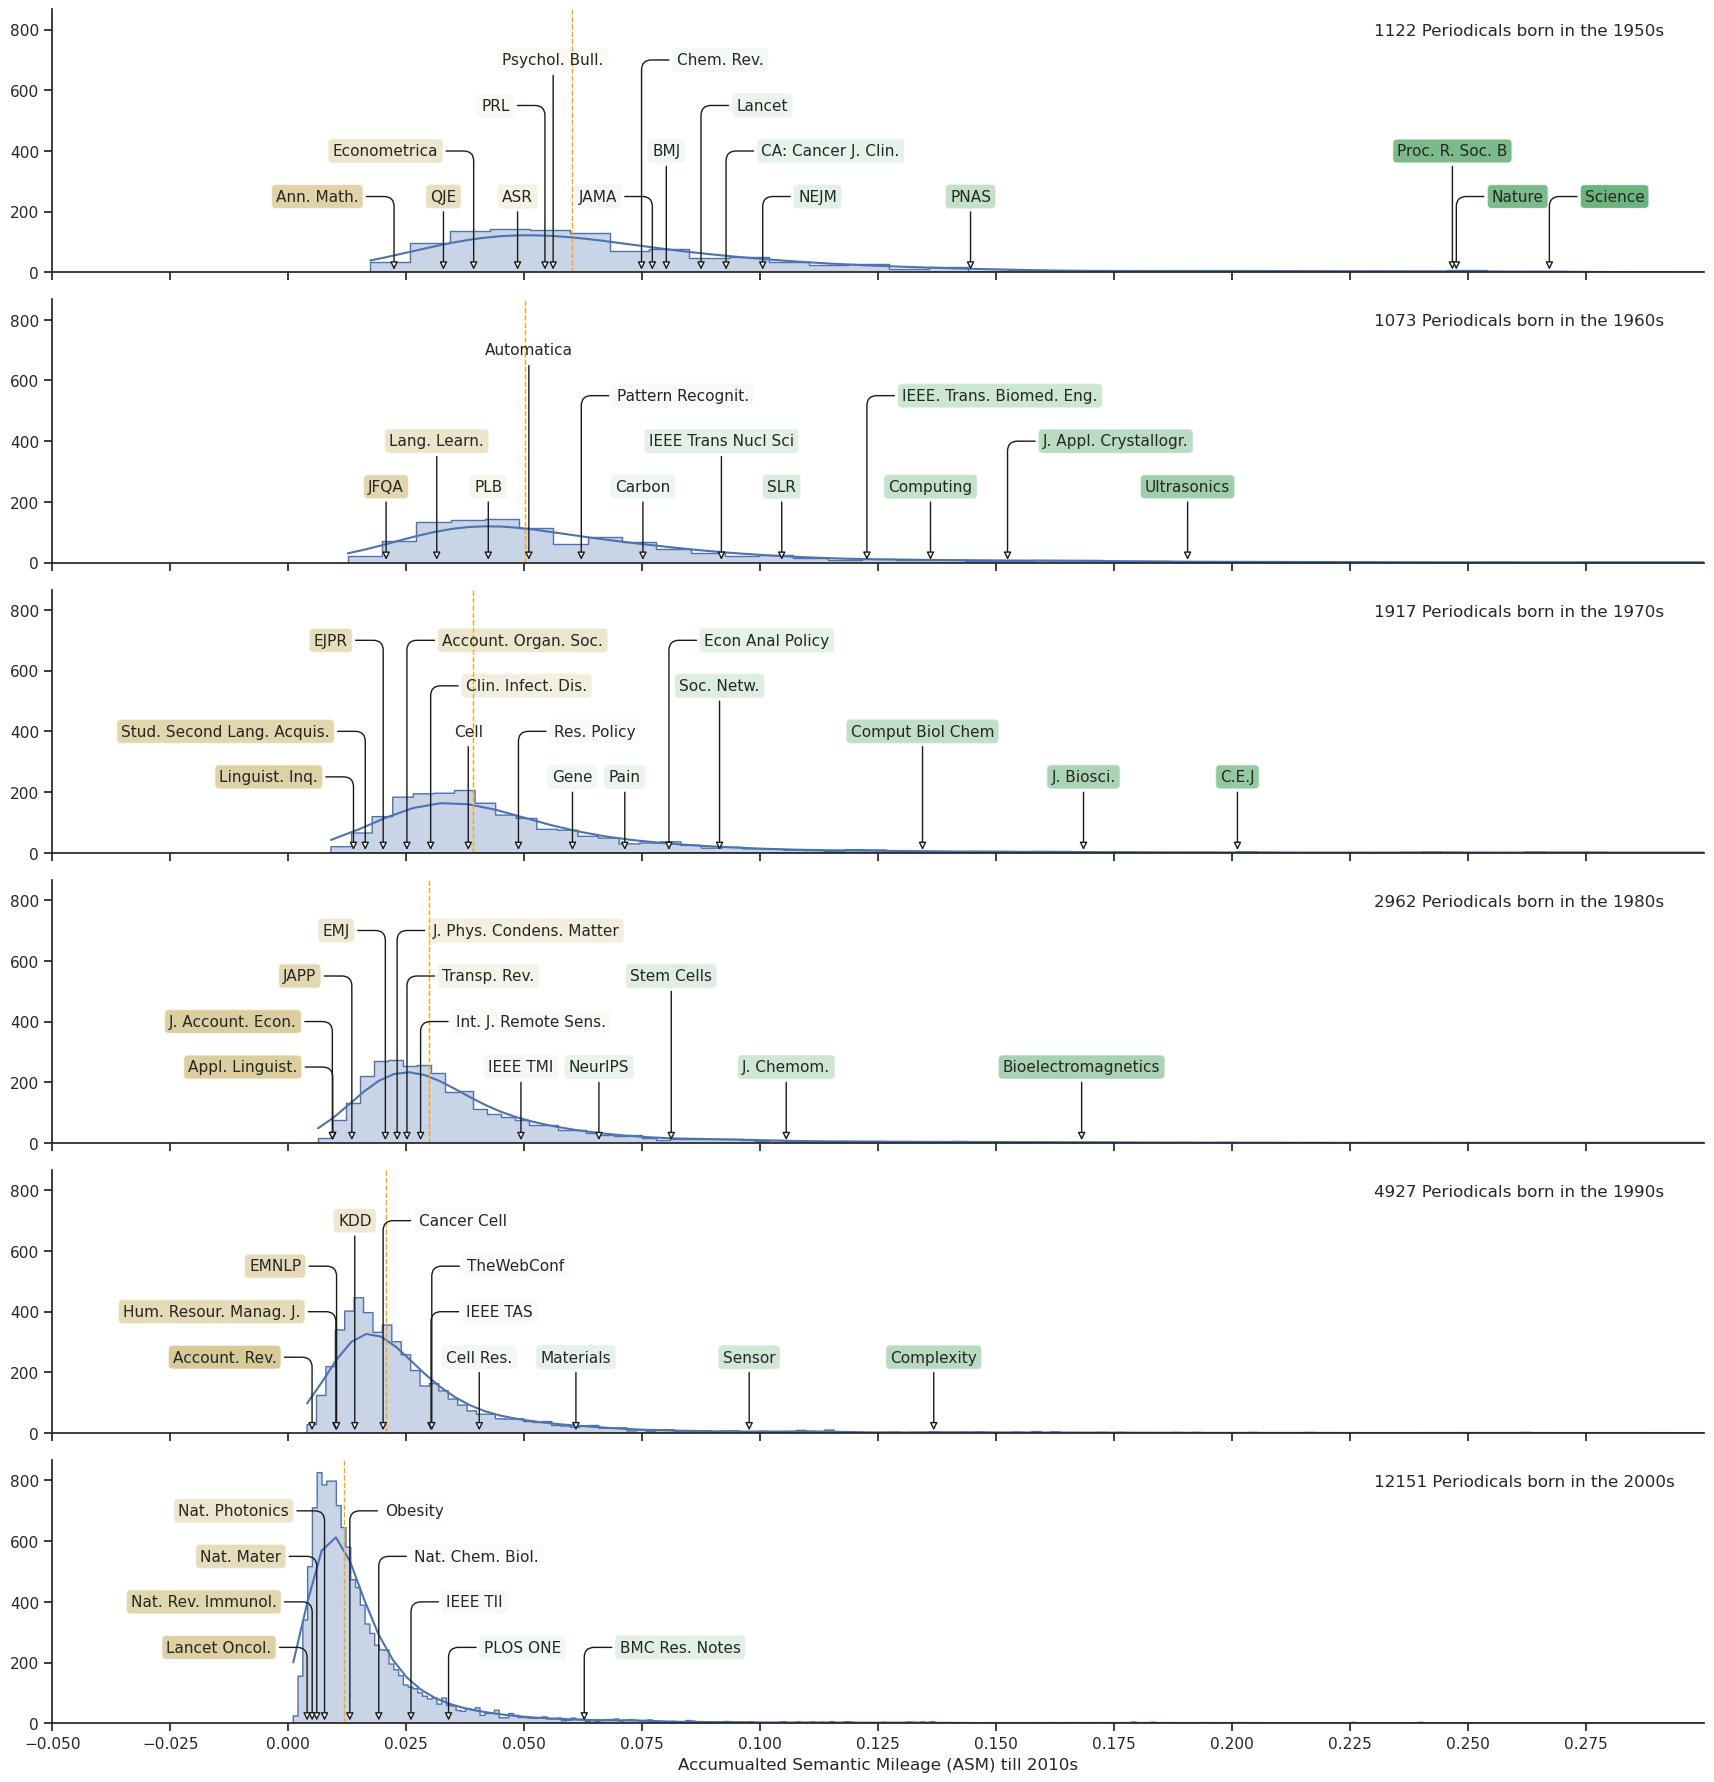

In [1183]:
def annotate_n_and_decade(data, **kws):
    n = len(data)
    start_year = start_year_list[data.start_idx.unique()[0]]
    ax = plt.gca()
    ax.text(0.8, .9, f"{n} Periodicals born in the {start_year}s", transform=ax.transAxes)


def plot_median(x, **kwargs):
    ax = plt.gca()
    ax.axvline(x.median(), c='orange', ls='--', lw=1)


def annotate_periodical_name(data, opaque_value, **kwargs):
    selected_data = data[data.venue_name.isin(abbr_dict.keys())]
    display()
    ax = plt.gca()
    for index, row in selected_data.iterrows():
        ASM = row.ASM_2010s
        median = data.ASM_2010s.median()
        venue_name = row.venue_name

        if ASM <= median:
            c = 'y'
            alpha = (median - ASM) / median
        if ASM > median:
            c = 'g'
            alpha = (ASM - median) / (opaque_value - median)
        # ---------------------------adjust height---------------------------
        # low
        if venue_name in [# 1950s
                          'Science', 'Psychological Bulletin', 'American Sociological Review', 'Nature', 
                          'Proceedings of the National Academy of Sciences of the United States of America', 'The New England Journal of Medicine',
                          'Quarterly Journal of Economics', 'Annals of Mathematics', 'JAMA', 
                          # 1960s
                          'Carbon', 'Stanford Law Review', 'Computing', 'Ultrasonics', 'Physics Letters B', 'Journal of Financial and Quantitative Analysis',
                          'Atmosphere', 
                          # 1970s
                          'Linguistic Inquiry', 
                          'Pain', 'Gene', 'Civil Engineering', 'Journal of Biosciences',
                          # 1980s
                          'Applied Linguistics', 'Journal of Chemometrics', 'Bioelectromagnetics',
                          'neural information processing systems', 'IEEE Transactions on Medical Imaging',
                          # 1990s
                          'The Accounting Review', 'Cell Research', 'Materials', 'Sensors', 'Complexity',
                          # 2000s
                          'PLOS ONE', 'Lancet Oncology', 'BMC Research Notes',
                         ]:
            label_y = 250
        # middle
        if venue_name in [# 1950s
                          'CA: A Cancer Journal for Clinicians', 'Econometrica', 'BMJ', 'Philosophical Transactions of the Royal Society B',
                          # 1960s
                          'IEEE Transactions on Nuclear Science', 'Language Learning', 'Journal of Applied Crystallography', 
                          # 1970s
                          'Studies in Second Language Acquisition', 'Computational Biology and Chemistry', 'Cell', 'Research Policy',
                          # 1980s
                          'Journal of Accounting and Economics', 'International Journal of Remote Sensing',
                          # 1990s
                          'Human Resource Management Journal', 'IEEE Transactions on Applied Superconductivity',
                          # 2000s
                          'Nature Reviews Immunology', 'IEEE Transactions on Industrial Informatics',
                          ]:
            label_y = 400
        # high
        if venue_name in [# 1950s
                          'Physical Review Letters', 'The Lancet',
                          # 1960s
                          'Pattern Recognition', 'IEEE Transactions on Biomedical Engineering', 
                          # 1970s
                          'Clinical Infectious Diseases', 'Social Networks', 'Life sciences in space research', 
                          # 1980s
                          'Journal of Accounting and Public Policy', 'Transport Reviews', 'Stem Cells',
                          # 1990s
                          'Cancer Cell', 'the web conference', 'empirical methods in natural language processing',
                          # 2000s
                          'Nature Materials', 'Nature Chemical Biology',
                         ]:
            label_y = 550
        # ultra high
        if venue_name in [# 1950s
                          'Chemical Reviews', 'Psychological Bulletin', 
                          # 1960s
                          'Automatica',
                          # 1970s
                          'European Journal of Political Research', 'Accounting Organizations and Society', 'Economic Analysis and Policy',
                          # 1980s
                          'Journal of Physics: Condensed Matter', 'European Management Journal', 
                          # 1990s
                          'Cancer Cell', 'knowledge discovery and data mining',
                          # 2000s
                          'Nature Photonics', 'Obesity',
                          ]:
            label_y = 700
            
        # ---------------------------adjust arrow direction---------------------------
        # straight arrow
        if venue_name in [# 1950s
                          'Proceedings of the National Academy of Sciences of the United States of America',
                          'American Sociological Review', 'Quarterly Journal of Economics', 'Psychological Bulletin', 'BMJ',
                          # 1960s
                          'Carbon', 'Stanford Law Review', 'Computing', 'Ultrasonics', 'Language Learning',
                          'IEEE Transactions on Nuclear Science', 'Physics Letters B', 'Journal of Financial and Quantitative Analysis', 'Automatica',
                          # 1970s
                          'Pain', 'Gene', 'Social Networks',
                          'Computational Biology and Chemistry', 'Civil Engineering', 'Journal of Biosciences', 'Cell',
                          # 1980s
                          'Stem Cells', 'Journal of Chemometrics', 'Bioelectromagnetics',
                          'neural information processing systems', 'IEEE Transactions on Medical Imaging',
                          # 1990s
                          'knowledge discovery and data mining', 'Complexity', 'Sensors', 'Cell Research', 'Materials',
                         # 2000s
                          'Philosophical Transactions of the Royal Society B',
                         ]:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.", fc="w", color='k')
            label_x = ASM
            haligh = 'center'
            
        # bend arrow
        else:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="angle,angleA=0,angleB=-90,rad=10", fc="w", color='k')
            # bend right
            if venue_name in [# 1950s
                              'Proceedings of the National Academy of Sciences of the United States of America',
                              'The New England Journal of Medicine', 'CA: A Cancer Journal for Clinicians', 'The New England Journal of Medicine',
                              'Chemical Reviews', 'The Lancet', 'Science', 'Nature', 
                              # 1960s
                              'IEEE Transactions on Biomedical Engineering', 'Journal of Applied Crystallography', 'Pattern Recognition', 
                              # 1970s
                              'Accounting Organizations and Society', 'Clinical Infectious Diseases', 'Research Policy',
                              'Economic Analysis and Policy', 'Life sciences in space research',
                              # 1980s
                              'Transport Reviews', 'Journal of Physics: Condensed Matter', 'International Journal of Remote Sensing',
                              # 1990s
                              'the web conference', 'IEEE Transactions on Applied Superconductivity', 'Cancer Cell',
                              # 2000s
                              'Obesity', 'Nature Chemical Biology', 'IEEE Transactions on Industrial Informatics', 'PLOS ONE', 'BMC Research Notes',
                             ]:
                label_x = ASM + 0.0075
                haligh = 'left'
            # bend left
            if venue_name in [# 1950s
                              'Physical Review Letters', 'Econometrica', 'Annals of Mathematics', 'JAMA', 
                              # 1960s
                              'Atmosphere', 
                              # 1970s
                              'Linguistic Inquiry', 'Studies in Second Language Acquisition', 'European Journal of Political Research', 
                              # 1980s
                              'Applied Linguistics', 'Journal of Accounting and Economics', 'European Management Journal', 
                              'Journal of Accounting and Public Policy',
                             # 1990s
                              'The Accounting Review', 'Human Resource Management Journal', 'empirical methods in natural language processing',
                             # 2000s
                              'Nature Reviews Immunology', 'Nature Materials', 'Lancet Oncology', 'Nature Photonics', 
                              
            ]: 
                label_x = ASM - 0.0075
                haligh = 'right'

        bbox_props = dict(boxstyle="round", fc=c, ec="1", alpha=alpha)
        ax.annotate(abbr_dict[venue_name], xy=(ASM, 0), xytext=(label_x, label_y), ha=haligh, va="center",
                    size=11, bbox = bbox_props, arrowprops = arrow_props)


plt.figure(dpi=300)
sns.set(style='white', font_scale=1)
g = sns.FacetGrid(neighbor_ASM_df, row="start_idx", height=3, aspect=6, margin_titles=True)
g.tick_params(axis='both', bottom='on',left='on')
g.set(xlim=(-0.05, 0.3), xticks=np.arange(-0.05, 0.3, 0.025), yticks=np.arange(0, 1000, 200))

g.map_dataframe(sns.histplot, x="ASM_2010s", kde=True, element='step', alpha=0.3)
g.map(plot_median, 'ASM_2010s')
g.map_dataframe(annotate_n_and_decade)
g.map_dataframe(annotate_periodical_name, data=neighbor_ASM_df, opaque_value=0.3)

for ax in g.axes.flatten():
    ax.set_ylabel('')
g.set_titles(row_template='')
g.set_xlabels('Accumualted Semantic Mileage (ASM) till 2010s')

plt.show()

/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1920x1440 with 0 Axes>

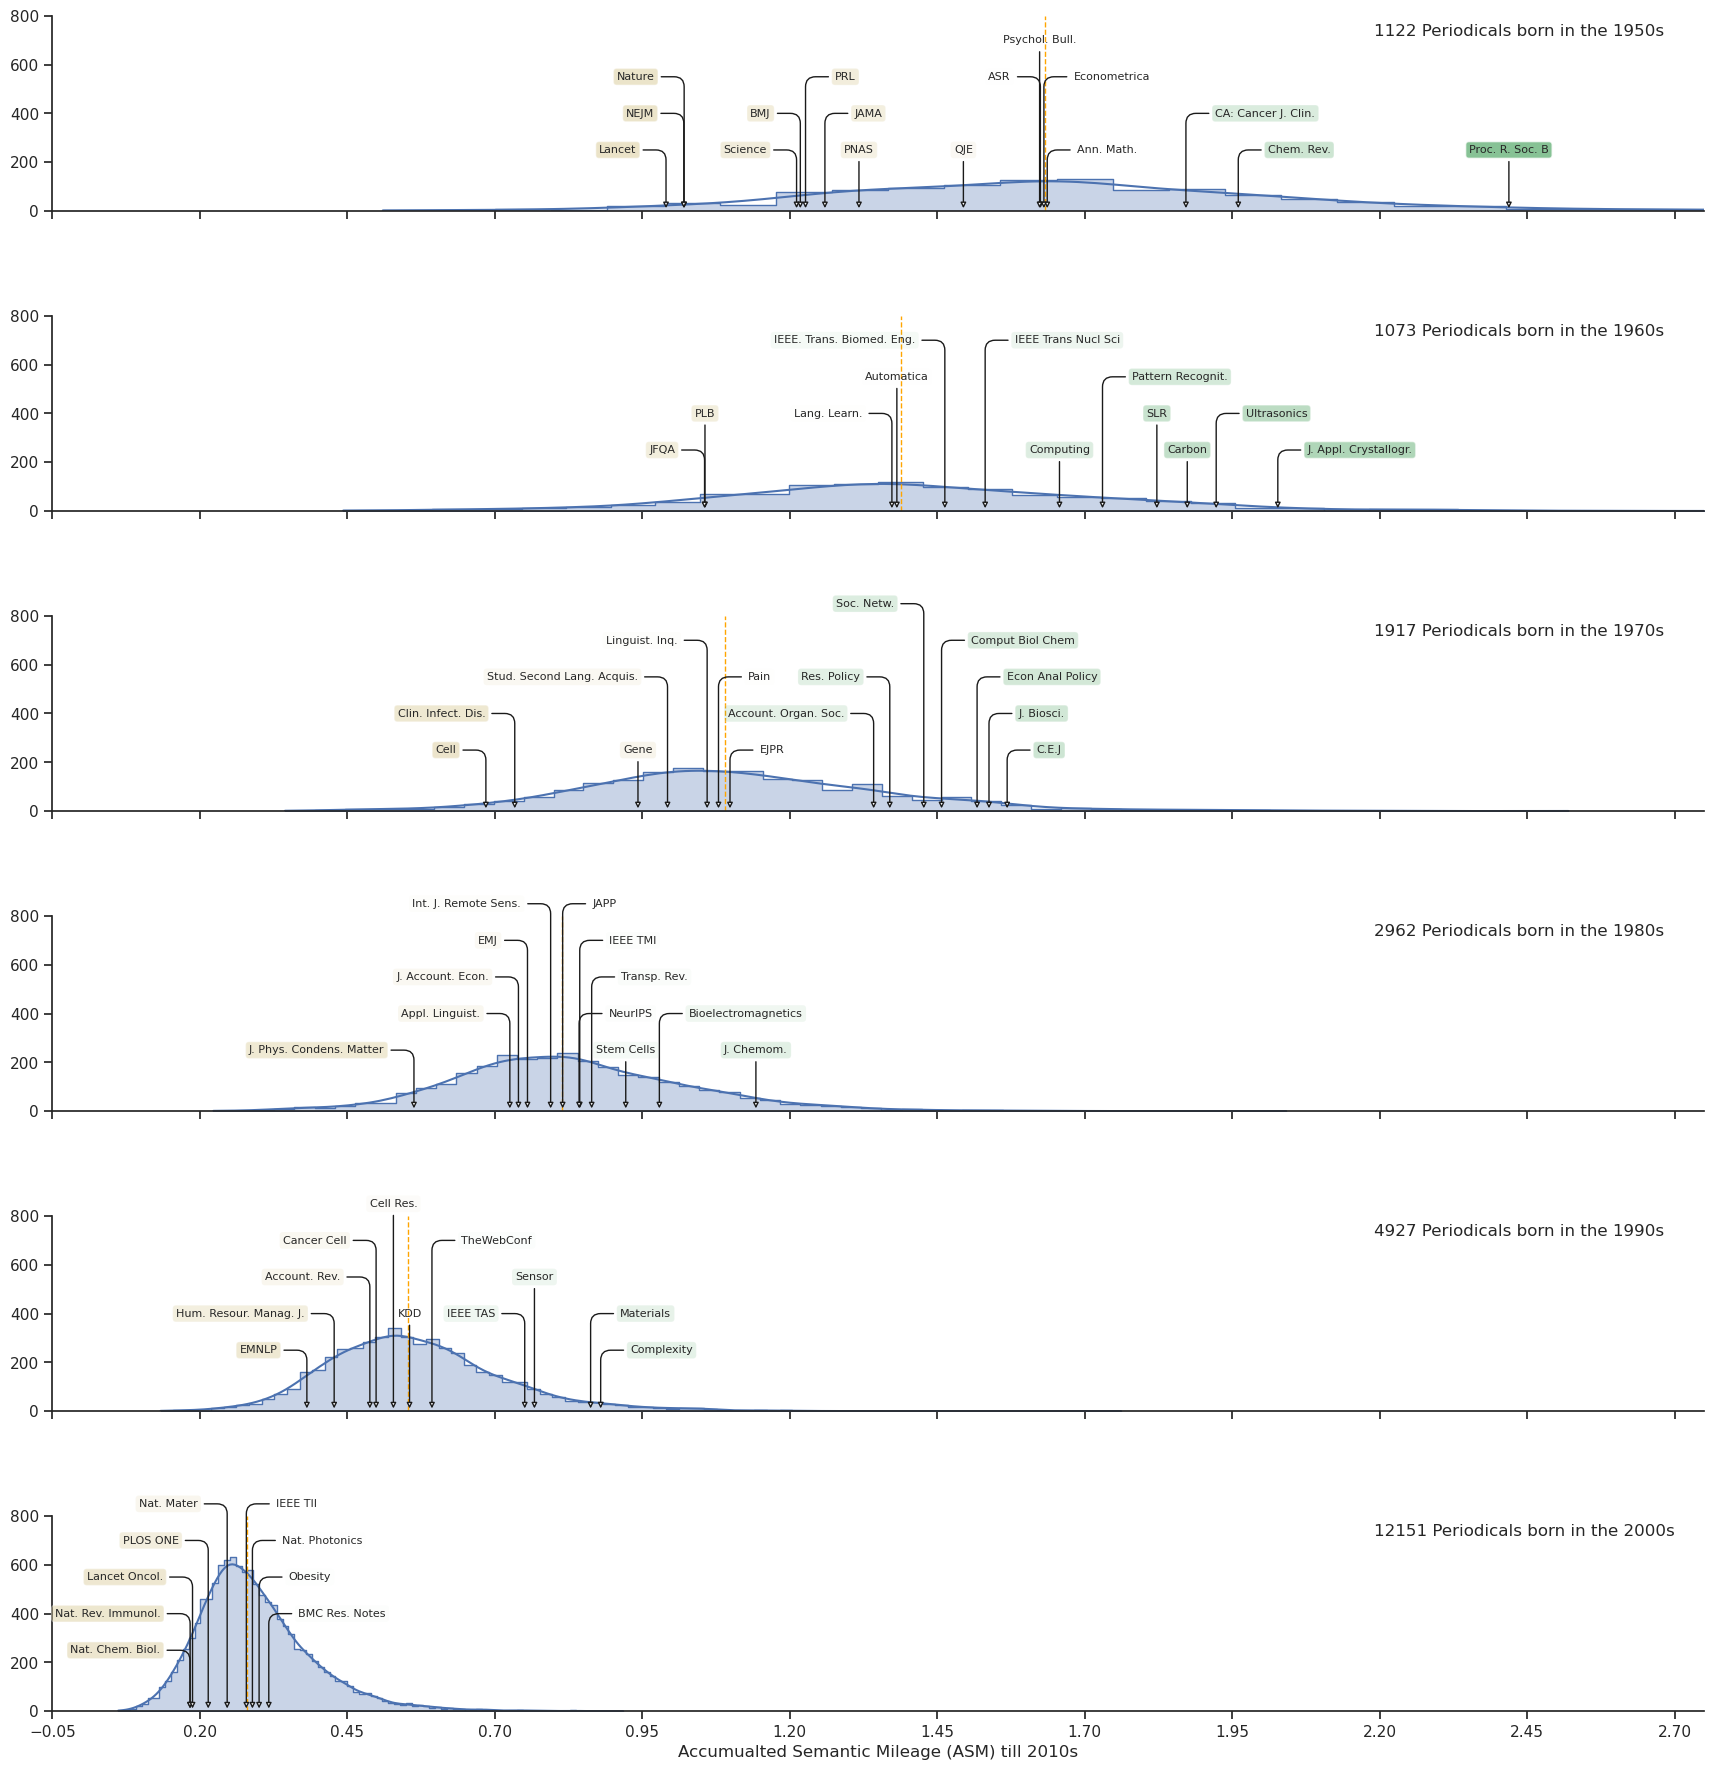

In [1279]:
def annotate_periodical_name(data, opaque_value, **kwargs):
    selected_data = data[data.venue_name.isin(abbr_dict.keys())]
    display()
    ax = plt.gca()
    for index, row in selected_data.iterrows():
        ASM = row.ASM_2010s
        median = data.ASM_2010s.median()
        venue_name = row.venue_name

        if ASM <= median:
            c = 'y'
            alpha = (median - ASM) / median
        if ASM > median:
            c = 'g'
            alpha = (ASM - median) / (opaque_value - median)
        # ---------------------------adjust height---------------------------
        # low
        if venue_name in [# 1950s
                          'Psychological Bulletin', 'Proceedings of the National Academy of Sciences of the United States of America',
                          'Science', 'The Lancet', 
                          'Quarterly Journal of Economics', 'Annals of Mathematics', 'Chemical Reviews', 
                          'Philosophical Transactions of the Royal Society B', 'Journal of Applied Crystallography', 
                          # 1960s
                          'Carbon', 'Computing', 'Ultrasonics', 
                          'Journal of Financial and Quantitative Analysis',
                          'Atmosphere', 
                          # 1970s
                          'Cell', 'European Journal of Political Research', 
                          'Gene', 'Civil Engineering', 
                          # 1980s
                          'Journal of Chemometrics', 'Journal of Physics: Condensed Matter', 
                          'Stem Cells', 
                          # 1990s
                          'Complexity', 'empirical methods in natural language processing',
                          # 2000s
                          'Nature Chemical Biology', 
                         ]:
            label_y = 250

        # middle
        if venue_name in [# 1950s
                          'CA: A Cancer Journal for Clinicians', 'BMJ', 'JAMA', 
                          'The New England Journal of Medicine', 
                          # 1960s
                          'Language Learning', 'Ultrasonics', 'Stanford Law Review', 'Physics Letters B', 
                          # 1970s
                          'Journal of Biosciences', 'Clinical Infectious Diseases', 'Accounting Organizations and Society',
                          # 1980s
                          'Bioelectromagnetics', 'Applied Linguistics', 'neural information processing systems', 
                          # 1990s
                          'Human Resource Management Journal', 'IEEE Transactions on Applied Superconductivity', 'knowledge discovery and data mining',
                          'Materials', 
                          # 2000s
                          'Nature Reviews Immunology', 'BMC Research Notes', 
                          ]:
            label_y = 400
        # high
        if venue_name in [# 1950s
                          'Physical Review Letters', 'Econometrica', 'American Sociological Review', 'Nature', 
                          # 1960s
                          'Pattern Recognition', 'Automatica', 
                          # 1970s
                          'Life sciences in space research', 'Economic Analysis and Policy',
                          'Pain', 'Research Policy', 'Studies in Second Language Acquisition', 
                          # 1980s
                          'Transport Reviews', 'Journal of Accounting and Economics', 
                          # 1990s
                          'Cancer Cell', 'The Accounting Review', 'Sensors', 
                          # 2000s
                          'Lancet Oncology', 'Obesity', 
                         ]:
            label_y = 550

        # ultra high
        if venue_name in [# 1950s
                          'Psychological Bulletin', 
                          # 1960s
                          'IEEE Transactions on Biomedical Engineering', 'IEEE Transactions on Nuclear Science',
                          # 1970s
                          'Computational Biology and Chemistry', 'Linguistic Inquiry', 
                          # 1980s
                          'European Management Journal', 'IEEE Transactions on Medical Imaging',
                          # 1990s
                          'Cancer Cell', 'the web conference', 
                          # 2000s
                          'PLOS ONE', 'Nature Photonics', 
                          ]:
            label_y = 700

        # max high
        if venue_name in [# 1950s
                          
                          # 1960s
                          
                          # 1970s
                          'Social Networks', 
                          # 1980s
                          'International Journal of Remote Sensing', 'Journal of Accounting and Public Policy', 
                          # 1990s
                          'Cell Research', 
                          # 2000s
                          'Nature Materials', 'IEEE Transactions on Industrial Informatics', 
                          ]:
            label_y = 850
            
        # ---------------------------adjust arrow direction---------------------------
        # straight arrow
        if venue_name in [# 1950s
                          'Proceedings of the National Academy of Sciences of the United States of America',
                          'Quarterly Journal of Economics', 'Psychological Bulletin',  
                          # 1960s
                          'Carbon', 'Stanford Law Review', 'Computing', 
                          'Physics Letters B', 'Automatica',
                          # 1970s
                          'Gene', 
                          # 1980s
                          'Journal of Chemometrics', 
                          'Stem Cells', 
                          # 1990s
                          'knowledge discovery and data mining', 'Sensors', 'Cell Research', 
                         # 2000s
                          'Philosophical Transactions of the Royal Society B',
                         ]:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="arc3,rad=0.", fc="w", color='k')
            label_x = ASM
            haligh = 'center'

        # bend arrow
        else:
            arrow_props = dict(arrowstyle="-|>", connectionstyle="angle,angleA=0,angleB=-90,rad=10", fc="w", color='k')
            # bend right
            if venue_name in [# 1950s
                              'Proceedings of the National Academy of Sciences of the United States of America', 'JAMA',
                              'The New England Journal of Medicine', 'CA: A Cancer Journal for Clinicians', 
                              'Chemical Reviews', 'Econometrica', 'Annals of Mathematics', 'Physical Review Letters', 
                              # 1960s
                              'Journal of Applied Crystallography', 'Pattern Recognition', 'IEEE Transactions on Nuclear Science', 'Ultrasonics', 
                              # 1970s
                              'European Journal of Political Research', 'Pain', 
                              'Economic Analysis and Policy', 'Life sciences in space research', 'Civil Engineering', 'Journal of Biosciences', 
                              'Computational Biology and Chemistry', 
                              # 1980s
                              'Transport Reviews', 'Bioelectromagnetics', 'Journal of Accounting and Public Policy', 
                              'IEEE Transactions on Medical Imaging', 'neural information processing systems', 
                              # 1990s
                              'the web conference', 'Complexity', 'Materials', 
                              # 2000s
                              'Obesity', 'IEEE Transactions on Industrial Informatics', 'BMC Research Notes', 'Nature Photonics', 
                             ]:
                label_x = ASM + 0.05
                haligh = 'left'
            # bend left
            if venue_name in [# 1950s
                              'Science', 'BMJ', 'The Lancet', 'Journal of Financial and Quantitative Analysis', 
                              'The New England Journal of Medicine', 'Nature', 'American Sociological Review', 
                              # 1960s
                              'Atmosphere', 'Language Learning', 'IEEE Transactions on Biomedical Engineering', 
                              # 1970s
                              'Linguistic Inquiry', 'Studies in Second Language Acquisition', 'Cell', 'Clinical Infectious Diseases', 
                              'Research Policy', 'Accounting Organizations and Society', 'Social Networks',
                              # 1980s
                              'Applied Linguistics', 'Journal of Accounting and Economics', 'European Management Journal', 
                              'Journal of Physics: Condensed Matter', 
                              'International Journal of Remote Sensing', 
                             # 1990s
                              'The Accounting Review', 'Human Resource Management Journal', 'empirical methods in natural language processing',
                              'Cancer Cell', 'IEEE Transactions on Applied Superconductivity', 
                             # 2000s
                              'Nature Reviews Immunology', 'Nature Materials', 'Lancet Oncology', 'Nature Chemical Biology', 'PLOS ONE', 
                              
            ]: 
                label_x = ASM - 0.05
                haligh = 'right'

        bbox_props = dict(boxstyle="round", fc=c, ec="1", alpha=alpha)
        ax.annotate(abbr_dict[venue_name], xy=(ASM, 0), xytext=(label_x, label_y), ha=haligh, va="center",
                    size=8, bbox = bbox_props, arrowprops = arrow_props)


plt.figure(dpi=300)
sns.set(style='white', font_scale=1)
g = sns.FacetGrid(self_ASM_df, row="start_idx", height=3, aspect=6, margin_titles=True)

g.map_dataframe(sns.histplot, x="ASM_2010s", kde=True, element='step', alpha=0.3)
g.map(plot_median, 'ASM_2010s')
g.map_dataframe(annotate_n_and_decade)
g.map_dataframe(annotate_periodical_name, data=self_ASM_df, opaque_value=2.75)

for ax in g.axes.flatten():
    ax.set_ylabel('')
g.set_titles(row_template='')
g.set_xlabels('Accumualted Semantic Mileage (ASM) till 2010s')
g.tick_params(axis='both', bottom='on',left='on')
g.set(xlim=(-0.05, 2.75), xticks=np.arange(-0.05, 2.75, 0.25), yticks=np.arange(0, 1000, 200))

plt.show()

# 5.3 ASM of Single periodicals

In [1163]:
abbr_dict_2 = {# 1950s
             'Science': 'Science',
             'Nature': 'Nature',
             'Philosophical Transactions of the Royal Society B': 'Proc. R. Soc. B',
             'Proceedings of the National Academy of Sciences of the United States of America': 'PNAS',
             'The New England Journal of Medicine': 'NEJM',
             'CA: A Cancer Journal for Clinicians':'CA: Cancer J. Clin.',
             'The Lancet': 'Lancet',
             'BMJ': 'BMJ',
             'JAMA': 'JAMA',
             'Chemical Reviews': 'Chem. Rev.',
             'Psychological Bulletin': 'Psychol. Bull.',
             'Physical Review Letters': 'PRL',
             'American Sociological Review': 'ASR',
             'Econometrica': 'Econometrica', 
             'Quarterly Journal of Economics': 'QJE', 
             'Annals of Mathematics':'Ann. Math.',
            }

/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1920x1440 with 0 Axes>

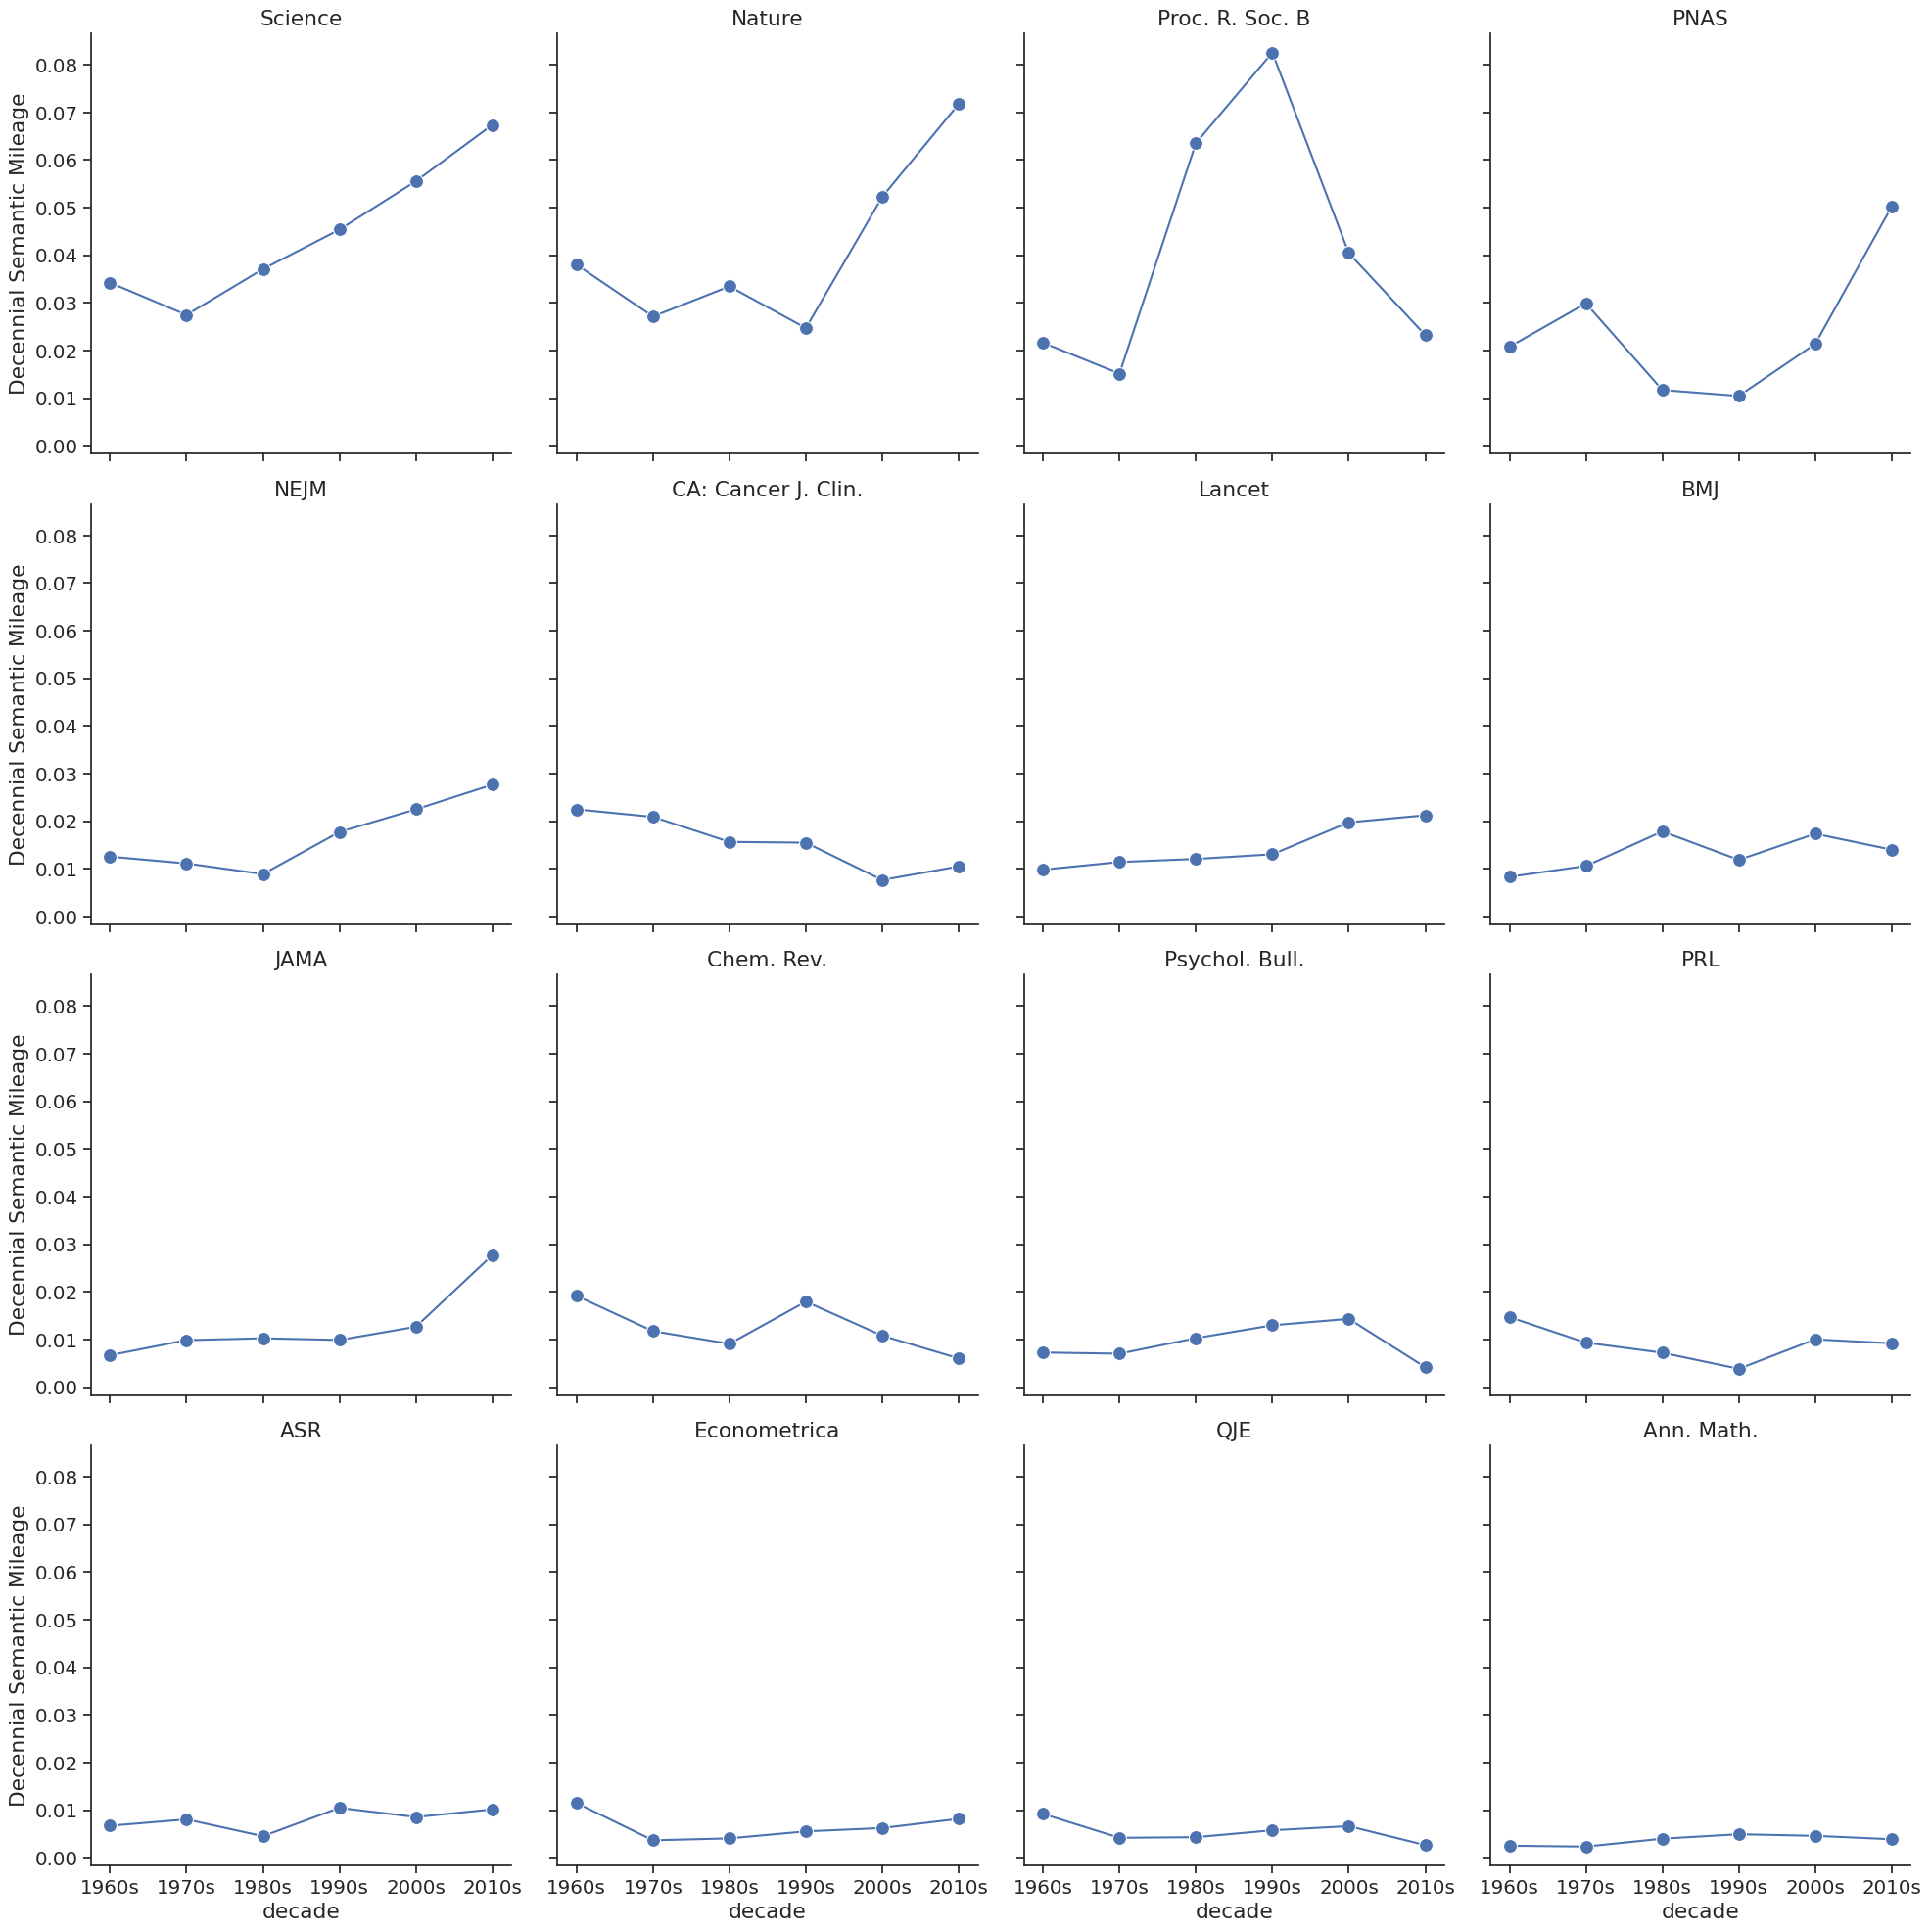

In [1172]:
neighbor_ASM_df_rename = neighbor_ASM_df[neighbor_ASM_df.venue_name.isin(abbr_dict_2.keys())].copy()
neighbor_ASM_df_rename.venue_name = neighbor_ASM_df_rename.venue_name.replace(abbr_dict_2)

neighbor_ASM_df_wide = pd.wide_to_long(neighbor_ASM_df_rename,
                                    stubnames=['semantic_mileage'],
                                    suffix='.+',
                                    sep='_',
                                    i = ['VID', 'venue_name'],
                                    j = 'decade')

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(data=neighbor_ASM_df_wide,
                     x='decade', y='semantic_mileage',
                     legend=False,
                     col='venue_name', col_wrap=4, 
                     col_order=abbr_dict_2.values(),
                     kind='line', marker='o', markersize=10)
    g.tick_params(axis='both', bottom='on',left='on')

    g.set_titles("{col_name}")
    g.set_ylabels('Decennial Semantic Mileage')

/home/zqlyu/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1920x1440 with 0 Axes>

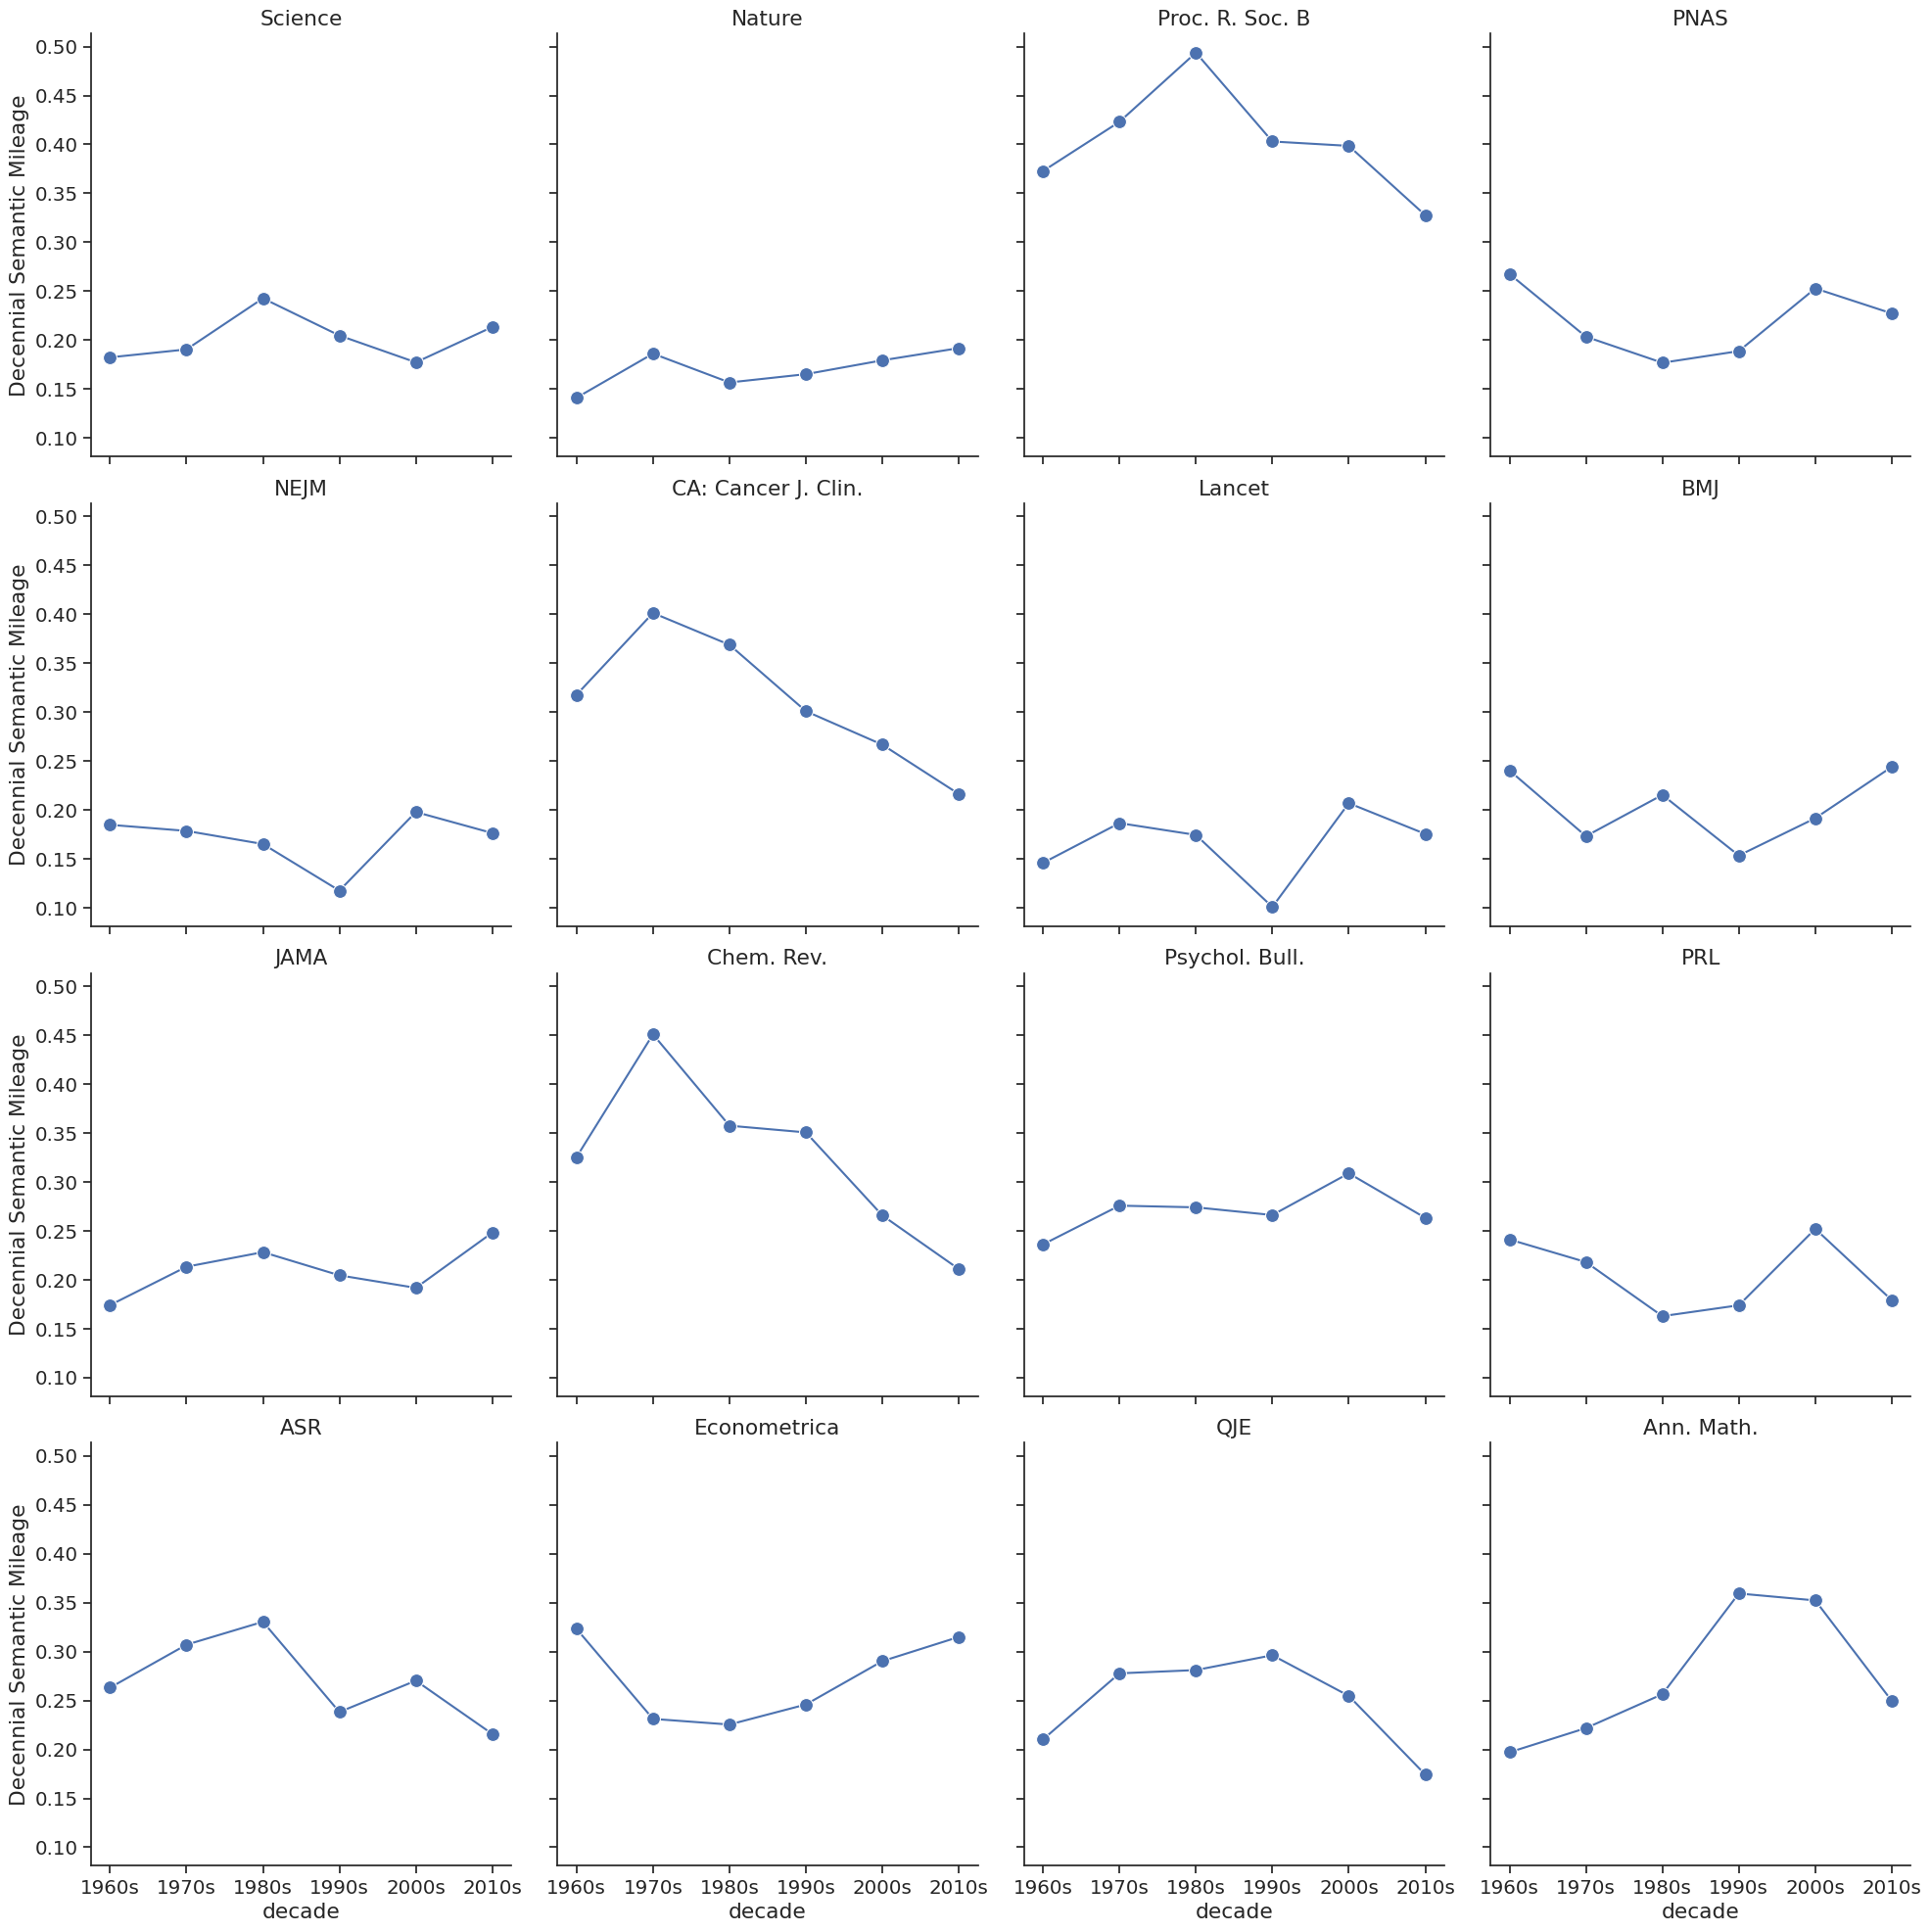

In [1173]:
self_ASM_df_rename = self_ASM_df[self_ASM_df.venue_name.isin(abbr_dict_2.keys())].copy()
self_ASM_df_rename.venue_name = self_ASM_df_rename.venue_name.replace(abbr_dict_2)

self_ASM_df_wide = pd.wide_to_long(self_ASM_df_rename,
                                    stubnames=['semantic_mileage'],
                                    suffix='.+',
                                    sep='_',
                                    i = ['VID', 'venue_name'],
                                    j = 'decade')

plt.figure(dpi=300)
with sns.plotting_context("notebook", font_scale=1.3):
    g = sns.relplot(data=self_ASM_df_wide,
                     x='decade', y='semantic_mileage',
                     legend=False,
                     col='venue_name', col_wrap=4, 
                     col_order=abbr_dict_2.values(),
                     kind='line', marker='o', markersize=10)
    g.tick_params(axis='both', bottom='on',left='on')
    g.set_titles("{col_name}")
    g.set_ylabels('Decennial Semantic Mileage')